# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
import os
import string

import plotly as py
import numpy as np
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='PROGRESS>>>')

from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, StandardScaler

from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

from functools import partial
import re
import gc
import os

import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()


import io
import requests
import nltk
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from nltk import wordpunct_tokenize
from sklearn.model_selection import train_test_split
import scipy.stats


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable
import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


# **Read data**

In [ ]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/jokes_dataset_MAIN_PREPROC.csv', 
                 sep=',', 
                 encoding='utf-8').set_index('id')

In [ ]:
data.head()

joke  rank
id                                                             
5tz52q  I hate how you cannot even say black paint any...     1
5tz4dd  What is the difference between a Jew in Nazi G...     0
5tz319  I recently went to America..... ...and being t...     0
5tz2wj  Brian raises his hand and says, "He is in Heav...     1
5tz1pc  You hear about the University book store worke...     0

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.isna().sum()

joke    0
rank    0
dtype: int64

In [ ]:
data['rank'].value_counts()

0    60139
2    40704
4    38302
3    34199
1    18942
Name: rank, dtype: int64

# **Preprocessing**

In [ ]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

data['joke'] = data[['joke']].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["joke"][2::100000])

Tokenized:
id
5tz319    i recently went to america ..... ... and being...
3kidb9    if you think your job is meaningless . remembe...
Name: joke, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total


for line in data['joke'].values:
    token_counts.update(line.split(" "))

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(531000, 532000)
assert len(token_counts) in range(80000, 81000)
print('Correct!')

Total unique tokens : 80705
('the', 531570)
('.', 438871)
(',', 416017)
('a', 334973)
('and', 248355)
...
('uhr', 1)
('pinat', 1)
('ddr', 1)
Correct!


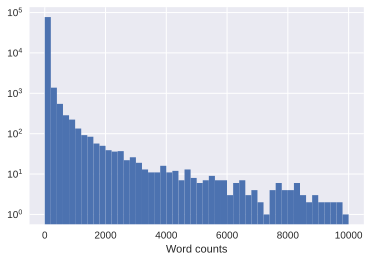

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

 Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(18000, 21000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 20434
Correct!


 Build an inverse token index: a dictionary from token(string) to it's index in tokens (int)

In [ ]:
token_to_id = {t: i for i, t in enumerate(tokens)}

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["joke"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["joke"][::100000]))

Lines:
i hate how you cannot even say black paint anymore . now i have to say " leroy can you please paint the fence ?"
why did the snowman leave his wife ?. because she got plowed by another man .

Matrix:
[[ 9138  8519  9003 20334  3066  6486 15656  2238 12898  1210   309 12348
   9138  8538 18466 15656    67 10507  3034 20334 13594 12898 18222  6923
    464]
 [19961  5387 18222 16734 10439  8787 19979   487  1977 16126  8008 13611
   2933  1173 11025   309     1     1     1     1     1     1     1     1
      1]]


# **Split**

In [ ]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

data_train, data_test = train_test_split(data_train, test_size=0.2, random_state=42)

data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))
print("Test size = ", len(data_test))

Train size =  123062
Validation size =  38458
Test size =  30766


In [ ]:
TARGET_COLUMN = 'rank'

In [ ]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["joke"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["joke"] = as_matrix(data["joke"].values, max_len)
    
    if word_dropout != 0:
        batch["joke"] = apply_word_dropout(batch["joke"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
make_batch(data_train[:3], max_len=10)

{'joke': tensor([[19961, 19725,  9876,     0,   588, 18222, 12157,  9659,   487,  1977],
         [19925,   257, 18151,   257,  1110,  2003, 19649,  9594,   552,  1817],
         [18965, 10500,  1326, 13581, 13676,   336, 18222, 12576, 18326,  9281]]),
 'rank': tensor([4, 1, 1])}

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

# **Utils**

In [ ]:
import os

In [ ]:
def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))

    model_state_dict = model.state_dict().copy()

    torch.save({'iteration': iteration,
                'state_dict': model_state_dict,
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)

In [ ]:
def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')

    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [ ]:
def train(model, optimizer, criterion, 
          data_train, data_val, 
          batch_size=128,
          epochs=100, iter_per_validation=50,
          early_stopping=False,
          checkpoint_path="./best_checkpoint",
          save_by="accuracy",
          device=DEVICE,  **kw):
  count = 0
  patience = 5
 
  iteration = 0
  loss_list = []
  iteration_list = []
  accuracy_list = []
  best_score = None


  best_score = None

  for epoch in range(epochs):
      print(f"Epoch {epoch}")

      # for vec, vlen, labels in train_loader:
      for i, batch in tqdm.notebook.tqdm(
                      enumerate(iterate_minibatches(
                                          data_train, 
                                          batch_size=batch_size, 
                                          device=DEVICE)), 
                                          total=len(data_train) // batch_size
                                          ):
          model.train()
          # Clear gradients
          optimizer.zero_grad()
        
          # Forward propagation
          outputs = model(batch)
      
          # Calculate softmax and ross entropy loss
          loss = criterion(outputs,  batch[TARGET_COLUMN])
          
          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()
          
          iteration += 1
          
          if iteration % iter_per_validation == 99:
              model.eval()
              with torch.no_grad():
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                # for i, batch in tqdm.notebook.tqdm(
                #       enumerate(iterate_minibatches(
                #                           data_val, 
                #                           batch_size=batch_size, 
                #                           device=DEVICE)), 
                #                           total=len(data_val) // batch_size
                #                           ):
                for i, batch in enumerate(iterate_minibatches(
                                        data_val, 
                                        batch_size=batch_size, 
                                        device=DEVICE)):
                    # Forward propagation
                    outputs = model(batch)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(batch[TARGET_COLUMN])
                    
                    correct += (predicted == batch[TARGET_COLUMN]).sum()
                
                accuracy = 100 * correct / float(total)
            
                # store loss and iteration
                loss_list.append(loss.data.detach().cpu().numpy())
                iteration_list.append(iteration)
                accuracy_list.append(accuracy.detach().cpu().numpy())
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iteration, loss.data, accuracy))

                # save if we have best model state
                ref_score = accuracy if save_by == "accuracy" else loss.data
                compare = (lambda x, y: x > y) if save_by == "accuracy" else (lambda x, y: x < y)
                if best_score is None or compare(ref_score, best_score):
                    best_score = ref_score
                    save_checkpoint(model, optimizer, 
                                    optimizer.state_dict()['param_groups'][0]['lr'], 
                                    iteration, checkpoint_path)
                    
                 # Early stopping if the current valid_loss is greater than the last three valid losses
                if  early_stopping == True:
                    if len(accuracy_list) > 3 and all(accuracy >= acc for acc in accuracy_list[-4:]):
                        print('Stopping early')
                        break

  return iteration_list, loss_list, accuracy_list


              
              # # Early stopping if the current valid_loss is greater than the last three valid losses
              # if len(val_loss_array) > 2 and val_loss_array[-1] > val_loss_array[-2] > val_loss_array[-3]:
              #   count +=1 
              #   if count > patience:
              #     print('Early stopping, number of epoch:', epoch)
              #     break


In [ ]:
def draw_visualization(iteration_list, loss_list, accuracy_list):
    # visualization loss 
    plt.plot(iteration_list,loss_list)
    plt.xlabel("Number of iteration")
    plt.ylabel("Loss")
    plt.title("Loss vs Number of iteration")
    plt.show()

    # visualization accuracy 
    plt.plot(iteration_list,accuracy_list,color = "red")
    plt.xlabel("Number of iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Number of iteration")
    plt.show()

!ls

%cd /content/drive/My Drive/NLP_humor/

from plot_cm import plot_confusion_matrix
from plot_roc import plot_roc

def calc_metrics(test_label, preds):
    classes_names = ['0', '1', '2', '3', '4']
    num_classes = 5

    plot_confusion_matrix(cm=metrics.confusion_matrix(test_label, preds),
                          target_names=classes_names,
                          normalize=False)
    
    print("Accuracy:",
          round(metrics.accuracy_score(test_label, preds), 5),
        '\nBalanced accuracy:',
        round(metrics.balanced_accuracy_score(test_label, preds), 5), 
        '\nMulticlass f1-score:',
        '\n    micro:', round(metrics.f1_score(test_label, preds, average='micro'), 5),
        '\n    macro:', round(metrics.f1_score(test_label, preds, average='macro'), 5),
        '\n    weighted:', round(metrics.f1_score(test_label, preds, average='weighted'), 5))

    print('\n\nClassification report:\n')
    print(metrics.classification_report(test_label, preds, digits=5))

drive  sample_data
/content/drive/My Drive/NLP_humor


# 🚩  **1. СNN архитектура**

Добавила в пайплайн

*   Batch Norm (nn.BatchNorm), LayerNorm...
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Раннюю остановку


In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

# **Параллельные сверточные слои** 
(Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы)

### **CNN layers V1**

In [ ]:
class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch['joke']).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder_2 = nn.Sequential(         
            nn.Conv1d(hid_size, hid_size ,kernel_size=3),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )


        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6 , hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features_1 = self.title_encoder(title_embeddings).squeeze()
        title_features_2 = self.title_encoder_2(title_embeddings).squeeze()
        title_features = torch.cat([title_features_1, title_features_2], dim=1)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features_1 = self.description_encoder(description_embeddings).squeeze()
        description_features_2 = self.description_encoder_2(description_embeddings).squeeze()
        description_features = torch.cat([description_features_1, description_features_2], dim=1)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**


In [ ]:
model_many_conv_layers = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_many_conv_layers.parameters(), lr=1e-3)

In [ ]:
iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_many_conv_layers, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=10, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_many_conv_layers_best_checkpoint_v2",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 69.98209
VAL  RESULTS:
Iteration: 99  Mean square error: 17.3828  Mean absolute error: 2.08098 
Saving model and optimizer state at iteration 99 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 52.80978
VAL  RESULTS:
Iteration: 199  Mean square error: 13.31949  Mean absolute error: 1.82062 
Saving model and optimizer state at iteration 199 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 36.96679
VAL  RESULTS:
Iteration: 299  Mean square error: 9.25924  Mean absolute error: 1.51644 
Saving model and optimizer state at iteration 299 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 22.35875
VAL  RESULTS:
Iteration: 399  Mean square error: 5.71538  Mean absolute error: 1.18897 
Saving model and optimizer state at iteration 399 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 12.15114
VAL  RESULTS:
Iteration: 499  Mean square error: 3.06263  Mean absolute error: 0.86629 
Saving model and optimizer state at iteration 499 to ./cnn_many_conv_layers_best_

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.28215
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.06076  Mean absolute error: 0.09899 
Saving model and optimizer state at iteration 1299 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.19901
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.05891  Mean absolute error: 0.09737 
Saving model and optimizer state at iteration 1399 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.17759
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.0486  Mean absolute error: 0.08733 
Saving model and optimizer state at iteration 1499 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.16923
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.04386  Mean absolute error: 0.08203 
Saving model and optimizer state at iteration 1599 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.15167
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.04118  Mean absolute error: 0.07907 
Saving model and optimizer state at iteration 1699 to ./cnn_many_conv_layers_

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13409
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.0351  Mean absolute error: 0.07219 
Saving model and optimizer state at iteration 2499 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.1519
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.0344  Mean absolute error: 0.07136 
Saving model and optimizer state at iteration 2599 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.11636
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.03405  Mean absolute error: 0.07091 
Saving model and optimizer state at iteration 2699 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.11685
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.03334  Mean absolute error: 0.07005 
Saving model and optimizer state at iteration 2799 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.12658
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.03307  Mean absolute error: 0.06973 
Saving model and optimizer state at iteration 2899 to ./cnn_many_conv_layers_be

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10056
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.02866  Mean absolute error: 0.06429 
Saving model and optimizer state at iteration 3699 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.10879
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.02823  Mean absolute error: 0.06374 
Saving model and optimizer state at iteration 3799 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.1072
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.02774  Mean absolute error: 0.06299 
Saving model and optimizer state at iteration 3899 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.09551
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.02699  Mean absolute error: 0.06209 
Saving model and optimizer state at iteration 3999 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.08868
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.02621  Mean absolute error: 0.06094 
Saving model and optimizer state at iteration 4099 to ./cnn_many_conv_layers_

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.08433
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.02365  Mean absolute error: 0.05748 
Saving model and optimizer state at iteration 4899 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.06615
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.02334  Mean absolute error: 0.05706 
Saving model and optimizer state at iteration 4999 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.07323
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.0233  Mean absolute error: 0.05689 
Saving model and optimizer state at iteration 5099 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.07572
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.02343  Mean absolute error: 0.0571 
train_loss 0.0684
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.02252  Mean absolute error: 0.05595 
Saving model and optimizer state at iteration 5299 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.09535
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.02275  M

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06299
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.0219  Mean absolute error: 0.05521 
train_loss 0.07276
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.02118  Mean absolute error: 0.05405 
Saving model and optimizer state at iteration 6299 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.11498
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.02221  Mean absolute error: 0.05561 
train_loss 0.05369
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.02199  Mean absolute error: 0.05529 
train_loss 0.09076
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.02066  Mean absolute error: 0.05321 
Saving model and optimizer state at iteration 6599 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.08398
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.02061  Mean absolute error: 0.05309 
Saving model and optimizer state at iteration 6699 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.08118
VAL  RESULTS:
Iteration: 6799  Mean square err

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07681
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.02041  Mean absolute error: 0.05289 
train_loss 0.07456
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.02146  Mean absolute error: 0.05463 
train_loss 0.07051
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.02008  Mean absolute error: 0.05238 
train_loss 0.08963
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.02007  Mean absolute error: 0.05236 
Saving model and optimizer state at iteration 7699 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.06197
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.02093  Mean absolute error: 0.05379 
train_loss 0.05493
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.02035  Mean absolute error: 0.05284 
train_loss 0.08155
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.01963  Mean absolute error: 0.05169 
Saving model and optimizer state at iteration 7999 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.08371
VAL  RESULTS:
Iteration: 8099  Me

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.05246
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.01944  Mean absolute error: 0.05144 
train_loss 0.06735
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.0207  Mean absolute error: 0.05354 
train_loss 0.0565
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.01969  Mean absolute error: 0.05182 
train_loss 0.05304
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.01984  Mean absolute error: 0.05205 
train_loss 0.05889
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.02108  Mean absolute error: 0.05417 
train_loss 0.0662
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.02043  Mean absolute error: 0.05311 
train_loss 0.06861
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.02057  Mean absolute error: 0.05333 
train_loss 0.06442
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.01894  Mean absolute error: 0.05066 
Saving model and optimizer state at iteration 9299 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.06957
VAL  RESULTS:
Iteration:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.08758
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.02001  Mean absolute error: 0.05257 
train_loss 0.04671
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.01906  Mean absolute error: 0.05085 
train_loss 0.05637
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.01943  Mean absolute error: 0.05151 
train_loss 0.05549
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.0196  Mean absolute error: 0.05179 
train_loss 0.06645
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.01968  Mean absolute error: 0.052 
train_loss 0.0757
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.01942  Mean absolute error: 0.05153 
train_loss 0.05727
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.02027  Mean absolute error: 0.053 
train_loss 0.05717
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.01946  Mean absolute error: 0.05164 
train_loss 0.06549
VAL  RESULTS:
Iteration: 10599  Mean square error: 0.01859  Mean absolute error: 0.05023 
Saving model and optimizer s

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06929
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.02129  Mean absolute error: 0.05477 
train_loss 0.04943
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.01856  Mean absolute error: 0.05015 
Saving model and optimizer state at iteration 11199 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.05896
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.01882  Mean absolute error: 0.05062 
train_loss 0.0685
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.01877  Mean absolute error: 0.05048 
train_loss 0.0594
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.01883  Mean absolute error: 0.05066 
train_loss 0.05181
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.01853  Mean absolute error: 0.05017 
Saving model and optimizer state at iteration 11599 to ./cnn_many_conv_layers_best_checkpoint_v2
train_loss 0.06758
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.01856  Mean absolute error: 0.05018 
train_loss 0.05759
VAL  RESULTS:
Iteration: 1

**Visualization**

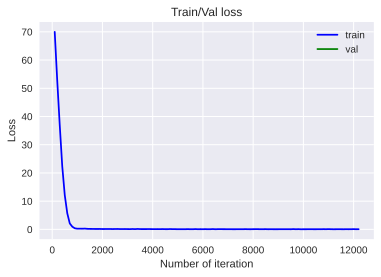

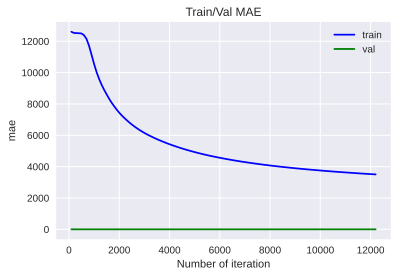

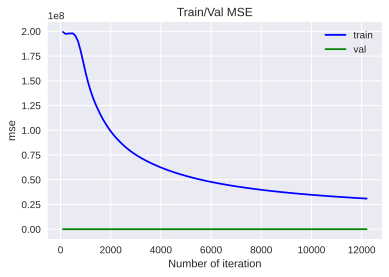

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_many_conv_layers_best_checkpoint_v2', model_many_conv_layers, optimizer)

Loading checkpoint './cnn_many_conv_layers_best_checkpoint_v2'
Loaded checkpoint './cnn_many_conv_layers_best_checkpoint_v2' from iteration 12099


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_many_conv_layers, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.01787
MAE:  0.04926
LOSS:  0.07147


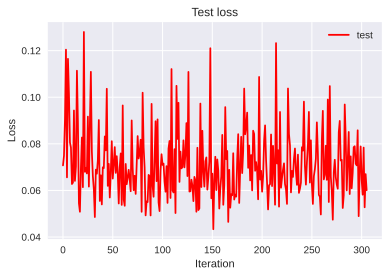

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

Metrics decrease smoothly. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 

* *** Average cross-validation scores ***:  
MSE:  0.01787  
MAE:  0.04926  
LOSS:  0.07147  

### **Add more Conv. layers V2**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.title_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
         )
        self.title_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size ,kernel_size=5),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
          
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size ,kernel_size=5),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4*2, hid_size),
            nn.GroupNorm(1, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features_1 = self.title_encoder(title_embeddings).squeeze()
        title_features_2 = self.title_encoder_2(title_embeddings).squeeze()
        title_features_3 = self.title_encoder_3(title_embeddings).squeeze()
        title_features = torch.cat([title_features_1, title_features_2, title_features_3], dim=1)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features_1 = self.description_encoder(description_embeddings).squeeze()
        description_features_2 = self.description_encoder_2(description_embeddings).squeeze()
        description_features_3 = self.description_encoder_3(description_embeddings).squeeze()
        description_features = torch.cat([description_features_1, description_features_2, description_features_3], dim=1)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_bn = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_bn.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_bn, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_bn_best_checkpoint_v2",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 78.52852
VAL  RESULTS:
Iteration: 99  Mean square error: 19.84022  Mean absolute error: 2.2237 
Saving model and optimizer state at iteration 99 to ./cnn_bn_best_checkpoint_v2
train_loss 65.3709
VAL  RESULTS:
Iteration: 199  Mean square error: 16.49154  Mean absolute error: 2.02675 
Saving model and optimizer state at iteration 199 to ./cnn_bn_best_checkpoint_v2
train_loss 51.96672
VAL  RESULTS:
Iteration: 299  Mean square error: 12.90398  Mean absolute error: 1.79187 
Saving model and optimizer state at iteration 299 to ./cnn_bn_best_checkpoint_v2
train_loss 37.00288
VAL  RESULTS:
Iteration: 399  Mean square error: 9.39919  Mean absolute error: 1.52794 
Saving model and optimizer state at iteration 399 to ./cnn_bn_best_checkpoint_v2
train_loss 25.26584
VAL  RESULTS:
Iteration: 499  Mean square error: 6.30427  Mean absolute error: 1.24935 
Saving model and optimizer state at iteration 499 to ./cnn_bn_best_checkpoint_v2
train_loss 15.42384
VAL  RESULTS:
Iteration: 599  Mean s

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.32001
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.06452  Mean absolute error: 0.10183 
Saving model and optimizer state at iteration 1299 to ./cnn_bn_best_checkpoint_v2
train_loss 0.26065
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.06159  Mean absolute error: 0.09965 
Saving model and optimizer state at iteration 1399 to ./cnn_bn_best_checkpoint_v2
train_loss 0.25412
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.06074  Mean absolute error: 0.099 
Saving model and optimizer state at iteration 1499 to ./cnn_bn_best_checkpoint_v2
train_loss 0.14682
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.04969  Mean absolute error: 0.08757 
Saving model and optimizer state at iteration 1599 to ./cnn_bn_best_checkpoint_v2
train_loss 0.20908
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.04547  Mean absolute error: 0.08312 
Saving model and optimizer state at iteration 1699 to ./cnn_bn_best_checkpoint_v2
train_loss 0.20967
VAL  RESULTS:
Iteration: 1799  Me

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.12436
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.03643  Mean absolute error: 0.07421 
Saving model and optimizer state at iteration 2499 to ./cnn_bn_best_checkpoint_v2
train_loss 0.15911
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.03693  Mean absolute error: 0.07482 
train_loss 0.15539
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.0349  Mean absolute error: 0.07237 
Saving model and optimizer state at iteration 2699 to ./cnn_bn_best_checkpoint_v2
train_loss 0.12002
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.0333  Mean absolute error: 0.07054 
Saving model and optimizer state at iteration 2799 to ./cnn_bn_best_checkpoint_v2
train_loss 0.12288
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.03182  Mean absolute error: 0.06875 
Saving model and optimizer state at iteration 2899 to ./cnn_bn_best_checkpoint_v2
train_loss 0.15129
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.03072  Mean absolute error: 0.0673 
Saving model and optimizer 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10252
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.02636  Mean absolute error: 0.06134 
Saving model and optimizer state at iteration 3699 to ./cnn_bn_best_checkpoint_v2
train_loss 0.0963
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.02628  Mean absolute error: 0.06137 
Saving model and optimizer state at iteration 3799 to ./cnn_bn_best_checkpoint_v2
train_loss 0.0913
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.02567  Mean absolute error: 0.06048 
Saving model and optimizer state at iteration 3899 to ./cnn_bn_best_checkpoint_v2
train_loss 0.09362
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.02535  Mean absolute error: 0.06003 
Saving model and optimizer state at iteration 3999 to ./cnn_bn_best_checkpoint_v2
train_loss 0.08782
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.02543  Mean absolute error: 0.06017 
train_loss 0.11086
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.025  Mean absolute error: 0.05956 
Saving model and optimizer s

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07908
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.02255  Mean absolute error: 0.05603 
Saving model and optimizer state at iteration 4899 to ./cnn_bn_best_checkpoint_v2
train_loss 0.08707
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.02257  Mean absolute error: 0.05605 
train_loss 0.09402
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.02356  Mean absolute error: 0.05746 
train_loss 0.08222
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.02205  Mean absolute error: 0.05523 
Saving model and optimizer state at iteration 5199 to ./cnn_bn_best_checkpoint_v2
train_loss 0.07917
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.02261  Mean absolute error: 0.05611 
train_loss 0.0747
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.02248  Mean absolute error: 0.05583 
train_loss 0.08671
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.02194  Mean absolute error: 0.05507 
Saving model and optimizer state at iteration 5499 to ./cnn_bn_best_checkpoint_v2

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06628
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.02165  Mean absolute error: 0.05479 
train_loss 0.06768
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.02255  Mean absolute error: 0.0561 
train_loss 0.08646
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.02059  Mean absolute error: 0.05322 
Saving model and optimizer state at iteration 6399 to ./cnn_bn_best_checkpoint_v2
train_loss 0.08102
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.0206  Mean absolute error: 0.0531 
train_loss 0.07904
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.02052  Mean absolute error: 0.05307 
Saving model and optimizer state at iteration 6599 to ./cnn_bn_best_checkpoint_v2
train_loss 0.07511
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.02004  Mean absolute error: 0.05239 
Saving model and optimizer state at iteration 6699 to ./cnn_bn_best_checkpoint_v2
train_loss 0.07357
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.02007  Mean absolute error: 0.05239 
t

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06606
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.01969  Mean absolute error: 0.05206 
Saving model and optimizer state at iteration 7399 to ./cnn_bn_best_checkpoint_v2
train_loss 0.0951
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.01947  Mean absolute error: 0.05169 
Saving model and optimizer state at iteration 7499 to ./cnn_bn_best_checkpoint_v2
train_loss 0.04722
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.01938  Mean absolute error: 0.05141 
Saving model and optimizer state at iteration 7599 to ./cnn_bn_best_checkpoint_v2
train_loss 0.06395
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.01947  Mean absolute error: 0.05163 
train_loss 0.05079
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.01927  Mean absolute error: 0.05122 
Saving model and optimizer state at iteration 7799 to ./cnn_bn_best_checkpoint_v2
train_loss 0.05154
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.01928  Mean absolute error: 0.05129 
train_loss 0.07675
VAL  R

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.05981
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.0187  Mean absolute error: 0.05054 
train_loss 0.04838
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.01856  Mean absolute error: 0.05021 
Saving model and optimizer state at iteration 8699 to ./cnn_bn_best_checkpoint_v2
train_loss 0.08302
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.0186  Mean absolute error: 0.05018 
train_loss 0.05981
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.01847  Mean absolute error: 0.05009 
Saving model and optimizer state at iteration 8899 to ./cnn_bn_best_checkpoint_v2
train_loss 0.07187
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.0184  Mean absolute error: 0.04989 
Saving model and optimizer state at iteration 8999 to ./cnn_bn_best_checkpoint_v2
train_loss 0.05777
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.01834  Mean absolute error: 0.04985 
Saving model and optimizer state at iteration 9099 to ./cnn_bn_best_checkpoint_v2
train_loss 0.07394
VAL  RES

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.0955
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.01838  Mean absolute error: 0.0499 
train_loss 0.08307
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.01808  Mean absolute error: 0.04955 
train_loss 0.07251
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.01804  Mean absolute error: 0.04964 
train_loss 0.05884
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.01812  Mean absolute error: 0.04963 
train_loss 0.06092
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.0181  Mean absolute error: 0.04961 
train_loss 0.05762
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.01785  Mean absolute error: 0.04912 
Saving model and optimizer state at iteration 10299 to ./cnn_bn_best_checkpoint_v2
train_loss 0.06672
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.01779  Mean absolute error: 0.04908 
Saving model and optimizer state at iteration 10399 to ./cnn_bn_best_checkpoint_v2
train_loss 0.05309
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.01776

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06889
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.01864  Mean absolute error: 0.0504 
train_loss 0.06098
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.01764  Mean absolute error: 0.04882 
train_loss 0.05459
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.01788  Mean absolute error: 0.04933 
train_loss 0.06656
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.01806  Mean absolute error: 0.04966 
train_loss 0.04926
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.01751  Mean absolute error: 0.04863 
train_loss 0.05217
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.01741  Mean absolute error: 0.04841 
Saving model and optimizer state at iteration 11599 to ./cnn_bn_best_checkpoint_v2
train_loss 0.06643
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.01818  Mean absolute error: 0.04995 
train_loss 0.06789
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.0175  Mean absolute error: 0.04852 
train_loss 0.05607
VAL  RESULTS:
Iteration: 118

**Visualization**

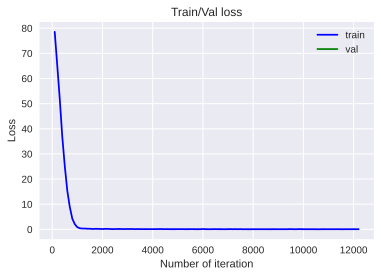

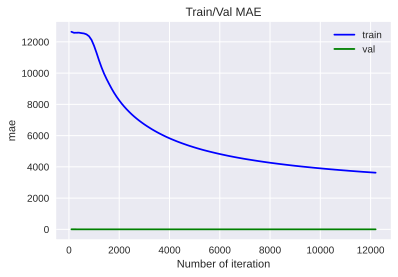

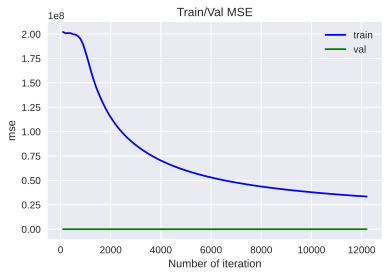

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_bn_best_checkpoint_v2', model_bn, optimizer)

Loading checkpoint './cnn_bn_best_checkpoint_v2'
Loaded checkpoint './cnn_bn_best_checkpoint_v2' from iteration 12199


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_bn, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.01706
MAE:  0.048
LOSS:  0.06823


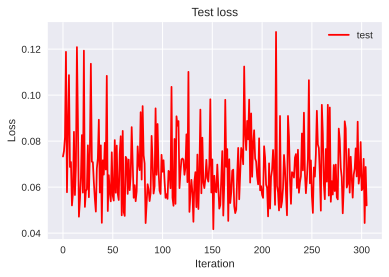

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

Metrics decrease smoothly. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 

* *** Average cross-validation scores ***:  
MSE:  0.01706  
MAE:  0.048  
LOSS:  0.06823  


### **CNN V3 (add MaxPooling)**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.MaxPool1d(4),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_bn_v3 = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_bn_v3.parameters(), lr=1e-3)

In [ ]:
iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_bn_v3, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_bn_best_checkpoint_v3",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 85.47479
VAL  RESULTS:
Iteration: 99  Mean square error: 21.25194  Mean absolute error: 2.30038 
Saving model and optimizer state at iteration 99 to ./cnn_bn_best_checkpoint_v3
train_loss 70.03483
VAL  RESULTS:
Iteration: 199  Mean square error: 17.58555  Mean absolute error: 2.09188 
Saving model and optimizer state at iteration 199 to ./cnn_bn_best_checkpoint_v3
train_loss 53.09028
VAL  RESULTS:
Iteration: 299  Mean square error: 13.68288  Mean absolute error: 1.84232 
Saving model and optimizer state at iteration 299 to ./cnn_bn_best_checkpoint_v3
train_loss 37.14458
VAL  RESULTS:
Iteration: 399  Mean square error: 9.55649  Mean absolute error: 1.53289 
Saving model and optimizer state at iteration 399 to ./cnn_bn_best_checkpoint_v3
train_loss 22.13441
VAL  RESULTS:
Iteration: 499  Mean square error: 5.92398  Mean absolute error: 1.20233 
Saving model and optimizer state at iteration 499 to ./cnn_bn_best_checkpoint_v3
train_loss 12.11083
VAL  RESULTS:
Iteration: 599  Mean

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.26477
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.12584  Mean absolute error: 0.14235 
Saving model and optimizer state at iteration 1299 to ./cnn_bn_best_checkpoint_v3
train_loss 0.23117
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.11008  Mean absolute error: 0.13315 
Saving model and optimizer state at iteration 1399 to ./cnn_bn_best_checkpoint_v3
train_loss 0.26963
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.17472  Mean absolute error: 0.17821 
train_loss 0.28335
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.147  Mean absolute error: 0.15968 
train_loss 0.24096
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.10696  Mean absolute error: 0.12856 
Saving model and optimizer state at iteration 1699 to ./cnn_bn_best_checkpoint_v3
train_loss 0.29372
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.12631  Mean absolute error: 0.14651 
train_loss 0.20325
VAL  RESULTS:
Iteration: 1899  Mean square error: 0.08263  Mean absolute error: 0.11442 


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.16428
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.08819  Mean absolute error: 0.1152 
train_loss 0.16855
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.09395  Mean absolute error: 0.12029 
train_loss 0.16894
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.07348  Mean absolute error: 0.10569 
train_loss 0.19282
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.1169  Mean absolute error: 0.14095 
train_loss 0.15827
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.09517  Mean absolute error: 0.12527 
train_loss 0.1601
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.07377  Mean absolute error: 0.10331 
train_loss 0.21555
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.06863  Mean absolute error: 0.10118 
Saving model and optimizer state at iteration 3099 to ./cnn_bn_best_checkpoint_v3
train_loss 0.22276
VAL  RESULTS:
Iteration: 3199  Mean square error: 0.16122  Mean absolute error: 0.17305 
train_loss 0.14123
VAL  RESULTS:
Iteration: 3299  Mean sq

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.12728
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.09235  Mean absolute error: 0.11992 
train_loss 0.27436
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.08332  Mean absolute error: 0.11254 
train_loss 0.1468
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.06586  Mean absolute error: 0.09947 
train_loss 0.1778
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.05634  Mean absolute error: 0.09154 
Saving model and optimizer state at iteration 3999 to ./cnn_bn_best_checkpoint_v3
train_loss 0.16288
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.05606  Mean absolute error: 0.09099 
Saving model and optimizer state at iteration 4099 to ./cnn_bn_best_checkpoint_v3
train_loss 0.1568
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.08052  Mean absolute error: 0.11119 
train_loss 0.13365
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.05795  Mean absolute error: 0.09214 
train_loss 0.28911
VAL  RESULTS:
Iteration: 4399  Mean square error: 0.0556  Mean a

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13233
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.05041  Mean absolute error: 0.08639 
train_loss 0.16253
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.05621  Mean absolute error: 0.09356 
train_loss 0.14768
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.05051  Mean absolute error: 0.0878 
train_loss 0.16539
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.06003  Mean absolute error: 0.09734 
train_loss 0.25592
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.08219  Mean absolute error: 0.11516 
train_loss 0.12168
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.05981  Mean absolute error: 0.09601 
train_loss 0.12762
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.04642  Mean absolute error: 0.08351 
train_loss 0.08786
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.0518  Mean absolute error: 0.08722 
train_loss 0.09882
VAL  RESULTS:
Iteration: 5699  Mean square error: 0.04094  Mean absolute error: 0.07834 
Saving model and optimizer sta

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.11909
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.0606  Mean absolute error: 0.09946 
train_loss 0.13331
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.0584  Mean absolute error: 0.09692 
train_loss 0.11979
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.06177  Mean absolute error: 0.09989 
train_loss 0.12305
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.0427  Mean absolute error: 0.07977 
train_loss 0.12861
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.0508  Mean absolute error: 0.08636 
train_loss 0.1277
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.05486  Mean absolute error: 0.09284 
train_loss 0.13633
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.0558  Mean absolute error: 0.09157 
train_loss 0.12654
VAL  RESULTS:
Iteration: 6899  Mean square error: 0.07003  Mean absolute error: 0.1071 
train_loss 0.10075
VAL  RESULTS:
Iteration: 6999  Mean square error: 0.05883  Mean absolute error: 0.09368 
train_loss 0.12023
VAL  RESULTS:
It

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.1393
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.04484  Mean absolute error: 0.08096 
train_loss 0.15587
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.06129  Mean absolute error: 0.10015 
train_loss 0.11886
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.04015  Mean absolute error: 0.07576 
train_loss 0.13557
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.04547  Mean absolute error: 0.08071 
train_loss 0.0967
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.04258  Mean absolute error: 0.08085 
train_loss 0.09702
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.03823  Mean absolute error: 0.07401 
Saving model and optimizer state at iteration 7899 to ./cnn_bn_best_checkpoint_v3
train_loss 0.09699
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.04446  Mean absolute error: 0.07993 
train_loss 0.13163
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.04364  Mean absolute error: 0.07904 
train_loss 0.10904
VAL  RESULTS:
Iteration: 8199  Mean s

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.11315
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.03802  Mean absolute error: 0.0747 
Saving model and optimizer state at iteration 8599 to ./cnn_bn_best_checkpoint_v3
train_loss 0.11988
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.04044  Mean absolute error: 0.07716 
train_loss 0.14205
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.03225  Mean absolute error: 0.06785 
Saving model and optimizer state at iteration 8799 to ./cnn_bn_best_checkpoint_v3
train_loss 0.10043
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.0421  Mean absolute error: 0.07848 
train_loss 0.10499
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.06192  Mean absolute error: 0.10033 
train_loss 0.10365
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.04012  Mean absolute error: 0.07636 
train_loss 0.11432
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.02966  Mean absolute error: 0.06518 
Saving model and optimizer state at iteration 9199 to ./cnn_bn_best_checkpoint_v3


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09706
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.03451  Mean absolute error: 0.07018 
train_loss 0.11311
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.04215  Mean absolute error: 0.07857 
train_loss 0.11961
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.04577  Mean absolute error: 0.08374 
train_loss 0.07518
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.044  Mean absolute error: 0.08155 
train_loss 0.10404
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.0314  Mean absolute error: 0.06687 
train_loss 0.09458
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.03382  Mean absolute error: 0.06986 
train_loss 0.09005
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.04018  Mean absolute error: 0.07678 
train_loss 0.07057
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.04654  Mean absolute error: 0.0853 
train_loss 0.0876
VAL  RESULTS:
Iteration: 10599  Mean square error: 0.0393  Mean absolute error: 0.07639 
train_loss 0.09532
VAL  RESU

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09225
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.04181  Mean absolute error: 0.08023 
train_loss 0.08416
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.04005  Mean absolute error: 0.07769 
train_loss 0.09477
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.02976  Mean absolute error: 0.0656 
train_loss 0.07318
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.05378  Mean absolute error: 0.09494 
train_loss 0.14861
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.05762  Mean absolute error: 0.0982 
train_loss 0.11175
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.03677  Mean absolute error: 0.07452 
train_loss 0.10983
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.03976  Mean absolute error: 0.07787 
train_loss 0.11799
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.03182  Mean absolute error: 0.06824 
train_loss 0.0911
VAL  RESULTS:
Iteration: 11899  Mean square error: 0.04025  Mean absolute error: 0.07839 
train_loss 0.1423
VAL 

**Visualization**

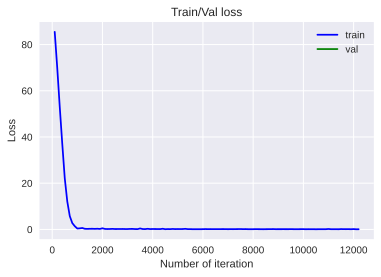

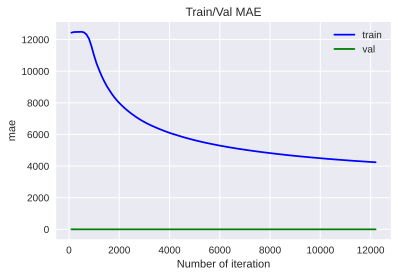

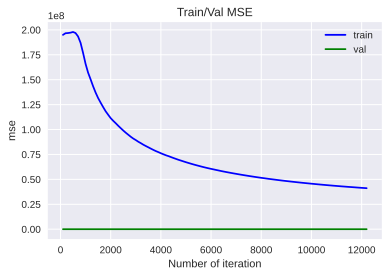

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)


**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_bn_best_checkpoint_v3', model_bn_v3, optimizer)

Loading checkpoint './cnn_bn_best_checkpoint_v3'
Loaded checkpoint './cnn_bn_best_checkpoint_v3' from iteration 9199


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_bn_v3, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.02946
MAE:  0.06511
LOSS:  0.11783


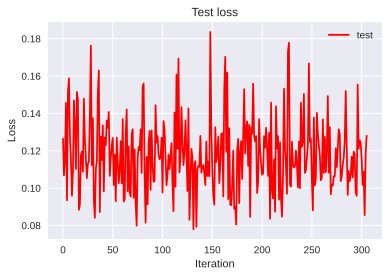

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 

* *** Average cross-validation scores ***:  
MSE:  0.02946
MAE:  0.06511
LOSS:  0.11783


### **CNN V4 (add more Conv. layers & MaxPooling)**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder_4 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )


        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder_2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size*2, kernel_size=3),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder_3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder_4 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 14, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features_1 = self.title_encoder(title_embeddings).squeeze()
        title_features_2 = self.title_encoder_2(title_embeddings).squeeze()
        title_features_3 = self.title_encoder_3(title_embeddings).squeeze()
        title_features_4 = self.title_encoder_4(title_embeddings).squeeze()
        title_features = torch.cat([title_features_1, title_features_2, title_features_3, title_features_4], dim=1)


        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features_1 = self.description_encoder(description_embeddings).squeeze()
        description_features_2 = self.description_encoder_2(description_embeddings).squeeze()
        description_features_3 = self.description_encoder_3(description_embeddings).squeeze()
        description_features_4 = self.description_encoder_4(description_embeddings).squeeze()
        description_features = torch.cat([description_features_1, description_features_2, description_features_3, description_features_4], dim=1)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_cnn_v4 = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_cnn_v4.parameters(), lr=1e-3)

In [ ]:
iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_cnn_v4, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_best_checkpoint_v4",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 91.30481
VAL  RESULTS:
Iteration: 99  Mean square error: 23.41042  Mean absolute error: 2.41517 
Saving model and optimizer state at iteration 99 to ./cnn_best_checkpoint_v4
train_loss 80.01404
VAL  RESULTS:
Iteration: 199  Mean square error: 20.39538  Mean absolute error: 2.25348 
Saving model and optimizer state at iteration 199 to ./cnn_best_checkpoint_v4
train_loss 64.43353
VAL  RESULTS:
Iteration: 299  Mean square error: 16.13082  Mean absolute error: 2.00297 
Saving model and optimizer state at iteration 299 to ./cnn_best_checkpoint_v4
train_loss 49.62541
VAL  RESULTS:
Iteration: 399  Mean square error: 12.24279  Mean absolute error: 1.74095 
Saving model and optimizer state at iteration 399 to ./cnn_best_checkpoint_v4
train_loss 33.21443
VAL  RESULTS:
Iteration: 499  Mean square error: 8.29427  Mean absolute error: 1.42082 
Saving model and optimizer state at iteration 499 to ./cnn_best_checkpoint_v4
train_loss 17.91215
VAL  RESULTS:
Iteration: 599  Mean square error:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.4467
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.10192  Mean absolute error: 0.12505 
train_loss 0.23766
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.21815  Mean absolute error: 0.20194 
train_loss 0.31221
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.05857  Mean absolute error: 0.09071 
Saving model and optimizer state at iteration 1499 to ./cnn_best_checkpoint_v4
train_loss 0.28457
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.07406  Mean absolute error: 0.10598 
train_loss 0.17562
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.08975  Mean absolute error: 0.1188 
train_loss 0.45287
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.05571  Mean absolute error: 0.08968 
Saving model and optimizer state at iteration 1799 to ./cnn_best_checkpoint_v4
train_loss 0.39255
VAL  RESULTS:
Iteration: 1899  Mean square error: 0.11965  Mean absolute error: 0.14442 
train_loss 0.16753
VAL  RESULTS:
Iteration: 1999  Mean square error: 0.06737  Mean absol

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.18283
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.05122  Mean absolute error: 0.08732 
Saving model and optimizer state at iteration 2499 to ./cnn_best_checkpoint_v4
train_loss 0.49109
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.05373  Mean absolute error: 0.08687 
train_loss 0.23137
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.06431  Mean absolute error: 0.09775 
train_loss 0.14745
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.09218  Mean absolute error: 0.1148 
train_loss 0.29571
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.10458  Mean absolute error: 0.13474 
train_loss 0.18679
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.05749  Mean absolute error: 0.09266 
train_loss 0.21842
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.0556  Mean absolute error: 0.09077 
train_loss 0.38958
VAL  RESULTS:
Iteration: 3199  Mean square error: 0.0506  Mean absolute error: 0.08648 
Saving model and optimizer state at iteration 3199 to ./cnn_

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.41167
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.04241  Mean absolute error: 0.07815 
train_loss 0.15325
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.04302  Mean absolute error: 0.07861 
train_loss 0.19518
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.04414  Mean absolute error: 0.08052 
train_loss 0.17217
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.0743  Mean absolute error: 0.10645 
train_loss 0.216
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.03904  Mean absolute error: 0.07598 
Saving model and optimizer state at iteration 4099 to ./cnn_best_checkpoint_v4
train_loss 0.5233
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.06812  Mean absolute error: 0.10374 
train_loss 0.23533
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.04421  Mean absolute error: 0.08182 
train_loss 0.19354
VAL  RESULTS:
Iteration: 4399  Mean square error: 0.04547  Mean absolute error: 0.0827 
train_loss 0.3244
VAL  RESULTS:
Iteration: 4499  Mean square e

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.27124
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.04055  Mean absolute error: 0.07837 
train_loss 0.161
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.04118  Mean absolute error: 0.07974 
train_loss 0.12454
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.04051  Mean absolute error: 0.07848 
train_loss 0.17016
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.0352  Mean absolute error: 0.07203 
Saving model and optimizer state at iteration 5199 to ./cnn_best_checkpoint_v4
train_loss 0.27456
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.03908  Mean absolute error: 0.07672 
train_loss 0.16973
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.03564  Mean absolute error: 0.07236 
train_loss 0.20459
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.03601  Mean absolute error: 0.07235 
train_loss 0.28874
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.03564  Mean absolute error: 0.07281 
train_loss 0.14894
VAL  RESULTS:
Iteration: 5699  Mean squar

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10217
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.03446  Mean absolute error: 0.07093 
train_loss 0.17852
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.06065  Mean absolute error: 0.09932 
train_loss 0.26118
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.03629  Mean absolute error: 0.07317 
train_loss 0.11672
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.03425  Mean absolute error: 0.07166 
train_loss 0.1114
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.03781  Mean absolute error: 0.07554 
train_loss 0.1302
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.04164  Mean absolute error: 0.07945 
train_loss 0.07603
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.04032  Mean absolute error: 0.07836 
train_loss 0.11832
VAL  RESULTS:
Iteration: 6899  Mean square error: 0.09883  Mean absolute error: 0.13619 
train_loss 0.26082
VAL  RESULTS:
Iteration: 6999  Mean square error: 0.03137  Mean absolute error: 0.06806 
Saving model and optimizer sta

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.14099
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.03072  Mean absolute error: 0.06684 
Saving model and optimizer state at iteration 7399 to ./cnn_best_checkpoint_v4
train_loss 0.25795
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.03925  Mean absolute error: 0.07731 
train_loss 0.2051
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.07722  Mean absolute error: 0.11368 
train_loss 0.11184
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.02927  Mean absolute error: 0.06525 
Saving model and optimizer state at iteration 7699 to ./cnn_best_checkpoint_v4
train_loss 0.41002
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.0826  Mean absolute error: 0.12181 
train_loss 0.09634
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.02959  Mean absolute error: 0.06582 
train_loss 0.11218
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.04965  Mean absolute error: 0.08944 
train_loss 0.10296
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.04099  Mean absol

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10999
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.03125  Mean absolute error: 0.06806 
train_loss 0.08571
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.03326  Mean absolute error: 0.07075 
train_loss 0.08899
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.03142  Mean absolute error: 0.06801 
train_loss 0.09339
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.02673  Mean absolute error: 0.06221 
Saving model and optimizer state at iteration 8899 to ./cnn_best_checkpoint_v4
train_loss 0.09785
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.03083  Mean absolute error: 0.06797 
train_loss 0.11456
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.03735  Mean absolute error: 0.07574 
train_loss 0.11726
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.03663  Mean absolute error: 0.07426 
train_loss 0.14106
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.02921  Mean absolute error: 0.0657 
train_loss 0.11342
VAL  RESULTS:
Iteration: 9399  Mean squ

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10616
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.02689  Mean absolute error: 0.0625 
train_loss 0.15035
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.04555  Mean absolute error: 0.08621 
train_loss 0.0882
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.04136  Mean absolute error: 0.08074 
train_loss 0.10906
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.03275  Mean absolute error: 0.07087 
train_loss 0.10126
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.02913  Mean absolute error: 0.06553 
train_loss 0.28784
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.05936  Mean absolute error: 0.1016 
train_loss 0.11888
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.0323  Mean absolute error: 0.06974 
train_loss 0.07306
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.02803  Mean absolute error: 0.06425 
train_loss 0.12472
VAL  RESULTS:
Iteration: 10599  Mean square error: 0.02818  Mean absolute error: 0.0643 
train_loss 0.16025
VAL  RES

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09325
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.02466  Mean absolute error: 0.05953 
Saving model and optimizer state at iteration 11099 to ./cnn_best_checkpoint_v4
train_loss 0.14566
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.04106  Mean absolute error: 0.08145 
train_loss 0.11449
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.02606  Mean absolute error: 0.06127 
train_loss 0.09305
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.02673  Mean absolute error: 0.06231 
train_loss 0.09479
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.0278  Mean absolute error: 0.06369 
train_loss 0.07571
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.02684  Mean absolute error: 0.06282 
train_loss 0.11627
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.0264  Mean absolute error: 0.06222 
train_loss 0.07931
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.02467  Mean absolute error: 0.05976 
train_loss 0.08738
VAL  RESULTS:
Iteration: 11899 

**Visualization**

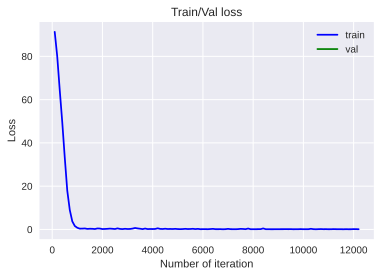

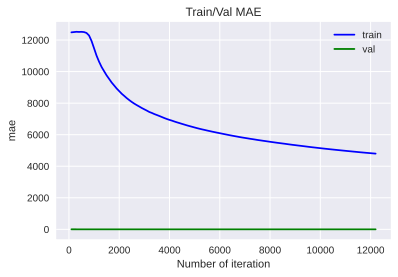

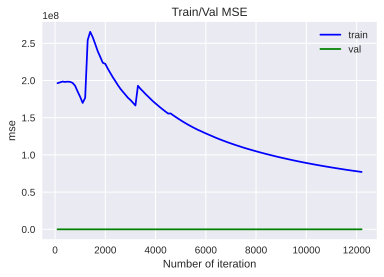

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_best_checkpoint_v4', model_cnn_v4, optimizer)

Loading checkpoint './cnn_best_checkpoint_v4'
Loaded checkpoint './cnn_best_checkpoint_v4' from iteration 11999


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_cnn_v4, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.05892
MAE:  0.10197
LOSS:  0.23567


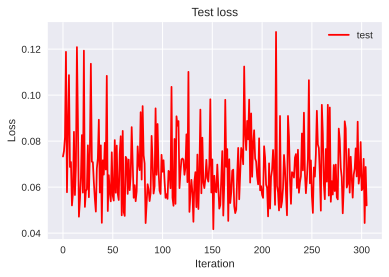

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 

* *** Average cross-validation scores ***:  
MSE:  0.05892
MAE:  0.10197
LOSS:  0.23567


### **General conclusion №1**

All models behave as similar as possible, however, the training time differs. As the layers and parameters of the model increased, the training time significantly increased. Using MaxPooling, the number of trained parameters was reduced, and the training went faster. Adding Layer Normalization layers, the model gave the best result on the test data.

# **🚩  2. Pooling слои стандартные**

*   Максимум по временной компоненте (незавимисо для каждой фичи)
*   Среднее по временной компоненте (исключая PAD символы)


## **1) Pooling слой:** 

This layer reduces the size of the feature map, works like Conv. layer. The basic idea is that we divide the output layers into subsections and calculate the value that best reflects the output data. The effectiveness of this approach lies in the fact that in this way we help the model to study higher-order data while reducing the number of parameters. Shows if there is a feature in this particular zone.

## **2) Взять максимум по временной компоненте (незавимисо для каждой фичи)**

In [ ]:
class MaxTimePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            MaxTimePooling(),
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            MaxTimePooling(),
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_mtp = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_mtp.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_mtp, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_mtp_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 107.46519
VAL  RESULTS:
Iteration: 99  Mean square error: 26.78499  Mean absolute error: 2.58372 
Saving model and optimizer state at iteration 99 to ./cnn_mtp_best_checkpoint
train_loss 93.12633
VAL  RESULTS:
Iteration: 199  Mean square error: 23.04178  Mean absolute error: 2.39446 
Saving model and optimizer state at iteration 199 to ./cnn_mtp_best_checkpoint
train_loss 77.86517
VAL  RESULTS:
Iteration: 299  Mean square error: 18.91708  Mean absolute error: 2.16447 
Saving model and optimizer state at iteration 299 to ./cnn_mtp_best_checkpoint
train_loss 62.04748
VAL  RESULTS:
Iteration: 399  Mean square error: 14.67137  Mean absolute error: 1.89886 
Saving model and optimizer state at iteration 399 to ./cnn_mtp_best_checkpoint
train_loss 43.29628
VAL  RESULTS:
Iteration: 499  Mean square error: 10.97211  Mean absolute error: 1.63447 
Saving model and optimizer state at iteration 499 to ./cnn_mtp_best_checkpoint
train_loss 27.37229
VAL  RESULTS:
Iteration: 599  Mean square

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.40174
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.10806  Mean absolute error: 0.12948 
Saving model and optimizer state at iteration 1299 to ./cnn_mtp_best_checkpoint
train_loss 0.37144
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.10789  Mean absolute error: 0.12221 
Saving model and optimizer state at iteration 1399 to ./cnn_mtp_best_checkpoint
train_loss 0.29369
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.09628  Mean absolute error: 0.11862 
Saving model and optimizer state at iteration 1499 to ./cnn_mtp_best_checkpoint
train_loss 0.3938
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.07446  Mean absolute error: 0.09925 
Saving model and optimizer state at iteration 1599 to ./cnn_mtp_best_checkpoint
train_loss 0.2761
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.07813  Mean absolute error: 0.10672 
train_loss 0.41691
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.0811  Mean absolute error: 0.10547 
train_loss 0.33017
VAL  RESULTS:
It

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.17809
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.06455  Mean absolute error: 0.09556 
train_loss 0.15843
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.05146  Mean absolute error: 0.08301 
Saving model and optimizer state at iteration 2599 to ./cnn_mtp_best_checkpoint
train_loss 0.46363
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.06737  Mean absolute error: 0.10266 
train_loss 0.28915
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.0935  Mean absolute error: 0.12131 
train_loss 0.41521
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.07043  Mean absolute error: 0.10513 
train_loss 0.73279
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.07323  Mean absolute error: 0.10474 
train_loss 0.27982
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.04578  Mean absolute error: 0.07916 
Saving model and optimizer state at iteration 3099 to ./cnn_mtp_best_checkpoint
train_loss 0.22124
VAL  RESULTS:
Iteration: 3199  Mean square error: 0.05363  Mean ab

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.15351
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.05615  Mean absolute error: 0.09032 
train_loss 0.20469
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.04438  Mean absolute error: 0.07858 
Saving model and optimizer state at iteration 3799 to ./cnn_mtp_best_checkpoint
train_loss 0.12382
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.05714  Mean absolute error: 0.09182 
train_loss 0.18011
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.04013  Mean absolute error: 0.07405 
Saving model and optimizer state at iteration 3999 to ./cnn_mtp_best_checkpoint
train_loss 0.29913
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.05391  Mean absolute error: 0.09 
train_loss 0.24082
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.07102  Mean absolute error: 0.1046 
train_loss 0.11563
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.04575  Mean absolute error: 0.08041 
train_loss 0.32081
VAL  RESULTS:
Iteration: 4399  Mean square error: 0.04069  Mean absol

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.28745
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.0391  Mean absolute error: 0.07479 
train_loss 0.34584
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.04337  Mean absolute error: 0.08066 
train_loss 0.20808
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.06768  Mean absolute error: 0.10391 
train_loss 0.19148
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.04045  Mean absolute error: 0.07648 
train_loss 0.2174
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.04121  Mean absolute error: 0.07814 
train_loss 0.14746
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.03514  Mean absolute error: 0.07066 
Saving model and optimizer state at iteration 5399 to ./cnn_mtp_best_checkpoint
train_loss 0.18639
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.03558  Mean absolute error: 0.07089 
train_loss 0.11458
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.04544  Mean absolute error: 0.08183 
train_loss 0.15361
VAL  RESULTS:
Iteration: 5699  Mean squ

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.17056
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.03355  Mean absolute error: 0.06867 
Saving model and optimizer state at iteration 6199 to ./cnn_mtp_best_checkpoint
train_loss 0.23336
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.03386  Mean absolute error: 0.06974 
train_loss 0.19755
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.03613  Mean absolute error: 0.07287 
train_loss 0.18014
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.0538  Mean absolute error: 0.09194 
train_loss 0.18858
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.04019  Mean absolute error: 0.07682 
train_loss 0.17036
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.04118  Mean absolute error: 0.07956 
train_loss 0.14471
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.03688  Mean absolute error: 0.07285 
train_loss 0.11504
VAL  RESULTS:
Iteration: 6899  Mean square error: 0.03499  Mean absolute error: 0.07178 
train_loss 0.17855
VAL  RESULTS:
Iteration: 6999  Mean sq

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10184
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.0825  Mean absolute error: 0.12057 
train_loss 0.15901
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.03221  Mean absolute error: 0.06792 
Saving model and optimizer state at iteration 7499 to ./cnn_mtp_best_checkpoint
train_loss 0.11379
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.03269  Mean absolute error: 0.06857 
train_loss 0.21464
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.04582  Mean absolute error: 0.08413 
train_loss 0.23334
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.03959  Mean absolute error: 0.07675 
train_loss 0.13549
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.0377  Mean absolute error: 0.07557 
train_loss 0.14643
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.02964  Mean absolute error: 0.06495 
Saving model and optimizer state at iteration 7999 to ./cnn_mtp_best_checkpoint
train_loss 0.14278
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.03209  Mean abs

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.16786
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.03743  Mean absolute error: 0.07584 
train_loss 0.11887
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.03229  Mean absolute error: 0.0693 
train_loss 0.1312
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.03125  Mean absolute error: 0.06698 
train_loss 0.10769
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.03727  Mean absolute error: 0.07432 
train_loss 0.15891
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.03324  Mean absolute error: 0.06959 
train_loss 0.15096
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.07822  Mean absolute error: 0.11676 
train_loss 0.16044
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.02856  Mean absolute error: 0.06385 
Saving model and optimizer state at iteration 9199 to ./cnn_mtp_best_checkpoint
train_loss 0.21117
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.04646  Mean absolute error: 0.08526 
train_loss 0.14644
VAL  RESULTS:
Iteration: 9399  Mean squ

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.25007
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.0377  Mean absolute error: 0.07671 
train_loss 0.18838
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.03058  Mean absolute error: 0.06705 
train_loss 0.19015
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.03637  Mean absolute error: 0.0747 
train_loss 0.13113
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.02802  Mean absolute error: 0.0634 
train_loss 0.1243
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.02834  Mean absolute error: 0.06372 
train_loss 0.10793
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.02702  Mean absolute error: 0.06208 
Saving model and optimizer state at iteration 10299 to ./cnn_mtp_best_checkpoint
train_loss 0.12805
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.02888  Mean absolute error: 0.06496 
train_loss 0.1263
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.03407  Mean absolute error: 0.07235 
train_loss 0.11728
VAL  RESULTS:
Iteration: 10599  Mean

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.11851
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.03191  Mean absolute error: 0.06941 
train_loss 0.08959
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.02742  Mean absolute error: 0.06322 
train_loss 0.14416
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.03377  Mean absolute error: 0.07157 
train_loss 0.19812
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.02839  Mean absolute error: 0.06464 
train_loss 0.1564
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.02607  Mean absolute error: 0.06128 
Saving model and optimizer state at iteration 11499 to ./cnn_mtp_best_checkpoint
train_loss 0.0996
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.03941  Mean absolute error: 0.0779 
train_loss 0.09752
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.0273  Mean absolute error: 0.06304 
train_loss 0.11122
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.03793  Mean absolute error: 0.07657 
train_loss 0.19401
VAL  RESULTS:
Iteration: 11899  

**Visualization**

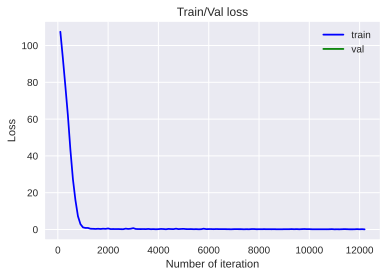

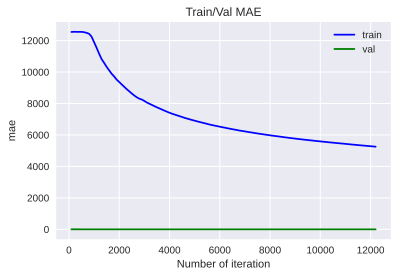

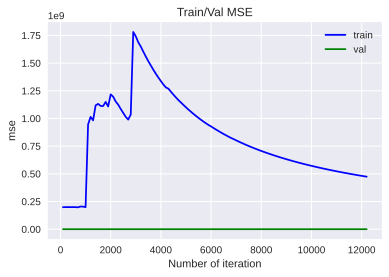

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_mtp_best_checkpoint', model_mtp, optimizer)

Loading checkpoint './cnn_mtp_best_checkpoint'
Loaded checkpoint './cnn_mtp_best_checkpoint' from iteration 11499


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_mtp, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.02626
MAE:  0.06111
LOSS:  0.10504


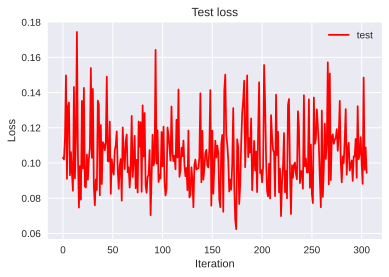

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

* This model was trained very fast due to pooling and params. reducing. The predictive ability of this model is very good.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. At the beginning, the model is unstable, but by the end of the iteration it begins to normalize and metrics are optimized and reduced.

* The convolution operation is very similar to one with images, but in this case it's applied to 1-dimensional vector of words. The max-over-time pooling operation is very simple: max_c = max(c), i.e., it's a single number that gets a max over the whole feature map. The reason to do this, instead of "down-sampling" the sentence like in a CNN, is that in NLP the sentences naturally have different length in a corpus. This makes the feature maps different for different sentences, but we'd like to reduce the tensor to a fixed size to apply softmax or regression head in the end. As stated in the paper, it allows to capture the most important feature, one with the highest value for each feature map.

* *** Average cross-validation scores ***: 
MSE:  0.02626
MAE:  0.06111
LOSS:  0.10504


## **3) Взять среднее по временной компоненте (исключая PAD символы)**

### Utils with some changes for this task

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    seq_lens = []
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        seq_lens.append(len(seq))
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix, seq_lens


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title", "lens_Title", "lens_Description"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"], lens_title = as_matrix(data["Title"].values, max_len)
    batch["lens_Title"] = lens_title

    batch["FullDescription"], lens_descr = as_matrix(data["FullDescription"].values, max_len)
    batch["lens_Description"] = lens_descr

    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

### Model

In [ ]:
class TimeAvgPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x, lens):
        mean_matrix = [None] * len(x)
        for i in range(len(x)):
          sliced_tn = x[i][:, :lens[i]]
          mean_matrix[i] = sliced_tn.mean(dim=self.dim)
        return torch.stack(mean_matrix)

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_enc_conv = nn.Conv1d(hid_size, hid_size, kernel_size=2)
        self.title_enc_pool =  TimeAvgPooling()
        
        # self.title_encoder = nn.Sequential(
        #     nn.Conv1d(hid_size, hid_size, kernel_size=2),
        #     TimeAvgPooling(),
        # )
        self.description_enc_conv = nn.Conv1d(hid_size, hid_size, kernel_size=2)
        self.description_enc_pool =   TimeAvgPooling()
        
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_enc_conv(title_embeddings).squeeze()
        title_features = self.title_enc_pool(title_features, batch['lens_Title']).squeeze()


        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_enc_conv(description_embeddings).squeeze()
        description_features = self.description_enc_pool(description_embeddings, batch['lens_Description']).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model_map = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_map.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_map, optimizer, criterion, 
          data_train, data_val, 
          batch_size=128,
          epochs=10, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_map_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 96.20557
VAL  RESULTS:
Iteration: 99  Mean square error: 16.08107  Mean absolute error: 1.63452 
Saving model and optimizer state at iteration 99 to ./cnn_map_best_checkpoint
train_loss 85.45923
VAL  RESULTS:
Iteration: 199  Mean square error: 13.97597  Mean absolute error: 1.52305 
Saving model and optimizer state at iteration 199 to ./cnn_map_best_checkpoint
train_loss 69.24108
VAL  RESULTS:
Iteration: 299  Mean square error: 11.51087  Mean absolute error: 1.38199 
Saving model and optimizer state at iteration 299 to ./cnn_map_best_checkpoint
train_loss 54.56084
VAL  RESULTS:
Iteration: 399  Mean square error: 9.22873  Mean absolute error: 1.23611 
Saving model and optimizer state at iteration 399 to ./cnn_map_best_checkpoint
train_loss 39.64042
VAL  RESULTS:
Iteration: 499  Mean square error: 6.57811  Mean absolute error: 1.04157 
Saving model and optimizer state at iteration 499 to ./cnn_map_best_checkpoint
train_loss 26.80748
VAL  RESULTS:
Iteration: 599  Mean square er

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.61088
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.08622  Mean absolute error: 0.09244 
Saving model and optimizer state at iteration 1299 to ./cnn_map_best_checkpoint
train_loss 1.36429
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.08304  Mean absolute error: 0.091 
Saving model and optimizer state at iteration 1399 to ./cnn_map_best_checkpoint
train_loss 0.72147
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.07339  Mean absolute error: 0.08535 
Saving model and optimizer state at iteration 1499 to ./cnn_map_best_checkpoint
train_loss 0.90298
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.07305  Mean absolute error: 0.0857 
Saving model and optimizer state at iteration 1599 to ./cnn_map_best_checkpoint
train_loss 0.33736
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.05822  Mean absolute error: 0.07696 
Saving model and optimizer state at iteration 1699 to ./cnn_map_best_checkpoint
train_loss 0.70505
VAL  RESULTS:
Iteration: 1799  Mean square e

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.38793
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.0379  Mean absolute error: 0.06167 
train_loss 0.33051
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.03159  Mean absolute error: 0.05666 
Saving model and optimizer state at iteration 2599 to ./cnn_map_best_checkpoint
train_loss 0.17869
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.03099  Mean absolute error: 0.05561 
Saving model and optimizer state at iteration 2699 to ./cnn_map_best_checkpoint
train_loss 0.29586
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.02921  Mean absolute error: 0.05388 
Saving model and optimizer state at iteration 2799 to ./cnn_map_best_checkpoint
train_loss 0.20259
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.02793  Mean absolute error: 0.05275 
Saving model and optimizer state at iteration 2899 to ./cnn_map_best_checkpoint
train_loss 0.70965
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.03198  Mean absolute error: 0.05629 
train_loss 0.34183
VAL  RESULTS:


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.14755
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.0262  Mean absolute error: 0.05113 
train_loss 0.74024
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.02766  Mean absolute error: 0.05265 
train_loss 0.6782
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.03086  Mean absolute error: 0.05607 
train_loss 0.20509
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.02458  Mean absolute error: 0.04935 
Saving model and optimizer state at iteration 3999 to ./cnn_map_best_checkpoint
train_loss 0.25653
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.02527  Mean absolute error: 0.05018 
train_loss 0.77793
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.02886  Mean absolute error: 0.05389 
train_loss 0.48893
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.02443  Mean absolute error: 0.04937 
Saving model and optimizer state at iteration 4299 to ./cnn_map_best_checkpoint
train_loss 0.18929
VAL  RESULTS:
Iteration: 4399  Mean square error: 0.02444  Mean abs

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.59899
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.02458  Mean absolute error: 0.04947 
train_loss 0.15534
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.0224  Mean absolute error: 0.04702 
train_loss 0.13806
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.02188  Mean absolute error: 0.04643 
Saving model and optimizer state at iteration 5099 to ./cnn_map_best_checkpoint
train_loss 0.20245
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.02167  Mean absolute error: 0.04611 
Saving model and optimizer state at iteration 5199 to ./cnn_map_best_checkpoint
train_loss 0.12505
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.02221  Mean absolute error: 0.04711 
train_loss 0.21885
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.02131  Mean absolute error: 0.0458 
Saving model and optimizer state at iteration 5399 to ./cnn_map_best_checkpoint
train_loss 0.16182
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.0215  Mean absolute error: 0.04597 
train_l

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.32151
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.01897  Mean absolute error: 0.04311 
Saving model and optimizer state at iteration 6199 to ./cnn_map_best_checkpoint
train_loss 0.45634
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.01901  Mean absolute error: 0.04296 
train_loss 0.32801
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.01905  Mean absolute error: 0.04314 
train_loss 0.13704
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.01875  Mean absolute error: 0.04279 
Saving model and optimizer state at iteration 6499 to ./cnn_map_best_checkpoint
train_loss 0.14848
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.01811  Mean absolute error: 0.04196 
Saving model and optimizer state at iteration 6599 to ./cnn_map_best_checkpoint
train_loss 0.11078
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.01842  Mean absolute error: 0.04234 
train_loss 0.11265
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.0175  Mean absolute error: 0.04102 
Savin

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10327
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.01691  Mean absolute error: 0.04027 
Saving model and optimizer state at iteration 7399 to ./cnn_map_best_checkpoint
train_loss 0.10584
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.01687  Mean absolute error: 0.04039 
Saving model and optimizer state at iteration 7499 to ./cnn_map_best_checkpoint
train_loss 0.1592
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.01769  Mean absolute error: 0.04165 
train_loss 0.12887
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.01746  Mean absolute error: 0.04093 
train_loss 0.07122
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.01656  Mean absolute error: 0.04011 
Saving model and optimizer state at iteration 7799 to ./cnn_map_best_checkpoint
train_loss 0.19824
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.01624  Mean absolute error: 0.03935 
Saving model and optimizer state at iteration 7899 to ./cnn_map_best_checkpoint
train_loss 0.13223
VAL  RESULTS:


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.2525
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.01632  Mean absolute error: 0.03984 
train_loss 0.09324
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.01538  Mean absolute error: 0.03825 
Saving model and optimizer state at iteration 8699 to ./cnn_map_best_checkpoint
train_loss 0.13774
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.01529  Mean absolute error: 0.03836 
Saving model and optimizer state at iteration 8799 to ./cnn_map_best_checkpoint
train_loss 0.13528
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.01523  Mean absolute error: 0.03824 
Saving model and optimizer state at iteration 8899 to ./cnn_map_best_checkpoint
train_loss 0.10135
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.01585  Mean absolute error: 0.03896 
train_loss 0.08982
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.01482  Mean absolute error: 0.03766 
Saving model and optimizer state at iteration 9099 to ./cnn_map_best_checkpoint
train_loss 0.22409
VAL  RESULTS:


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07385
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.01488  Mean absolute error: 0.03746 
train_loss 0.09799
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.01411  Mean absolute error: 0.03645 
Saving model and optimizer state at iteration 9899 to ./cnn_map_best_checkpoint
train_loss 0.19339
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.01575  Mean absolute error: 0.03928 
train_loss 0.12807
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.01488  Mean absolute error: 0.03759 
train_loss 0.10204
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.01416  Mean absolute error: 0.03671 
train_loss 0.08811
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.01376  Mean absolute error: 0.03595 
Saving model and optimizer state at iteration 10299 to ./cnn_map_best_checkpoint
train_loss 0.07872
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.01437  Mean absolute error: 0.03707 
train_loss 0.11357
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.01357  

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09351
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.01359  Mean absolute error: 0.03581 
train_loss 0.14786
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.01311  Mean absolute error: 0.03501 
Saving model and optimizer state at iteration 11199 to ./cnn_map_best_checkpoint
train_loss 0.07699
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.01318  Mean absolute error: 0.03511 
train_loss 0.07035
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.01314  Mean absolute error: 0.03503 
train_loss 0.10103
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.01311  Mean absolute error: 0.03505 
Saving model and optimizer state at iteration 11499 to ./cnn_map_best_checkpoint
train_loss 0.07621
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.01327  Mean absolute error: 0.03519 
train_loss 0.07923
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.0134  Mean absolute error: 0.03547 
train_loss 0.08073
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.0131

**Training**

**Save model**

In [ ]:
model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_map_regr' 
lr=1e-3
save_checkpoint(model_map, optimizer, lr, 10, model_path) 

Saving model and optimizer state at iteration 10 to /content/drive/My Drive/IAD/NLP_Lab/models/cnn_map_regr



**Visualization**

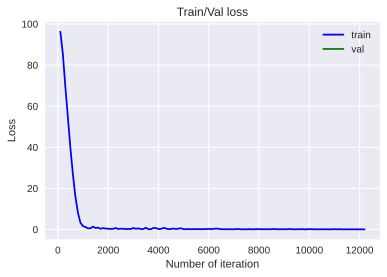

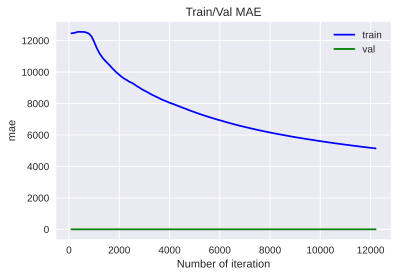

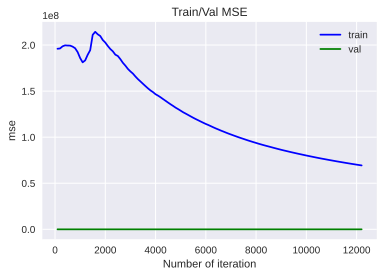

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_map_best_checkpoint', model_map, optimizer)

mse, mae, test_loss, loss_arr = make_prediction(model_map, data_test, batch_size=128, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

Loading checkpoint './cnn_map_best_checkpoint'
Loaded checkpoint './cnn_map_best_checkpoint' from iteration 12199
MSE:  0.01252
MAE:  0.03413
LOSS:  0.07512


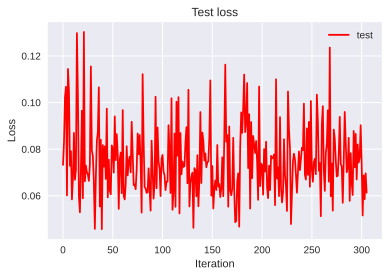

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
Average pooling blocks are inserted after one or more convolutional blocks; they help inner convolutional block receive information from a bigger portion of the original vector. If we see convolutional blocks as detectors of a specific feature, average pooling finds the “mean” value of that feature inside the pooling vector. Each channel (hence each feature) is treated separately.
* *** Average cross-validation scores ***: 

MSE:  0.01252  
MAE:  0.03413  
LOSS:  0.07512  

### **General conclusion №2**

The training took place as quickly as possible by reducing the number of parameters. When using Average over time pooling, the model showed the best results.

# **🚩 3. Предобученные эмбеддинги**

*  Эксперементы с обучаемыми/замороженными весами эмбеддингов.


## **Word2Vec**

In [ ]:
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

import gensim.downloader as gensim_api

In [ ]:
def set_weights(corpus, dim):
    weights_matrix = np.zeros((len(tokens), dim))
    for i, word in enumerate(tokens):
        try:
            weights_matrix[i] = corpus.wv[word]
        except KeyError:
            weights_matrix[i] = np.random.normal(size=dim)
    weights_matrix = torch.FloatTensor(weights_matrix)

    return weights_matrix

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM" -O GoogleNews-vectors-negative300.bin.gz && rm -rf /tmp/cookies.txt
!gunzip GoogleNews-vectors-negative300.bin.gz

--2022-04-15 09:50:43--  https://drive.google.com/uc?export=download&confirm=t&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving drive.google.com (drive.google.com)... 142.250.128.102, 142.250.128.139, 142.250.128.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.128.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qlrvqkv7n29fsv38ae1nj5qjmqbf7lt2/1650016200000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download [following]
--2022-04-15 09:50:43--  https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qlrvqkv7n29fsv38ae1nj5qjmqbf7lt2/1650016200000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download
Resolving doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleusercontent.com)... 142.251.6.132, 2607:f8b0:4001:c5a::84
Connecting to doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.g

In [ ]:
w2v_corpus = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
weights_matrix = set_weights(w2v_corpus, 300)

**Model**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, freezed=True):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights_matrix, freeze=freezed)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(300, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(300, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

### **Freeze**

**Training**

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

In [ ]:
model_w2v = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_w2v.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_w2v, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_w2v_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 105.21786
VAL  RESULTS:
Iteration: 99  Mean square error: 26.06351  Mean absolute error: 2.54955 
Saving model and optimizer state at iteration 99 to ./cnn_w2v_best_checkpoint
train_loss 94.91475
VAL  RESULTS:
Iteration: 199  Mean square error: 23.754  Mean absolute error: 2.43 
Saving model and optimizer state at iteration 199 to ./cnn_w2v_best_checkpoint
train_loss 83.23027
VAL  RESULTS:
Iteration: 299  Mean square error: 21.21435  Mean absolute error: 2.28915 
Saving model and optimizer state at iteration 299 to ./cnn_w2v_best_checkpoint
train_loss 71.79012
VAL  RESULTS:
Iteration: 399  Mean square error: 17.92669  Mean absolute error: 2.08597 
Saving model and optimizer state at iteration 399 to ./cnn_w2v_best_checkpoint
train_loss 60.28148
VAL  RESULTS:
Iteration: 499  Mean square error: 14.71466  Mean absolute error: 1.86291 
Saving model and optimizer state at iteration 499 to ./cnn_w2v_best_checkpoint
train_loss 47.83758
VAL  RESULTS:
Iteration: 599  Mean square erro

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.38056
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.49291  Mean absolute error: 0.31109 
Saving model and optimizer state at iteration 1299 to ./cnn_w2v_best_checkpoint
train_loss 0.28041
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.39102  Mean absolute error: 0.26425 
Saving model and optimizer state at iteration 1399 to ./cnn_w2v_best_checkpoint
train_loss 0.21046
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.35557  Mean absolute error: 0.25228 
Saving model and optimizer state at iteration 1499 to ./cnn_w2v_best_checkpoint
train_loss 0.20021
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.28792  Mean absolute error: 0.22324 
Saving model and optimizer state at iteration 1599 to ./cnn_w2v_best_checkpoint
train_loss 0.20089
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.24904  Mean absolute error: 0.21196 
Saving model and optimizer state at iteration 1699 to ./cnn_w2v_best_checkpoint
train_loss 0.25972
VAL  RESULTS:
Iteration: 1799  Mean squar

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13539
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.13631  Mean absolute error: 0.13723 
Saving model and optimizer state at iteration 2499 to ./cnn_w2v_best_checkpoint
train_loss 0.44231
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.20418  Mean absolute error: 0.17297 
train_loss 0.25177
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.25882  Mean absolute error: 0.2012 
train_loss 0.16471
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.26929  Mean absolute error: 0.20856 
train_loss 0.12608
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.23662  Mean absolute error: 0.1912 
train_loss 0.22264
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.17771  Mean absolute error: 0.16872 
train_loss 0.24599
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.16004  Mean absolute error: 0.14918 
train_loss 0.23724
VAL  RESULTS:
Iteration: 3199  Mean square error: 0.16066  Mean absolute error: 0.14743 
train_loss 0.15705
VAL  RESULTS:
Iteration: 3299  Mean squ

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.20753
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.18046  Mean absolute error: 0.16466 
train_loss 0.15716
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.13815  Mean absolute error: 0.14818 
train_loss 0.15099
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.1763  Mean absolute error: 0.1647 
train_loss 0.1209
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.11748  Mean absolute error: 0.13201 
Saving model and optimizer state at iteration 3999 to ./cnn_w2v_best_checkpoint
train_loss 0.11754
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.09749  Mean absolute error: 0.11319 
Saving model and optimizer state at iteration 4099 to ./cnn_w2v_best_checkpoint
train_loss 0.16494
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.06277  Mean absolute error: 0.09719 
Saving model and optimizer state at iteration 4199 to ./cnn_w2v_best_checkpoint
train_loss 0.15674
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.06394  Mean absolute error: 0.09455 
train_l

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.21509
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.06264  Mean absolute error: 0.0947 
train_loss 0.1609
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.05788  Mean absolute error: 0.0939 
Saving model and optimizer state at iteration 4999 to ./cnn_w2v_best_checkpoint
train_loss 0.23227
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.06748  Mean absolute error: 0.09807 
train_loss 0.39906
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.0641  Mean absolute error: 0.09603 
train_loss 0.11862
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.06614  Mean absolute error: 0.097 
train_loss 0.19181
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.07213  Mean absolute error: 0.09882 
train_loss 0.13595
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.08669  Mean absolute error: 0.10798 
train_loss 0.09854
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.06967  Mean absolute error: 0.09864 
train_loss 0.14486
VAL  RESULTS:
Iteration: 5699  Mean square 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.21171
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.06784  Mean absolute error: 0.09834 
train_loss 0.13815
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.06932  Mean absolute error: 0.09713 
train_loss 0.18507
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.09522  Mean absolute error: 0.11435 
train_loss 0.2221
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.07317  Mean absolute error: 0.10033 
train_loss 0.19566
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.07027  Mean absolute error: 0.09783 
train_loss 0.12879
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.07959  Mean absolute error: 0.10306 
train_loss 0.11261
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.06756  Mean absolute error: 0.09628 
train_loss 0.10527
VAL  RESULTS:
Iteration: 6899  Mean square error: 0.05867  Mean absolute error: 0.09347 
train_loss 0.11856
VAL  RESULTS:
Iteration: 6999  Mean square error: 0.06687  Mean absolute error: 0.09592 
train_loss 0.08278
VAL  RESUL

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.0867
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.07426  Mean absolute error: 0.09945 
train_loss 0.12855
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.07059  Mean absolute error: 0.09869 
train_loss 0.10407
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.08415  Mean absolute error: 0.10771 
train_loss 0.07581
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.07021  Mean absolute error: 0.09774 
train_loss 0.10448
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.05692  Mean absolute error: 0.08903 
Saving model and optimizer state at iteration 7799 to ./cnn_w2v_best_checkpoint
train_loss 0.11776
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.06037  Mean absolute error: 0.09239 
train_loss 0.13813
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.06704  Mean absolute error: 0.09517 
train_loss 0.10084
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.06276  Mean absolute error: 0.09403 
train_loss 0.17742
VAL  RESULTS:
Iteration: 8199  Mean sq

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.14288
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.08481  Mean absolute error: 0.10421 
train_loss 0.17345
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.06278  Mean absolute error: 0.09313 
train_loss 0.09835
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.07186  Mean absolute error: 0.0979 
train_loss 0.11557
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.06803  Mean absolute error: 0.09818 
train_loss 0.10224
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.06995  Mean absolute error: 0.09753 
train_loss 0.09733
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.08042  Mean absolute error: 0.10297 
train_loss 0.11226
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.08225  Mean absolute error: 0.10357 
train_loss 0.11559
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.07365  Mean absolute error: 0.10142 
train_loss 0.13795
VAL  RESULTS:
Iteration: 9399  Mean square error: 0.06402  Mean absolute error: 0.093 
train_loss 0.12007
VAL  RESULTS

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.12916
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.0637  Mean absolute error: 0.09314 
train_loss 0.13591
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.06254  Mean absolute error: 0.0931 
train_loss 0.08651
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.07136  Mean absolute error: 0.09863 
train_loss 0.15889
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.06819  Mean absolute error: 0.09582 
train_loss 0.08687
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.06817  Mean absolute error: 0.09621 
train_loss 0.11952
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.07499  Mean absolute error: 0.0992 
train_loss 0.08679
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.07482  Mean absolute error: 0.09926 
train_loss 0.13407
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.06588  Mean absolute error: 0.09394 
train_loss 0.1416
VAL  RESULTS:
Iteration: 10599  Mean square error: 0.07601  Mean absolute error: 0.10008 
train_loss 0.0848
VAL  RES

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.0741
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.07682  Mean absolute error: 0.10043 
train_loss 0.08066
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.06902  Mean absolute error: 0.09529 
train_loss 0.11487
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.075  Mean absolute error: 0.09842 
train_loss 0.10133
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.068  Mean absolute error: 0.09504 
train_loss 0.1037
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.07671  Mean absolute error: 0.1014 
train_loss 0.08604
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.08162  Mean absolute error: 0.10251 
train_loss 0.0958
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.07583  Mean absolute error: 0.09891 
train_loss 0.0938
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.06756  Mean absolute error: 0.10103 
train_loss 0.12101
VAL  RESULTS:
Iteration: 11899  Mean square error: 0.0722  Mean absolute error: 0.09874 
train_loss 0.11745
VAL  RESUL

**Save model**

In [ ]:
model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_w2v_regr' 
lr=1e-3
save_checkpoint(model_w2v, optimizer, lr, EPOCHS, model_path) 

Saving model and optimizer state at iteration 10 to /content/drive/My Drive/IAD/NLP_Lab/models/cnn_w2v_regr


**Visualization**

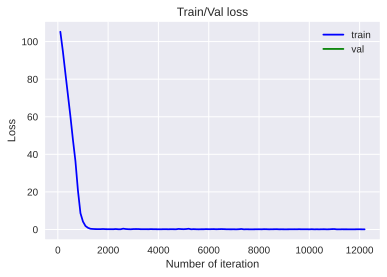

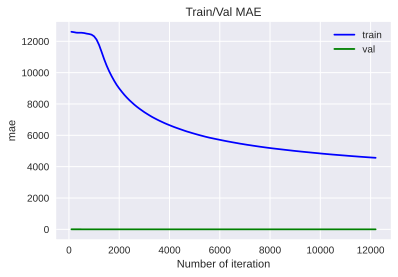

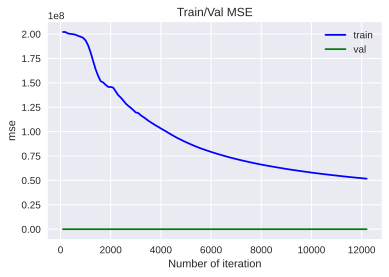

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

 **Prediction**

In [ ]:
_ = load_checkpoint('./cnn_w2v_best_checkpoint', model_w2v, optimizer)

mse, mae, test_loss, loss_arr = make_prediction(model_w2v, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

Loading checkpoint './cnn_w2v_best_checkpoint'
Loaded checkpoint './cnn_w2v_best_checkpoint' from iteration 7799
MSE:  0.05705
MAE:  0.0891
LOSS:  0.22821


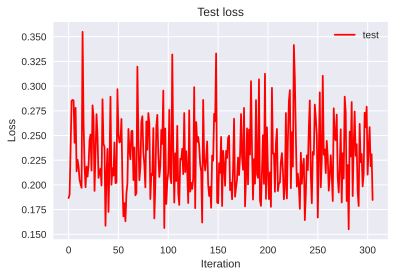

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

Freesed embedding(word2vec) layer works well. Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***: 

MSE:  0.05705  
MAE:  0.0891  
LOSS:  0.22821  


### **Do not freeze**

**Training**

In [ ]:
model_w2v_no_freeze = SalaryPredictor(freezed=False).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_w2v_no_freeze.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_w2v_no_freeze, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_w2v_no_freeze_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 100.32771
VAL  RESULTS:
Iteration: 99  Mean square error: 25.37306  Mean absolute error: 2.51416 
Saving model and optimizer state at iteration 99 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 88.62249
VAL  RESULTS:
Iteration: 199  Mean square error: 22.51392  Mean absolute error: 2.36495 
Saving model and optimizer state at iteration 199 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 73.93312
VAL  RESULTS:
Iteration: 299  Mean square error: 19.40273  Mean absolute error: 2.19105 
Saving model and optimizer state at iteration 299 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 59.86103
VAL  RESULTS:
Iteration: 399  Mean square error: 15.31962  Mean absolute error: 1.92886 
Saving model and optimizer state at iteration 399 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 40.58221
VAL  RESULTS:
Iteration: 499  Mean square error: 10.24462  Mean absolute error: 1.56874 
Saving model and optimizer state at iteration 499 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.26853
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.78182  Mean absolute error: 0.39882 
Saving model and optimizer state at iteration 1299 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 0.17253
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.75944  Mean absolute error: 0.39549 
Saving model and optimizer state at iteration 1399 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 0.40623
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.60426  Mean absolute error: 0.34689 
Saving model and optimizer state at iteration 1499 to ./cnn_w2v_no_freeze_best_checkpoint
train_loss 0.13555
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.65102  Mean absolute error: 0.35966 
train_loss 0.43664
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.73575  Mean absolute error: 0.38756 
train_loss 0.45262
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.66077  Mean absolute error: 0.36364 
train_loss 0.85214
VAL  RESULTS:
Iteration: 1899  Mean square error: 0.75129  Mean

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.24312
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.72927  Mean absolute error: 0.39818 
train_loss 0.37437
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.68993  Mean absolute error: 0.38378 
train_loss 0.17424
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.76623  Mean absolute error: 0.41087 
train_loss 0.27261
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.73017  Mean absolute error: 0.39998 
train_loss 0.34567
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.91548  Mean absolute error: 0.44735 
train_loss 0.18499
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.96194  Mean absolute error: 0.46376 
train_loss 0.47102
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.90923  Mean absolute error: 0.44791 
train_loss 0.15192
VAL  RESULTS:
Iteration: 3199  Mean square error: 0.95714  Mean absolute error: 0.46244 
train_loss 0.12219
VAL  RESULTS:
Iteration: 3299  Mean square error: 0.73428  Mean absolute error: 0.40211 
train_loss 0.13297
VAL  RESU

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.18487
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.98854  Mean absolute error: 0.47178 
train_loss 0.14692
VAL  RESULTS:
Iteration: 3799  Mean square error: 1.05283  Mean absolute error: 0.48644 
train_loss 0.43642
VAL  RESULTS:
Iteration: 3899  Mean square error: 1.24423  Mean absolute error: 0.53241 
train_loss 0.17722
VAL  RESULTS:
Iteration: 3999  Mean square error: 1.15794  Mean absolute error: 0.51095 
train_loss 0.56823
VAL  RESULTS:
Iteration: 4099  Mean square error: 1.02133  Mean absolute error: 0.47496 
train_loss 0.16773
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.9752  Mean absolute error: 0.4579 
train_loss 0.09003
VAL  RESULTS:
Iteration: 4299  Mean square error: 1.08921  Mean absolute error: 0.48983 
train_loss 0.10543
VAL  RESULTS:
Iteration: 4399  Mean square error: 1.16226  Mean absolute error: 0.50557 
train_loss 0.08597
VAL  RESULTS:
Iteration: 4499  Mean square error: 1.20838  Mean absolute error: 0.51912 
train_loss 0.10513
VAL  RESULT

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.18474
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.96606  Mean absolute error: 0.4599 
train_loss 0.37901
VAL  RESULTS:
Iteration: 4999  Mean square error: 1.20001  Mean absolute error: 0.51699 
train_loss 0.09752
VAL  RESULTS:
Iteration: 5099  Mean square error: 1.05387  Mean absolute error: 0.48347 
train_loss 0.13368
VAL  RESULTS:
Iteration: 5199  Mean square error: 1.19361  Mean absolute error: 0.51506 
train_loss 0.32982
VAL  RESULTS:
Iteration: 5299  Mean square error: 1.12378  Mean absolute error: 0.49875 
train_loss 0.07542
VAL  RESULTS:
Iteration: 5399  Mean square error: 1.05239  Mean absolute error: 0.48282 
train_loss 0.07051
VAL  RESULTS:
Iteration: 5499  Mean square error: 1.08766  Mean absolute error: 0.48914 
train_loss 0.29655
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.92837  Mean absolute error: 0.44762 
train_loss 0.13993
VAL  RESULTS:
Iteration: 5699  Mean square error: 1.24132  Mean absolute error: 0.52583 
train_loss 0.3034
VAL  RESULT

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13857
VAL  RESULTS:
Iteration: 6199  Mean square error: 1.01636  Mean absolute error: 0.47258 
train_loss 0.14583
VAL  RESULTS:
Iteration: 6299  Mean square error: 1.10369  Mean absolute error: 0.4956 
train_loss 0.08455
VAL  RESULTS:
Iteration: 6399  Mean square error: 1.02951  Mean absolute error: 0.47761 
train_loss 0.09294
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.9751  Mean absolute error: 0.46171 
train_loss 0.16274
VAL  RESULTS:
Iteration: 6599  Mean square error: 1.10086  Mean absolute error: 0.4889 
train_loss 0.14369
VAL  RESULTS:
Iteration: 6699  Mean square error: 1.06229  Mean absolute error: 0.48403 
train_loss 0.08975
VAL  RESULTS:
Iteration: 6799  Mean square error: 1.12315  Mean absolute error: 0.499 
train_loss 0.07584
VAL  RESULTS:
Iteration: 6899  Mean square error: 1.01872  Mean absolute error: 0.47519 
train_loss 0.11224
VAL  RESULTS:
Iteration: 6999  Mean square error: 1.23842  Mean absolute error: 0.52754 
train_loss 0.14434
VAL  RESULTS:


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09265
VAL  RESULTS:
Iteration: 7399  Mean square error: 1.00262  Mean absolute error: 0.47389 
train_loss 0.05748
VAL  RESULTS:
Iteration: 7499  Mean square error: 1.07413  Mean absolute error: 0.48931 
train_loss 0.2033
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.97353  Mean absolute error: 0.46432 
train_loss 0.11664
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.97262  Mean absolute error: 0.46456 
train_loss 0.08204
VAL  RESULTS:
Iteration: 7799  Mean square error: 1.19259  Mean absolute error: 0.51661 
train_loss 0.21426
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.98925  Mean absolute error: 0.47084 
train_loss 0.08979
VAL  RESULTS:
Iteration: 7999  Mean square error: 1.04644  Mean absolute error: 0.48554 
train_loss 0.07776
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.98144  Mean absolute error: 0.46975 
train_loss 0.11998
VAL  RESULTS:
Iteration: 8199  Mean square error: 0.89928  Mean absolute error: 0.44775 
train_loss 0.08355
VAL  RESUL

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09527
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.94993  Mean absolute error: 0.46355 
train_loss 0.13332
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.99201  Mean absolute error: 0.47131 
train_loss 0.0931
VAL  RESULTS:
Iteration: 8799  Mean square error: 1.02902  Mean absolute error: 0.48396 
train_loss 0.12175
VAL  RESULTS:
Iteration: 8899  Mean square error: 1.06161  Mean absolute error: 0.4914 
train_loss 0.09149
VAL  RESULTS:
Iteration: 8999  Mean square error: 1.09048  Mean absolute error: 0.49944 
train_loss 0.08572
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.97927  Mean absolute error: 0.47158 
train_loss 0.12166
VAL  RESULTS:
Iteration: 9199  Mean square error: 1.22986  Mean absolute error: 0.53253 
train_loss 0.07653
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.9344  Mean absolute error: 0.45583 
train_loss 0.08442
VAL  RESULTS:
Iteration: 9399  Mean square error: 1.0115  Mean absolute error: 0.47743 
train_loss 0.10397
VAL  RESULTS:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07328
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.82108  Mean absolute error: 0.43151 
train_loss 0.1137
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.92988  Mean absolute error: 0.45697 
train_loss 0.06962
VAL  RESULTS:
Iteration: 9999  Mean square error: 1.00685  Mean absolute error: 0.48087 
train_loss 0.14971
VAL  RESULTS:
Iteration: 10099  Mean square error: 1.04571  Mean absolute error: 0.48921 
train_loss 0.0916
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.95897  Mean absolute error: 0.46836 
train_loss 0.11515
VAL  RESULTS:
Iteration: 10299  Mean square error: 1.04818  Mean absolute error: 0.48851 
train_loss 0.08478
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.8526  Mean absolute error: 0.44032 
train_loss 0.10475
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.86002  Mean absolute error: 0.4416 
train_loss 0.12611
VAL  RESULTS:
Iteration: 10599  Mean square error: 0.93418  Mean absolute error: 0.46186 
train_loss 0.07616
VAL  RE

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06957
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.84666  Mean absolute error: 0.43786 
train_loss 0.11286
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.69977  Mean absolute error: 0.39693 
train_loss 0.0607
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.75216  Mean absolute error: 0.41114 
train_loss 0.08356
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.76546  Mean absolute error: 0.41682 
train_loss 0.06742
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.74113  Mean absolute error: 0.40839 
train_loss 0.09256
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.83493  Mean absolute error: 0.43646 
train_loss 0.11203
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.79681  Mean absolute error: 0.42515 
train_loss 0.08247
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.67944  Mean absolute error: 0.39096 
train_loss 0.05549
VAL  RESULTS:
Iteration: 11899  Mean square error: 0.77714  Mean absolute error: 0.41923 
train_loss 0.05983
V

**Save model**

In [ ]:
model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_w2v_no_freeze_regr' 

lr=1e-3
save_checkpoint(model_w2v_no_freeze, optimizer, lr, EPOCHS, model_path)

Saving model and optimizer state at iteration 10 to /content/drive/My Drive/IAD/NLP_Lab/models/cnn_w2v_no_freeze_regr


**Visualization**

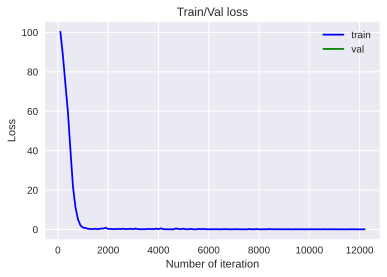

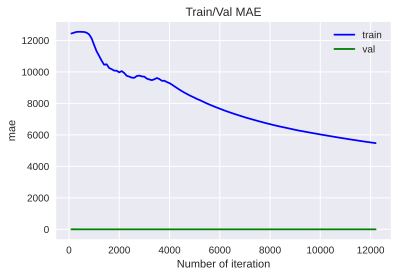

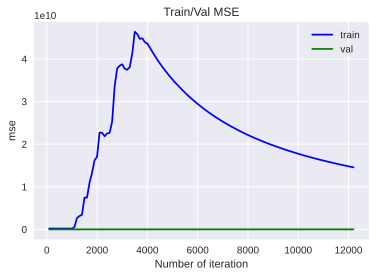

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**


In [ ]:
_ = load_checkpoint('./cnn_w2v_no_freeze_best_checkpoint', model_w2v_no_freeze, optimizer)

mse, mae, test_loss, loss_arr = make_prediction(model_w2v_no_freeze, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5)) 

Loading checkpoint './cnn_w2v_no_freeze_best_checkpoint'
Loaded checkpoint './cnn_w2v_no_freeze_best_checkpoint' from iteration 2199
MSE:  0.58204
MAE:  0.34345
LOSS:  2.32817


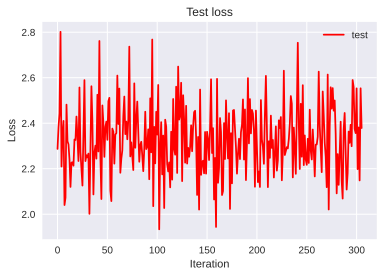

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

* Metrics jump a lot in the initial training of the model, however, at about the 4th epoch, metrics are regularized and decrease.
Not freezed embedding(word2vec) layer works not so well. The predictive ability of this model is very good. Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***: 

MSE:  0.05705  
MAE:  0.0891  
LOSS:  0.22821  


## **GloVe**

In [ ]:
corpus_glove = api.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
len(corpus_glove.vocab)

1193514

In [ ]:
weights_matrix = set_weights(corpus_glove, 200)

**Model**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, freezed=True):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights_matrix, freeze=freezed)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(200, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(200, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

### **Freeze**

**Training**

In [ ]:
model_glv = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_glv.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_glv, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_glv_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 98.0235
VAL  RESULTS:
Iteration: 99  Mean square error: 25.24975  Mean absolute error: 2.50875 
Saving model and optimizer state at iteration 99 to ./cnn_glv_best_checkpoint
train_loss 85.80019
VAL  RESULTS:
Iteration: 199  Mean square error: 23.3334  Mean absolute error: 2.41184 
Saving model and optimizer state at iteration 199 to ./cnn_glv_best_checkpoint
train_loss 70.09106
VAL  RESULTS:
Iteration: 299  Mean square error: 18.16151  Mean absolute error: 2.12683 
Saving model and optimizer state at iteration 299 to ./cnn_glv_best_checkpoint
train_loss 54.4319
VAL  RESULTS:
Iteration: 399  Mean square error: 15.16648  Mean absolute error: 1.94088 
Saving model and optimizer state at iteration 399 to ./cnn_glv_best_checkpoint
train_loss 39.8447
VAL  RESULTS:
Iteration: 499  Mean square error: 8.73628  Mean absolute error: 1.45587 
Saving model and optimizer state at iteration 499 to ./cnn_glv_best_checkpoint
train_loss 25.6317
VAL  RESULTS:
Iteration: 599  Mean square error:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.72973
VAL  RESULTS:
Iteration: 1299  Mean square error: 1.30273  Mean absolute error: 0.48908 
train_loss 1.103
VAL  RESULTS:
Iteration: 1399  Mean square error: 1.17087  Mean absolute error: 0.45624 
train_loss 0.71396
VAL  RESULTS:
Iteration: 1499  Mean square error: 1.35455  Mean absolute error: 0.49457 
train_loss 0.73722
VAL  RESULTS:
Iteration: 1599  Mean square error: 1.05667  Mean absolute error: 0.44215 
Saving model and optimizer state at iteration 1599 to ./cnn_glv_best_checkpoint
train_loss 0.63958
VAL  RESULTS:
Iteration: 1699  Mean square error: 1.30563  Mean absolute error: 0.50299 
train_loss 0.42047
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.9935  Mean absolute error: 0.42899 
Saving model and optimizer state at iteration 1799 to ./cnn_glv_best_checkpoint
train_loss 0.38073
VAL  RESULTS:
Iteration: 1899  Mean square error: 1.13653  Mean absolute error: 0.43517 
train_loss 0.45048
VAL  RESULTS:
Iteration: 1999  Mean square error: 0.90482  Mean abso

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.29196
VAL  RESULTS:
Iteration: 2499  Mean square error: 1.53406  Mean absolute error: 0.53953 
train_loss 0.37493
VAL  RESULTS:
Iteration: 2599  Mean square error: 1.01506  Mean absolute error: 0.39824 
train_loss 0.33857
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.95647  Mean absolute error: 0.38706 
train_loss 0.24924
VAL  RESULTS:
Iteration: 2799  Mean square error: 1.27135  Mean absolute error: 0.48015 
train_loss 0.37052
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.81116  Mean absolute error: 0.34863 
Saving model and optimizer state at iteration 2899 to ./cnn_glv_best_checkpoint
train_loss 0.23148
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.72437  Mean absolute error: 0.33194 
Saving model and optimizer state at iteration 2999 to ./cnn_glv_best_checkpoint
train_loss 0.64702
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.75466  Mean absolute error: 0.33384 
train_loss 0.15602
VAL  RESULTS:
Iteration: 3199  Mean square error: 1.0458  Mean ab

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.23733
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.81341  Mean absolute error: 0.35 
train_loss 0.33763
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.95443  Mean absolute error: 0.39078 
train_loss 0.18671
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.76023  Mean absolute error: 0.32446 
train_loss 0.15784
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.74386  Mean absolute error: 0.33883 
train_loss 0.2887
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.56508  Mean absolute error: 0.27468 
Saving model and optimizer state at iteration 4099 to ./cnn_glv_best_checkpoint
train_loss 0.16213
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.5503  Mean absolute error: 0.26697 
Saving model and optimizer state at iteration 4199 to ./cnn_glv_best_checkpoint
train_loss 0.26888
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.55161  Mean absolute error: 0.27184 
train_loss 0.25966
VAL  RESULTS:
Iteration: 4399  Mean square error: 0.56568  Mean absolu

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.15371
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.54879  Mean absolute error: 0.27257 
Saving model and optimizer state at iteration 4899 to ./cnn_glv_best_checkpoint
train_loss 0.15475
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.56187  Mean absolute error: 0.27916 
train_loss 0.17662
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.64245  Mean absolute error: 0.29388 
train_loss 0.19532
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.56034  Mean absolute error: 0.27402 
train_loss 0.18735
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.55836  Mean absolute error: 0.27485 
train_loss 0.19298
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.57297  Mean absolute error: 0.282 
train_loss 0.17448
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.44939  Mean absolute error: 0.24936 
Saving model and optimizer state at iteration 5499 to ./cnn_glv_best_checkpoint
train_loss 0.20707
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.53205  Mean abs

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.12693
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.40406  Mean absolute error: 0.24203 
train_loss 0.15038
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.34608  Mean absolute error: 0.22766 
Saving model and optimizer state at iteration 6299 to ./cnn_glv_best_checkpoint
train_loss 0.15564
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.41001  Mean absolute error: 0.24272 
train_loss 0.15473
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.41745  Mean absolute error: 0.2526 
train_loss 0.18208
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.34649  Mean absolute error: 0.22459 
train_loss 0.17295
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.39309  Mean absolute error: 0.24114 
train_loss 0.18272
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.36768  Mean absolute error: 0.2306 
train_loss 0.13808
VAL  RESULTS:
Iteration: 6899  Mean square error: 0.35838  Mean absolute error: 0.2379 
train_loss 0.11949
VAL  RESULTS:
Iteration: 6999  Mean squa

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.12421
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.2754  Mean absolute error: 0.20926 
Saving model and optimizer state at iteration 7399 to ./cnn_glv_best_checkpoint
train_loss 0.18254
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.31852  Mean absolute error: 0.2165 
train_loss 0.12901
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.35282  Mean absolute error: 0.22167 
train_loss 0.11338
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.33527  Mean absolute error: 0.21471 
train_loss 0.17021
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.30195  Mean absolute error: 0.20479 
train_loss 0.11143
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.30726  Mean absolute error: 0.20671 
train_loss 0.15581
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.34041  Mean absolute error: 0.21365 
train_loss 0.09642
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.24524  Mean absolute error: 0.1919 
Saving model and optimizer state at iteration 8099 to ./cnn

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.11099
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.25879  Mean absolute error: 0.19196 
train_loss 0.12698
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.20156  Mean absolute error: 0.1792 
train_loss 0.14892
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.28525  Mean absolute error: 0.20286 
train_loss 0.08265
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.17687  Mean absolute error: 0.16956 
Saving model and optimizer state at iteration 8899 to ./cnn_glv_best_checkpoint
train_loss 0.18676
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.18962  Mean absolute error: 0.16504 
train_loss 0.09575
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.25634  Mean absolute error: 0.19392 
train_loss 0.08935
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.17175  Mean absolute error: 0.15995 
Saving model and optimizer state at iteration 9199 to ./cnn_glv_best_checkpoint
train_loss 0.16739
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.24856  Mean ab

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.08462
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.1804  Mean absolute error: 0.16819 
train_loss 0.07489
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.15102  Mean absolute error: 0.15622 
train_loss 0.11261
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.14697  Mean absolute error: 0.15583 
train_loss 0.09058
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.15561  Mean absolute error: 0.16077 
train_loss 0.12106
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.10561  Mean absolute error: 0.13172 
Saving model and optimizer state at iteration 10199 to ./cnn_glv_best_checkpoint
train_loss 0.12641
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.11414  Mean absolute error: 0.13615 
train_loss 0.12431
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.12874  Mean absolute error: 0.14771 
train_loss 0.10309
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.14116  Mean absolute error: 0.15458 
train_loss 0.09074
VAL  RESULTS:
Iteration: 10599  

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10735
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.15405  Mean absolute error: 0.16545 
train_loss 0.10427
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.12944  Mean absolute error: 0.1499 
train_loss 0.0841
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.12874  Mean absolute error: 0.14873 
train_loss 0.06824
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.09196  Mean absolute error: 0.12446 
train_loss 0.08806
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.06082  Mean absolute error: 0.0981 
Saving model and optimizer state at iteration 11499 to ./cnn_glv_best_checkpoint
train_loss 0.11882
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.12844  Mean absolute error: 0.1508 
train_loss 0.07427
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.09132  Mean absolute error: 0.12382 
train_loss 0.11654
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.07555  Mean absolute error: 0.11171 
train_loss 0.10662
VAL  RESULTS:
Iteration: 11899  

**Save model**

In [ ]:
model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_glv_regr' 

lr=1e-3
save_checkpoint(model_glv, optimizer, lr, EPOCHS, model_path)

Saving model and optimizer state at iteration 10 to /content/drive/My Drive/IAD/NLP_Lab/models/cnn_glv_regr


**Visualization**

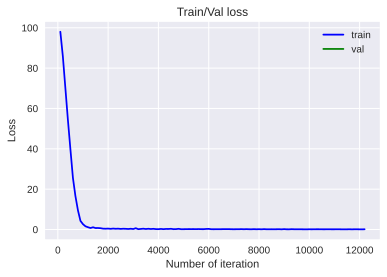

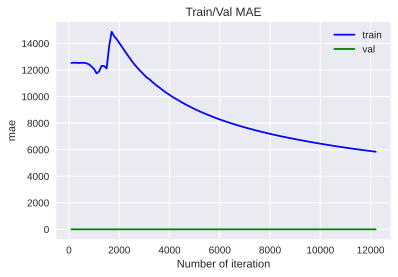

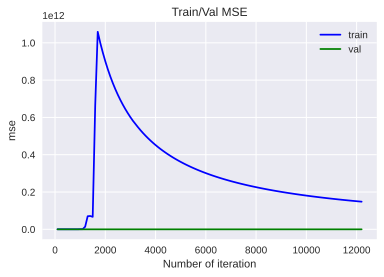

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_glv_best_checkpoint', model_glv, optimizer)

mse, mae, test_loss, loss_arr = make_prediction(model_glv, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5)) 

Loading checkpoint './cnn_glv_best_checkpoint'
Loaded checkpoint './cnn_glv_best_checkpoint' from iteration 11499
MSE:  0.06061
MAE:  0.09801
LOSS:  0.24246


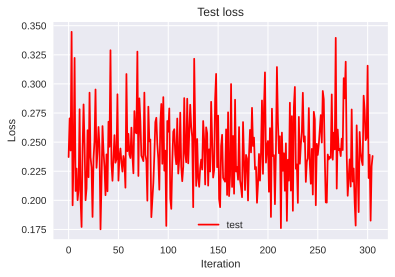

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion** 

Freesed embedding(glove) layer works well. Metrics decrease smoothly, but loss of the model is slightly higher than the rest. The predictive ability of this model is very good, despite the fact that this model rained just 3 epochs.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***:   
MSE:  0.06061  
MAE:  0.09801  
LOSS:  0.24246  


### **Do not freeze**

**Training**

In [ ]:
model_glv_no_freeze = SalaryPredictor(freezed=False).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_glv_no_freeze.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_glv_no_freeze, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_glv_no_freeze_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 82.83958
VAL  RESULTS:
Iteration: 99  Mean square error: 22.1365  Mean absolute error: 2.34825 
Saving model and optimizer state at iteration 99 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 67.13165
VAL  RESULTS:
Iteration: 199  Mean square error: 19.50692  Mean absolute error: 2.2046 
Saving model and optimizer state at iteration 199 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 49.45146
VAL  RESULTS:
Iteration: 299  Mean square error: 15.6146  Mean absolute error: 1.97158 
Saving model and optimizer state at iteration 299 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 33.04973
VAL  RESULTS:
Iteration: 399  Mean square error: 12.18907  Mean absolute error: 1.74149 
Saving model and optimizer state at iteration 399 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 18.3008
VAL  RESULTS:
Iteration: 499  Mean square error: 8.22312  Mean absolute error: 1.42869 
Saving model and optimizer state at iteration 499 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 8.6330

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.17576
VAL  RESULTS:
Iteration: 1299  Mean square error: 1.88668  Mean absolute error: 0.67777 
Saving model and optimizer state at iteration 1299 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.13619
VAL  RESULTS:
Iteration: 1399  Mean square error: 1.95061  Mean absolute error: 0.68844 
train_loss 0.64604
VAL  RESULTS:
Iteration: 1499  Mean square error: 1.82989  Mean absolute error: 0.66437 
Saving model and optimizer state at iteration 1499 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.52322
VAL  RESULTS:
Iteration: 1599  Mean square error: 2.12904  Mean absolute error: 0.72154 
train_loss 0.1575
VAL  RESULTS:
Iteration: 1699  Mean square error: 2.03741  Mean absolute error: 0.70488 
train_loss 0.75962
VAL  RESULTS:
Iteration: 1799  Mean square error: 1.87088  Mean absolute error: 0.67535 
train_loss 0.10911
VAL  RESULTS:
Iteration: 1899  Mean square error: 1.6979  Mean absolute error: 0.64043 
Saving model and optimizer state at iteration 1899 to ./cnn_glv_no

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.28398
VAL  RESULTS:
Iteration: 2499  Mean square error: 1.84522  Mean absolute error: 0.66684 
train_loss 0.30669
VAL  RESULTS:
Iteration: 2599  Mean square error: 1.81397  Mean absolute error: 0.66216 
train_loss 0.30977
VAL  RESULTS:
Iteration: 2699  Mean square error: 1.66435  Mean absolute error: 0.63174 
train_loss 0.18331
VAL  RESULTS:
Iteration: 2799  Mean square error: 1.21446  Mean absolute error: 0.52984 
Saving model and optimizer state at iteration 2799 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.50638
VAL  RESULTS:
Iteration: 2899  Mean square error: 1.66168  Mean absolute error: 0.63129 
train_loss 0.14308
VAL  RESULTS:
Iteration: 2999  Mean square error: 1.65123  Mean absolute error: 0.63118 
train_loss 0.14986
VAL  RESULTS:
Iteration: 3099  Mean square error: 1.52447  Mean absolute error: 0.60226 
train_loss 0.33303
VAL  RESULTS:
Iteration: 3199  Mean square error: 1.73833  Mean absolute error: 0.64728 
train_loss 0.2384
VAL  RESULTS:
Iteration: 329

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.27156
VAL  RESULTS:
Iteration: 3699  Mean square error: 1.41181  Mean absolute error: 0.57681 
train_loss 0.10069
VAL  RESULTS:
Iteration: 3799  Mean square error: 1.41483  Mean absolute error: 0.58074 
train_loss 0.23051
VAL  RESULTS:
Iteration: 3899  Mean square error: 1.37048  Mean absolute error: 0.57091 
train_loss 0.23563
VAL  RESULTS:
Iteration: 3999  Mean square error: 1.57308  Mean absolute error: 0.6141 
train_loss 0.38461
VAL  RESULTS:
Iteration: 4099  Mean square error: 1.62609  Mean absolute error: 0.62737 
train_loss 0.12946
VAL  RESULTS:
Iteration: 4199  Mean square error: 1.54063  Mean absolute error: 0.6084 
train_loss 0.0906
VAL  RESULTS:
Iteration: 4299  Mean square error: 1.21502  Mean absolute error: 0.53193 
train_loss 0.13883
VAL  RESULTS:
Iteration: 4399  Mean square error: 1.48238  Mean absolute error: 0.59739 
train_loss 0.28926
VAL  RESULTS:
Iteration: 4499  Mean square error: 1.30963  Mean absolute error: 0.55276 
train_loss 0.6269
VAL  RESULTS:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.38499
VAL  RESULTS:
Iteration: 4899  Mean square error: 1.45428  Mean absolute error: 0.58967 
train_loss 0.08165
VAL  RESULTS:
Iteration: 4999  Mean square error: 1.21481  Mean absolute error: 0.53769 
train_loss 0.10542
VAL  RESULTS:
Iteration: 5099  Mean square error: 1.35879  Mean absolute error: 0.572 
train_loss 0.07203
VAL  RESULTS:
Iteration: 5199  Mean square error: 1.24323  Mean absolute error: 0.5426 
train_loss 0.19081
VAL  RESULTS:
Iteration: 5299  Mean square error: 1.2427  Mean absolute error: 0.5411 
train_loss 0.15248
VAL  RESULTS:
Iteration: 5399  Mean square error: 1.0868  Mean absolute error: 0.49825 
Saving model and optimizer state at iteration 5399 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.09818
VAL  RESULTS:
Iteration: 5499  Mean square error: 1.26016  Mean absolute error: 0.54788 
train_loss 0.19656
VAL  RESULTS:
Iteration: 5599  Mean square error: 1.35052  Mean absolute error: 0.56976 
train_loss 0.10131
VAL  RESULTS:
Iteration: 5699  Me

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.12498
VAL  RESULTS:
Iteration: 6199  Mean square error: 1.16385  Mean absolute error: 0.51777 
train_loss 0.14916
VAL  RESULTS:
Iteration: 6299  Mean square error: 1.17773  Mean absolute error: 0.52766 
train_loss 0.09479
VAL  RESULTS:
Iteration: 6399  Mean square error: 1.21699  Mean absolute error: 0.53451 
train_loss 0.10138
VAL  RESULTS:
Iteration: 6499  Mean square error: 1.09002  Mean absolute error: 0.50234 
train_loss 0.09064
VAL  RESULTS:
Iteration: 6599  Mean square error: 1.05857  Mean absolute error: 0.49747 
Saving model and optimizer state at iteration 6599 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.21413
VAL  RESULTS:
Iteration: 6699  Mean square error: 1.0248  Mean absolute error: 0.48987 
Saving model and optimizer state at iteration 6699 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.10054
VAL  RESULTS:
Iteration: 6799  Mean square error: 1.10745  Mean absolute error: 0.51201 
train_loss 0.09684
VAL  RESULTS:
Iteration: 6899  Mean square err

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.0811
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.95411  Mean absolute error: 0.46828 
Saving model and optimizer state at iteration 7399 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.0834
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.95889  Mean absolute error: 0.47389 
train_loss 0.15704
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.96519  Mean absolute error: 0.47379 
train_loss 0.12821
VAL  RESULTS:
Iteration: 7699  Mean square error: 1.02863  Mean absolute error: 0.48885 
train_loss 0.21236
VAL  RESULTS:
Iteration: 7799  Mean square error: 1.01121  Mean absolute error: 0.48538 
train_loss 0.14974
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.96677  Mean absolute error: 0.4749 
train_loss 0.10525
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.81442  Mean absolute error: 0.43288 
Saving model and optimizer state at iteration 7999 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.07659
VAL  RESULTS:
Iteration: 8099  Mean square error

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09012
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.92025  Mean absolute error: 0.46369 
train_loss 0.08782
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.89161  Mean absolute error: 0.45483 
train_loss 0.28909
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.86295  Mean absolute error: 0.44741 
train_loss 0.14512
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.70694  Mean absolute error: 0.40438 
Saving model and optimizer state at iteration 8899 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.08871
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.71969  Mean absolute error: 0.40669 
train_loss 0.0817
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.75741  Mean absolute error: 0.4172 
train_loss 0.07763
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.75353  Mean absolute error: 0.4145 
train_loss 0.06889
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.7121  Mean absolute error: 0.40426 
train_loss 0.21311
VAL  RESULTS:
Iteration: 9399  

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.21133
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.68132  Mean absolute error: 0.39419 
Saving model and optimizer state at iteration 9799 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.06786
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.59645  Mean absolute error: 0.36811 
Saving model and optimizer state at iteration 9899 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.18557
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.636  Mean absolute error: 0.37997 
train_loss 0.11447
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.71898  Mean absolute error: 0.408 
train_loss 0.1281
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.57746  Mean absolute error: 0.35421 
Saving model and optimizer state at iteration 10199 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.08448
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.64842  Mean absolute error: 0.38428 
train_loss 0.07945
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.56746  Mean

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.11241
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.53212  Mean absolute error: 0.34689 
train_loss 0.14743
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.49802  Mean absolute error: 0.33021 
Saving model and optimizer state at iteration 11199 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.17759
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.55057  Mean absolute error: 0.35197 
train_loss 0.06254
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.49624  Mean absolute error: 0.33049 
Saving model and optimizer state at iteration 11399 to ./cnn_glv_no_freeze_best_checkpoint
train_loss 0.0728
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.49912  Mean absolute error: 0.33409 
train_loss 0.12015
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.5049  Mean absolute error: 0.33215 
train_loss 0.09213
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.40844  Mean absolute error: 0.29424 
Saving model and optimizer state at iteration 11699 to ./

**Save model**

In [ ]:
model_path = '/content/drive/My Drive/IAD/NLP_Lab/models/cnn_glv_no_freeze_regr' 

lr=1e-3
save_checkpoint(model_glv_no_freeze, optimizer, lr, EPOCHS, model_path)

Saving model and optimizer state at iteration 10 to /content/drive/My Drive/IAD/NLP_Lab/models/cnn_glv_no_freeze_regr


**Visualization**

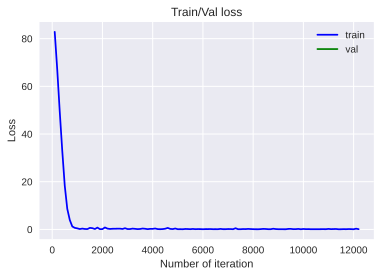

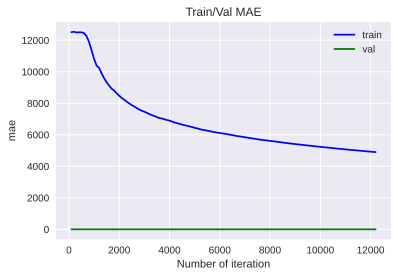

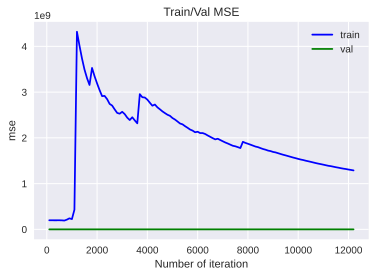

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**


In [ ]:
_ = load_checkpoint('./cnn_glv_no_freeze_best_checkpoint', model_glv_no_freeze, optimizer)

mse, mae, test_loss, loss_arr = make_prediction(model_glv_no_freeze, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5)) 

Loading checkpoint './cnn_glv_no_freeze_best_checkpoint'
Loaded checkpoint './cnn_glv_no_freeze_best_checkpoint' from iteration 12199
MSE:  0.39391
MAE:  0.28766
LOSS:  1.57564


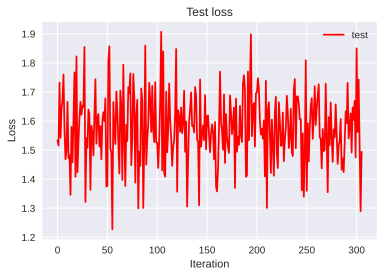

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

* Metrics jump a lot in the initial training of the model, especially MSE, but at about the 4th epoch, metrics are regularized and reduced. You can see that the metrics are also higher than expected.
* Not freezed embedding(word2vec) layer works not so well. The predictive ability of this model is very good. Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***: 

MSE:  0.39391  
MAE:  0.28766  
LOSS:  1.57564  


## **General conclusion №3**


If we compare embeddings, initialized randomly and pre-trained embeddings with frozen weights, then they worked out for this task in almost the same way.
It is worth noting that Word2Vec with frozen weights coped with the task best of all. The Glove embedding was also tested, but it coped with the task slightly worse. When we unfreeze weights and try to stretch them for our task, the model behaves erratically, we need longer training and optimization.


# **🚩 4. Замена сверточных слоев на рекуррентные**

* Замена сверточных слоев рекуррентными LSTM/GRU.
* Эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью


### **1) GRU**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_gru = nn.GRU(hid_size,hid_size, batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.ReLU()
        
        self.description_gru = nn.GRU(hid_size,hid_size, batch_first=True)
        self.dr2 = nn.Dropout(p=0.25)
        self.af2 = nn.ReLU()

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title'])
        output, hidden_title = self.title_gru(title_embeddings)     
        hidden_title = torch.cat([hidden_title[i,:, :] for i in range(hidden_title.shape[0])], dim=1)
        out_title = self.dr1(hidden_title)
        out_title = self.af1(out_title)

        description_embeddings = self.embedder(batch['FullDescription'])
        output, hidden_description = self.title_gru(description_embeddings)
        hidden_description = torch.cat([hidden_description[i,:, :] for i in range(hidden_description.shape[0])], dim=1)
        out_description = self.dr2(hidden_description)
        out_description = self.af2(out_description)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [out_title, out_description, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_gru = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_gru.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_gru, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./gru_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 94.00748
VAL  RESULTS:
Iteration: 99  Mean square error: 26.03197  Mean absolute error: 2.54806 
Saving model and optimizer state at iteration 99 to ./gru_best_checkpoint
train_loss 80.69044
VAL  RESULTS:
Iteration: 199  Mean square error: 23.66462  Mean absolute error: 2.42926 
Saving model and optimizer state at iteration 199 to ./gru_best_checkpoint
train_loss 66.38394
VAL  RESULTS:
Iteration: 299  Mean square error: 21.21854  Mean absolute error: 2.30005 
Saving model and optimizer state at iteration 299 to ./gru_best_checkpoint
train_loss 49.3088
VAL  RESULTS:
Iteration: 399  Mean square error: 17.63616  Mean absolute error: 2.09661 
Saving model and optimizer state at iteration 399 to ./gru_best_checkpoint
train_loss 34.52466
VAL  RESULTS:
Iteration: 499  Mean square error: 14.21217  Mean absolute error: 1.88165 
Saving model and optimizer state at iteration 499 to ./gru_best_checkpoint
train_loss 22.30434
VAL  RESULTS:
Iteration: 599  Mean square error: 10.57102  Mean

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.23495
VAL  RESULTS:
Iteration: 1299  Mean square error: 1.9236  Mean absolute error: 0.68403 
Saving model and optimizer state at iteration 1299 to ./gru_best_checkpoint
train_loss 0.29051
VAL  RESULTS:
Iteration: 1399  Mean square error: 2.81302  Mean absolute error: 0.83053 
train_loss 0.29667
VAL  RESULTS:
Iteration: 1499  Mean square error: 2.55148  Mean absolute error: 0.78999 
train_loss 0.16063
VAL  RESULTS:
Iteration: 1599  Mean square error: 2.41327  Mean absolute error: 0.76812 
train_loss 0.39695
VAL  RESULTS:
Iteration: 1699  Mean square error: 2.48231  Mean absolute error: 0.77908 
train_loss 0.23182
VAL  RESULTS:
Iteration: 1799  Mean square error: 2.30928  Mean absolute error: 0.75043 
train_loss 0.36466
VAL  RESULTS:
Iteration: 1899  Mean square error: 2.53947  Mean absolute error: 0.78793 
train_loss 0.3312
VAL  RESULTS:
Iteration: 1999  Mean square error: 2.48101  Mean absolute error: 0.77873 
train_loss 0.19168
VAL  RESULTS:
Iteration: 2099  Mean square 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.18376
VAL  RESULTS:
Iteration: 2499  Mean square error: 2.25289  Mean absolute error: 0.74203 
train_loss 0.27132
VAL  RESULTS:
Iteration: 2599  Mean square error: 2.82349  Mean absolute error: 0.83217 
train_loss 0.18501
VAL  RESULTS:
Iteration: 2699  Mean square error: 1.9424  Mean absolute error: 0.68752 
train_loss 0.18353
VAL  RESULTS:
Iteration: 2799  Mean square error: 2.59392  Mean absolute error: 0.79695 
train_loss 0.23407
VAL  RESULTS:
Iteration: 2899  Mean square error: 2.1671  Mean absolute error: 0.72717 
train_loss 0.26177
VAL  RESULTS:
Iteration: 2999  Mean square error: 2.2281  Mean absolute error: 0.73761 
train_loss 0.35346
VAL  RESULTS:
Iteration: 3099  Mean square error: 2.2603  Mean absolute error: 0.74311 
train_loss 0.44436
VAL  RESULTS:
Iteration: 3199  Mean square error: 2.38771  Mean absolute error: 0.7644 
train_loss 0.18241
VAL  RESULTS:
Iteration: 3299  Mean square error: 2.33133  Mean absolute error: 0.75573 
train_loss 0.1348
VAL  RESULTS:
I

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.25038
VAL  RESULTS:
Iteration: 3699  Mean square error: 2.45211  Mean absolute error: 0.77586 
train_loss 0.19316
VAL  RESULTS:
Iteration: 3799  Mean square error: 2.13878  Mean absolute error: 0.72298 
train_loss 0.24474
VAL  RESULTS:
Iteration: 3899  Mean square error: 2.20221  Mean absolute error: 0.73441 
train_loss 0.19435
VAL  RESULTS:
Iteration: 3999  Mean square error: 2.2787  Mean absolute error: 0.74814 
train_loss 0.17654
VAL  RESULTS:
Iteration: 4099  Mean square error: 1.89736  Mean absolute error: 0.68042 
Saving model and optimizer state at iteration 4099 to ./gru_best_checkpoint
train_loss 0.23659
VAL  RESULTS:
Iteration: 4199  Mean square error: 2.47585  Mean absolute error: 0.77948 
train_loss 0.13568
VAL  RESULTS:
Iteration: 4299  Mean square error: 2.11847  Mean absolute error: 0.72053 
train_loss 0.16381
VAL  RESULTS:
Iteration: 4399  Mean square error: 2.24936  Mean absolute error: 0.74317 
train_loss 0.137
VAL  RESULTS:
Iteration: 4499  Mean square e

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.17025
VAL  RESULTS:
Iteration: 4899  Mean square error: 2.01355  Mean absolute error: 0.70312 
train_loss 0.18532
VAL  RESULTS:
Iteration: 4999  Mean square error: 2.04492  Mean absolute error: 0.70843 
train_loss 0.31846
VAL  RESULTS:
Iteration: 5099  Mean square error: 1.92325  Mean absolute error: 0.68676 
train_loss 0.06358
VAL  RESULTS:
Iteration: 5199  Mean square error: 1.59467  Mean absolute error: 0.62384 
Saving model and optimizer state at iteration 5199 to ./gru_best_checkpoint
train_loss 0.15374
VAL  RESULTS:
Iteration: 5299  Mean square error: 1.86621  Mean absolute error: 0.67609 
train_loss 0.12499
VAL  RESULTS:
Iteration: 5399  Mean square error: 2.11731  Mean absolute error: 0.72141 
train_loss 0.46798
VAL  RESULTS:
Iteration: 5499  Mean square error: 2.03299  Mean absolute error: 0.70645 
train_loss 0.18839
VAL  RESULTS:
Iteration: 5599  Mean square error: 1.74751  Mean absolute error: 0.65456 
train_loss 0.12829
VAL  RESULTS:
Iteration: 5699  Mean squar

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.21234
VAL  RESULTS:
Iteration: 6199  Mean square error: 1.41194  Mean absolute error: 0.58745 
Saving model and optimizer state at iteration 6199 to ./gru_best_checkpoint
train_loss 0.11209
VAL  RESULTS:
Iteration: 6299  Mean square error: 1.55666  Mean absolute error: 0.61736 
train_loss 0.13516
VAL  RESULTS:
Iteration: 6399  Mean square error: 1.79801  Mean absolute error: 0.66391 
train_loss 0.11572
VAL  RESULTS:
Iteration: 6499  Mean square error: 2.31207  Mean absolute error: 0.75451 
train_loss 0.14297
VAL  RESULTS:
Iteration: 6599  Mean square error: 1.58948  Mean absolute error: 0.62397 
train_loss 0.10236
VAL  RESULTS:
Iteration: 6699  Mean square error: 1.53493  Mean absolute error: 0.61322 
train_loss 0.1223
VAL  RESULTS:
Iteration: 6799  Mean square error: 1.58444  Mean absolute error: 0.6231 
train_loss 0.19009
VAL  RESULTS:
Iteration: 6899  Mean square error: 1.47745  Mean absolute error: 0.60162 
train_loss 0.11425
VAL  RESULTS:
Iteration: 6999  Mean square 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13913
VAL  RESULTS:
Iteration: 7399  Mean square error: 1.44493  Mean absolute error: 0.59466 
train_loss 0.10293
VAL  RESULTS:
Iteration: 7499  Mean square error: 1.70094  Mean absolute error: 0.64616 
train_loss 0.151
VAL  RESULTS:
Iteration: 7599  Mean square error: 1.45986  Mean absolute error: 0.59793 
train_loss 0.15475
VAL  RESULTS:
Iteration: 7699  Mean square error: 1.51576  Mean absolute error: 0.60961 
train_loss 0.18891
VAL  RESULTS:
Iteration: 7799  Mean square error: 1.3712  Mean absolute error: 0.57914 
Saving model and optimizer state at iteration 7799 to ./gru_best_checkpoint
train_loss 0.11576
VAL  RESULTS:
Iteration: 7899  Mean square error: 1.44587  Mean absolute error: 0.5952 
train_loss 0.10914
VAL  RESULTS:
Iteration: 7999  Mean square error: 1.46423  Mean absolute error: 0.59899 
train_loss 0.10053
VAL  RESULTS:
Iteration: 8099  Mean square error: 1.17438  Mean absolute error: 0.5352 
Saving model and optimizer state at iteration 8099 to ./gru_best_

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.1437
VAL  RESULTS:
Iteration: 8599  Mean square error: 1.22957  Mean absolute error: 0.54863 
train_loss 0.12176
VAL  RESULTS:
Iteration: 8699  Mean square error: 1.4156  Mean absolute error: 0.58916 
train_loss 0.17376
VAL  RESULTS:
Iteration: 8799  Mean square error: 1.43799  Mean absolute error: 0.59397 
train_loss 0.20693
VAL  RESULTS:
Iteration: 8899  Mean square error: 1.14521  Mean absolute error: 0.52919 
train_loss 0.13421
VAL  RESULTS:
Iteration: 8999  Mean square error: 1.17555  Mean absolute error: 0.53626 
train_loss 0.10442
VAL  RESULTS:
Iteration: 9099  Mean square error: 1.0964  Mean absolute error: 0.51779 
train_loss 0.09942
VAL  RESULTS:
Iteration: 9199  Mean square error: 1.16727  Mean absolute error: 0.53438 
train_loss 0.09002
VAL  RESULTS:
Iteration: 9299  Mean square error: 1.12173  Mean absolute error: 0.52364 
train_loss 0.11018
VAL  RESULTS:
Iteration: 9399  Mean square error: 0.96304  Mean absolute error: 0.48471 
Saving model and optimizer stat

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10578
VAL  RESULTS:
Iteration: 9799  Mean square error: 1.04199  Mean absolute error: 0.50496 
train_loss 0.17218
VAL  RESULTS:
Iteration: 9899  Mean square error: 1.17974  Mean absolute error: 0.53764 
train_loss 0.12808
VAL  RESULTS:
Iteration: 9999  Mean square error: 1.06987  Mean absolute error: 0.51151 
train_loss 0.11618
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.93543  Mean absolute error: 0.4778 
train_loss 0.08943
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.88614  Mean absolute error: 0.46496 
train_loss 0.11256
VAL  RESULTS:
Iteration: 10299  Mean square error: 1.19315  Mean absolute error: 0.5409 
train_loss 0.12066
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.98535  Mean absolute error: 0.49047 
train_loss 0.1464
VAL  RESULTS:
Iteration: 10499  Mean square error: 1.06499  Mean absolute error: 0.51053 
train_loss 0.20912
VAL  RESULTS:
Iteration: 10599  Mean square error: 0.82027  Mean absolute error: 0.44705 
train_loss 0.08009
VAL  R

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07016
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.9108  Mean absolute error: 0.47174 
train_loss 0.10109
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.88018  Mean absolute error: 0.46335 
train_loss 0.09599
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.84776  Mean absolute error: 0.45474 
train_loss 0.11091
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.79256  Mean absolute error: 0.4395 
Saving model and optimizer state at iteration 11399 to ./gru_best_checkpoint
train_loss 0.09505
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.8363  Mean absolute error: 0.45178 
train_loss 0.08336
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.67847  Mean absolute error: 0.40553 
Saving model and optimizer state at iteration 11599 to ./gru_best_checkpoint
train_loss 0.1012
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.81507  Mean absolute error: 0.44584 
train_loss 0.08283
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.78646  Mean abs

**Visualization**

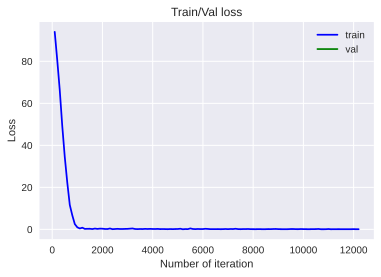

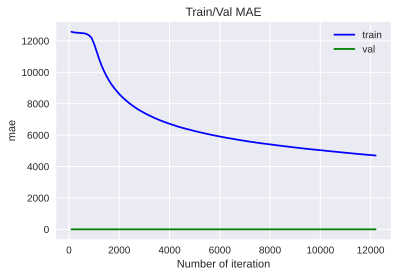

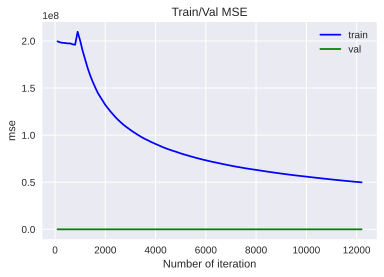

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./gru_best_checkpoint', model_gru, optimizer)

Loading checkpoint './gru_best_checkpoint'
Loaded checkpoint './gru_best_checkpoint' from iteration 11899


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_gru, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.667
MAE:  0.40203
LOSS:  2.668


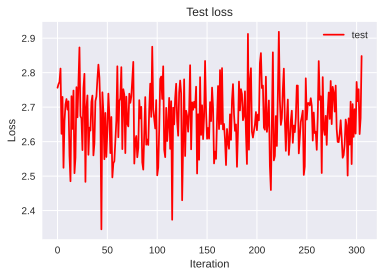

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

The loss is not so good this time. Of course, it reduced but not enough for 10 epochs. Other metrics are smoothly optimized. However, the predictive ability of this model is not so good.  It can bee seen by scores. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score.
* *** Average cross-validation scores ***:  

MSE:  0.667  
MAE:  0.40203  
LOSS:  2.668  


### **2) LSTM**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_lstm = nn.LSTM(hid_size,hid_size, batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.ReLU()
        
        self.description_lstm = nn.LSTM(hid_size,hid_size, batch_first=True)
        self.dr2 = nn.Dropout(p=0.25)
        self.af2 = nn.ReLU()

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        # title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_embeddings = self.embedder(batch['Title'])
        output, (h_n_title, c_n_title) = self.title_lstm(title_embeddings)     
        h_n_title = torch.squeeze(h_n_title, 0)
        out_title = self.dr1(h_n_title)
        out_title = self.af1(out_title)

        # description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_embeddings = self.embedder(batch['FullDescription'])
        output, (h_n_description, c_n_description) = self.title_lstm(description_embeddings)
        h_n_description = torch.squeeze(h_n_description, 0)
        out_description = self.dr2(h_n_description)
        out_description = self.af2(out_description)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [out_title, out_description, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_lstm = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_lstm, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./lstm_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 86.05498
VAL  RESULTS:
Iteration: 99  Mean square error: 24.50425  Mean absolute error: 2.4721 
Saving model and optimizer state at iteration 99 to ./lstm_best_checkpoint
train_loss 71.86203
VAL  RESULTS:
Iteration: 199  Mean square error: 22.77637  Mean absolute error: 2.38336 
Saving model and optimizer state at iteration 199 to ./lstm_best_checkpoint
train_loss 58.04391
VAL  RESULTS:
Iteration: 299  Mean square error: 19.619  Mean absolute error: 2.21178 
Saving model and optimizer state at iteration 299 to ./lstm_best_checkpoint
train_loss 43.67495
VAL  RESULTS:
Iteration: 399  Mean square error: 16.59199  Mean absolute error: 2.03371 
Saving model and optimizer state at iteration 399 to ./lstm_best_checkpoint
train_loss 30.54105
VAL  RESULTS:
Iteration: 499  Mean square error: 14.28363  Mean absolute error: 1.88655 
Saving model and optimizer state at iteration 499 to ./lstm_best_checkpoint
train_loss 19.24859
VAL  RESULTS:
Iteration: 599  Mean square error: 10.4867  Me

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.45772
VAL  RESULTS:
Iteration: 1299  Mean square error: 2.07668  Mean absolute error: 0.71363 
Saving model and optimizer state at iteration 1299 to ./lstm_best_checkpoint
train_loss 0.51687
VAL  RESULTS:
Iteration: 1399  Mean square error: 2.40352  Mean absolute error: 0.76869 
train_loss 0.20598
VAL  RESULTS:
Iteration: 1499  Mean square error: 2.55486  Mean absolute error: 0.79209 
train_loss 0.32355
VAL  RESULTS:
Iteration: 1599  Mean square error: 1.51293  Mean absolute error: 0.60624 
Saving model and optimizer state at iteration 1599 to ./lstm_best_checkpoint
train_loss 0.17563
VAL  RESULTS:
Iteration: 1699  Mean square error: 1.88668  Mean absolute error: 0.67929 
train_loss 0.46965
VAL  RESULTS:
Iteration: 1799  Mean square error: 2.06454  Mean absolute error: 0.71113 
train_loss 0.35145
VAL  RESULTS:
Iteration: 1899  Mean square error: 2.10307  Mean absolute error: 0.7179 
train_loss 0.21732
VAL  RESULTS:
Iteration: 1999  Mean square error: 2.50168  Mean absolute

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.15287
VAL  RESULTS:
Iteration: 2499  Mean square error: 2.24701  Mean absolute error: 0.74183 
train_loss 0.39591
VAL  RESULTS:
Iteration: 2599  Mean square error: 2.19475  Mean absolute error: 0.73339 
train_loss 0.20502
VAL  RESULTS:
Iteration: 2699  Mean square error: 1.88338  Mean absolute error: 0.67668 
train_loss 0.23087
VAL  RESULTS:
Iteration: 2799  Mean square error: 2.20565  Mean absolute error: 0.73557 
train_loss 0.21421
VAL  RESULTS:
Iteration: 2899  Mean square error: 1.68552  Mean absolute error: 0.6413 
train_loss 0.30744
VAL  RESULTS:
Iteration: 2999  Mean square error: 1.52462  Mean absolute error: 0.60825 
train_loss 0.18506
VAL  RESULTS:
Iteration: 3099  Mean square error: 1.69647  Mean absolute error: 0.64316 
train_loss 0.31349
VAL  RESULTS:
Iteration: 3199  Mean square error: 1.65123  Mean absolute error: 0.63418 
train_loss 0.24871
VAL  RESULTS:
Iteration: 3299  Mean square error: 2.025  Mean absolute error: 0.70475 
train_loss 0.20151
VAL  RESULTS

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.32435
VAL  RESULTS:
Iteration: 3699  Mean square error: 2.18784  Mean absolute error: 0.73208 
train_loss 0.16449
VAL  RESULTS:
Iteration: 3799  Mean square error: 2.22607  Mean absolute error: 0.73893 
train_loss 0.21569
VAL  RESULTS:
Iteration: 3899  Mean square error: 1.99236  Mean absolute error: 0.69818 
train_loss 0.44987
VAL  RESULTS:
Iteration: 3999  Mean square error: 1.61236  Mean absolute error: 0.62673 
train_loss 0.1222
VAL  RESULTS:
Iteration: 4099  Mean square error: 1.9596  Mean absolute error: 0.69229 
train_loss 0.22573
VAL  RESULTS:
Iteration: 4199  Mean square error: 2.02732  Mean absolute error: 0.70414 
train_loss 0.22104
VAL  RESULTS:
Iteration: 4299  Mean square error: 1.81098  Mean absolute error: 0.66554 
train_loss 0.26936
VAL  RESULTS:
Iteration: 4399  Mean square error: 2.02673  Mean absolute error: 0.70519 
train_loss 0.43487
VAL  RESULTS:
Iteration: 4499  Mean square error: 2.21251  Mean absolute error: 0.73733 
train_loss 0.19742
VAL  RESULT

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.32764
VAL  RESULTS:
Iteration: 4899  Mean square error: 1.76799  Mean absolute error: 0.6583 
train_loss 0.22082
VAL  RESULTS:
Iteration: 4999  Mean square error: 2.1235  Mean absolute error: 0.7228 
train_loss 0.24127
VAL  RESULTS:
Iteration: 5099  Mean square error: 1.95718  Mean absolute error: 0.69321 
train_loss 0.18649
VAL  RESULTS:
Iteration: 5199  Mean square error: 2.19408  Mean absolute error: 0.73489 
train_loss 0.13279
VAL  RESULTS:
Iteration: 5299  Mean square error: 1.96371  Mean absolute error: 0.69442 
train_loss 0.23802
VAL  RESULTS:
Iteration: 5399  Mean square error: 1.76636  Mean absolute error: 0.658 
train_loss 0.34246
VAL  RESULTS:
Iteration: 5499  Mean square error: 1.90207  Mean absolute error: 0.68369 
train_loss 0.46765
VAL  RESULTS:
Iteration: 5599  Mean square error: 1.6524  Mean absolute error: 0.63664 
train_loss 0.10831
VAL  RESULTS:
Iteration: 5699  Mean square error: 1.9333  Mean absolute error: 0.68971 
train_loss 0.18136
VAL  RESULTS:
It

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.44472
VAL  RESULTS:
Iteration: 6199  Mean square error: 1.69195  Mean absolute error: 0.64463 
train_loss 0.0934
VAL  RESULTS:
Iteration: 6299  Mean square error: 1.70335  Mean absolute error: 0.64689 
train_loss 0.20167
VAL  RESULTS:
Iteration: 6399  Mean square error: 1.60241  Mean absolute error: 0.62705 
train_loss 0.23765
VAL  RESULTS:
Iteration: 6499  Mean square error: 1.7276  Mean absolute error: 0.65146 
train_loss 0.08274
VAL  RESULTS:
Iteration: 6599  Mean square error: 1.59526  Mean absolute error: 0.62588 
train_loss 0.14538
VAL  RESULTS:
Iteration: 6699  Mean square error: 1.65795  Mean absolute error: 0.63834 
train_loss 0.18052
VAL  RESULTS:
Iteration: 6799  Mean square error: 1.73077  Mean absolute error: 0.65253 
train_loss 0.11731
VAL  RESULTS:
Iteration: 6899  Mean square error: 1.54064  Mean absolute error: 0.61494 
train_loss 0.22853
VAL  RESULTS:
Iteration: 6999  Mean square error: 1.45526  Mean absolute error: 0.59748 
train_loss 0.19793
VAL  RESULT

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13927
VAL  RESULTS:
Iteration: 7399  Mean square error: 1.71571  Mean absolute error: 0.64955 
train_loss 0.15529
VAL  RESULTS:
Iteration: 7499  Mean square error: 1.22254  Mean absolute error: 0.5469 
Saving model and optimizer state at iteration 7499 to ./lstm_best_checkpoint
train_loss 0.18023
VAL  RESULTS:
Iteration: 7599  Mean square error: 1.40746  Mean absolute error: 0.58781 
train_loss 0.12959
VAL  RESULTS:
Iteration: 7699  Mean square error: 1.05639  Mean absolute error: 0.50769 
Saving model and optimizer state at iteration 7699 to ./lstm_best_checkpoint
train_loss 0.11671
VAL  RESULTS:
Iteration: 7799  Mean square error: 1.50505  Mean absolute error: 0.60826 
train_loss 0.16763
VAL  RESULTS:
Iteration: 7899  Mean square error: 1.32396  Mean absolute error: 0.56972 
train_loss 0.11261
VAL  RESULTS:
Iteration: 7999  Mean square error: 1.23738  Mean absolute error: 0.55062 
train_loss 0.13907
VAL  RESULTS:
Iteration: 8099  Mean square error: 1.13501  Mean absolute

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13248
VAL  RESULTS:
Iteration: 8599  Mean square error: 1.4123  Mean absolute error: 0.5888 
train_loss 0.10049
VAL  RESULTS:
Iteration: 8699  Mean square error: 1.14272  Mean absolute error: 0.52846 
train_loss 0.16419
VAL  RESULTS:
Iteration: 8799  Mean square error: 1.30086  Mean absolute error: 0.56491 
train_loss 0.13209
VAL  RESULTS:
Iteration: 8899  Mean square error: 1.11432  Mean absolute error: 0.52161 
train_loss 0.08877
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.98968  Mean absolute error: 0.49118 
Saving model and optimizer state at iteration 8999 to ./lstm_best_checkpoint
train_loss 0.18433
VAL  RESULTS:
Iteration: 9099  Mean square error: 1.12381  Mean absolute error: 0.52434 
train_loss 0.11875
VAL  RESULTS:
Iteration: 9199  Mean square error: 1.03797  Mean absolute error: 0.50362 
train_loss 0.11486
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.97418  Mean absolute error: 0.48759 
Saving model and optimizer state at iteration 9299 to ./lstm_

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09813
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.80551  Mean absolute error: 0.44221 
Saving model and optimizer state at iteration 9799 to ./lstm_best_checkpoint
train_loss 0.1849
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.64173  Mean absolute error: 0.39326 
Saving model and optimizer state at iteration 9899 to ./lstm_best_checkpoint
train_loss 0.09992
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.84768  Mean absolute error: 0.45415 
train_loss 0.1457
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.9492  Mean absolute error: 0.4813 
train_loss 0.09302
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.61609  Mean absolute error: 0.38522 
Saving model and optimizer state at iteration 10199 to ./lstm_best_checkpoint
train_loss 0.14188
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.70215  Mean absolute error: 0.41233 
train_loss 0.10062
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.78091  Mean absolute error: 0.43555 
train_loss 0

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.12161
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.57985  Mean absolute error: 0.37346 
Saving model and optimizer state at iteration 11099 to ./lstm_best_checkpoint
train_loss 0.1123
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.6686  Mean absolute error: 0.40206 
train_loss 0.14745
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.57988  Mean absolute error: 0.37343 
train_loss 0.13306
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.45747  Mean absolute error: 0.33001 
Saving model and optimizer state at iteration 11399 to ./lstm_best_checkpoint
train_loss 0.12242
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.56651  Mean absolute error: 0.36916 
train_loss 0.11242
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.55124  Mean absolute error: 0.36388 
train_loss 0.10122
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.59064  Mean absolute error: 0.37732 
train_loss 0.2099
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.60445  Mean 

**Visualization**

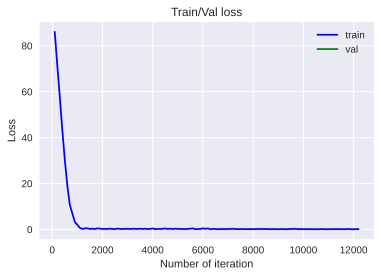

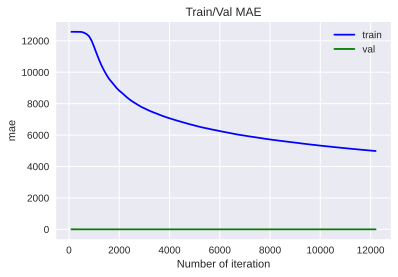

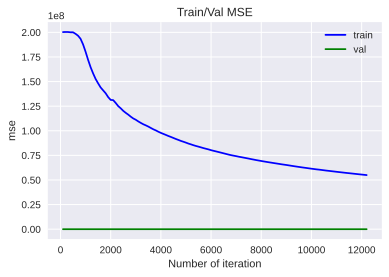

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./lstm_best_checkpoint', model_lstm, optimizer)

Loading checkpoint './lstm_best_checkpoint'
Loaded checkpoint './lstm_best_checkpoint' from iteration 11399


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_lstm, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.45689
MAE:  0.32986
LOSS:  1.82756


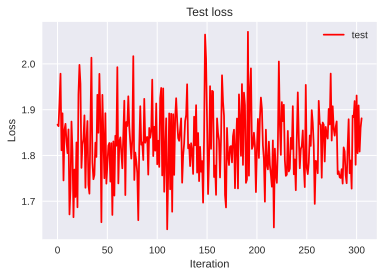

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

This time  loss is lower but still is not low enough. Of course, it reduced but not enough for 10 epochs. Other metrics are smoothly optimized. However, the predictive ability of this model is not so good.  It can bee seen by scores. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score.
 
* *** Average cross-validation scores ***:  

MSE:  0.45689  
MAE:  0.32986  
LOSS:  1.82756  

### **3) BiLSTM**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_lstm = nn.LSTM(hid_size,
                                  hid_size,
                                  num_layers=2, 
                                  bidirectional=True,
                                  batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af1 = nn.ReLU()
        
        self.description_lstm =  nn.LSTM(hid_size,
                                  hid_size,
                                  num_layers=2, 
                                  bidirectional=True,
                                  batch_first=True)
        self.dr2 = nn.Dropout(p=0.25)
        self.af2 = nn.ReLU()

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(80, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title'])
        output, (h_n_title, c_n_title) = self.title_lstm(title_embeddings)     
        h_n_title = torch.cat([h_n_title[i,:, :] for i in range(h_n_title.shape[0])], dim=1)
        out_title = self.dr1(h_n_title)
        out_title = self.af1(out_title)

        description_embeddings = self.embedder(batch['FullDescription'])
        output, (h_n_description, c_n_description) = self.title_lstm(description_embeddings)
        h_n_description = torch.cat([h_n_description[i,:, :] for i in range(h_n_description.shape[0])], dim=1)
        out_description = self.dr2(h_n_description)
        out_description = self.af2(out_description)

        categorical_features = self.categorical_encoder(batch['Categorical'])
        features = torch.cat(
            [out_title, out_description, categorical_features], dim=1)
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_bilstm = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_bilstm.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_bilstm, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./bilstm_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 101.67872
VAL  RESULTS:
Iteration: 99  Mean square error: 26.50514  Mean absolute error: 2.57131 
Saving model and optimizer state at iteration 99 to ./bilstm_best_checkpoint
train_loss 88.77341
VAL  RESULTS:
Iteration: 199  Mean square error: 24.74312  Mean absolute error: 2.4843 
Saving model and optimizer state at iteration 199 to ./bilstm_best_checkpoint
train_loss 74.79282
VAL  RESULTS:
Iteration: 299  Mean square error: 22.51524  Mean absolute error: 2.3697 
Saving model and optimizer state at iteration 299 to ./bilstm_best_checkpoint
train_loss 62.30104
VAL  RESULTS:
Iteration: 399  Mean square error: 19.78321  Mean absolute error: 2.22094 
Saving model and optimizer state at iteration 399 to ./bilstm_best_checkpoint
train_loss 49.70407
VAL  RESULTS:
Iteration: 499  Mean square error: 17.46055  Mean absolute error: 2.08606 
Saving model and optimizer state at iteration 499 to ./bilstm_best_checkpoint
train_loss 35.64443
VAL  RESULTS:
Iteration: 599  Mean square error:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.27927
VAL  RESULTS:
Iteration: 1299  Mean square error: 3.26951  Mean absolute error: 0.8965 
train_loss 0.23368
VAL  RESULTS:
Iteration: 1399  Mean square error: 3.008  Mean absolute error: 0.85942 
Saving model and optimizer state at iteration 1399 to ./bilstm_best_checkpoint
train_loss 0.2298
VAL  RESULTS:
Iteration: 1499  Mean square error: 2.59656  Mean absolute error: 0.79683 
Saving model and optimizer state at iteration 1499 to ./bilstm_best_checkpoint
train_loss 0.18281
VAL  RESULTS:
Iteration: 1599  Mean square error: 2.83512  Mean absolute error: 0.83372 
train_loss 0.24217
VAL  RESULTS:
Iteration: 1699  Mean square error: 2.62187  Mean absolute error: 0.80112 
train_loss 0.31492
VAL  RESULTS:
Iteration: 1799  Mean square error: 3.23721  Mean absolute error: 0.89157 
train_loss 0.21511
VAL  RESULTS:
Iteration: 1899  Mean square error: 2.63148  Mean absolute error: 0.80291 
train_loss 0.26068
VAL  RESULTS:
Iteration: 1999  Mean square error: 2.42432  Mean absolut

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.35101
VAL  RESULTS:
Iteration: 2499  Mean square error: 2.80302  Mean absolute error: 0.8297 
train_loss 0.19881
VAL  RESULTS:
Iteration: 2599  Mean square error: 3.17113  Mean absolute error: 0.8832 
train_loss 0.28016
VAL  RESULTS:
Iteration: 2699  Mean square error: 2.50802  Mean absolute error: 0.78458 
train_loss 0.234
VAL  RESULTS:
Iteration: 2799  Mean square error: 2.25048  Mean absolute error: 0.74231 
Saving model and optimizer state at iteration 2799 to ./bilstm_best_checkpoint
train_loss 0.22643
VAL  RESULTS:
Iteration: 2899  Mean square error: 2.77171  Mean absolute error: 0.82534 
train_loss 0.16472
VAL  RESULTS:
Iteration: 2999  Mean square error: 3.15769  Mean absolute error: 0.88146 
train_loss 0.29746
VAL  RESULTS:
Iteration: 3099  Mean square error: 2.41378  Mean absolute error: 0.76934 
train_loss 0.20845
VAL  RESULTS:
Iteration: 3199  Mean square error: 2.67174  Mean absolute error: 0.81042 
train_loss 0.16849
VAL  RESULTS:
Iteration: 3299  Mean square

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.16706
VAL  RESULTS:
Iteration: 3699  Mean square error: 2.40916  Mean absolute error: 0.76909 
train_loss 0.20911
VAL  RESULTS:
Iteration: 3799  Mean square error: 2.47581  Mean absolute error: 0.77981 
train_loss 0.28417
VAL  RESULTS:
Iteration: 3899  Mean square error: 2.13848  Mean absolute error: 0.72353 
Saving model and optimizer state at iteration 3899 to ./bilstm_best_checkpoint
train_loss 0.14949
VAL  RESULTS:
Iteration: 3999  Mean square error: 3.20739  Mean absolute error: 0.88918 
train_loss 0.12689
VAL  RESULTS:
Iteration: 4099  Mean square error: 2.56031  Mean absolute error: 0.79324 
train_loss 0.12687
VAL  RESULTS:
Iteration: 4199  Mean square error: 2.42994  Mean absolute error: 0.77216 
train_loss 0.17648
VAL  RESULTS:
Iteration: 4299  Mean square error: 2.41315  Mean absolute error: 0.77022 
train_loss 0.16544
VAL  RESULTS:
Iteration: 4399  Mean square error: 2.43899  Mean absolute error: 0.77409 
train_loss 0.15211
VAL  RESULTS:
Iteration: 4499  Mean sq

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.39405
VAL  RESULTS:
Iteration: 4899  Mean square error: 2.19035  Mean absolute error: 0.73353 
train_loss 0.37062
VAL  RESULTS:
Iteration: 4999  Mean square error: 2.26649  Mean absolute error: 0.74595 
train_loss 0.16765
VAL  RESULTS:
Iteration: 5099  Mean square error: 2.63408  Mean absolute error: 0.80493 
train_loss 0.10514
VAL  RESULTS:
Iteration: 5199  Mean square error: 2.43177  Mean absolute error: 0.77314 
train_loss 0.26496
VAL  RESULTS:
Iteration: 5299  Mean square error: 2.40844  Mean absolute error: 0.76986 
train_loss 0.19591
VAL  RESULTS:
Iteration: 5399  Mean square error: 2.12997  Mean absolute error: 0.72288 
Saving model and optimizer state at iteration 5399 to ./bilstm_best_checkpoint
train_loss 0.13792
VAL  RESULTS:
Iteration: 5499  Mean square error: 2.1636  Mean absolute error: 0.72894 
train_loss 0.29064
VAL  RESULTS:
Iteration: 5599  Mean square error: 2.22421  Mean absolute error: 0.73981 
train_loss 0.17138
VAL  RESULTS:
Iteration: 5699  Mean squ

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.18441
VAL  RESULTS:
Iteration: 6199  Mean square error: 2.17249  Mean absolute error: 0.73046 
train_loss 0.19782
VAL  RESULTS:
Iteration: 6299  Mean square error: 2.19252  Mean absolute error: 0.73409 
train_loss 0.20352
VAL  RESULTS:
Iteration: 6399  Mean square error: 2.51786  Mean absolute error: 0.78781 
train_loss 0.19317
VAL  RESULTS:
Iteration: 6499  Mean square error: 2.15394  Mean absolute error: 0.72764 
train_loss 0.10965
VAL  RESULTS:
Iteration: 6599  Mean square error: 1.96344  Mean absolute error: 0.6944 
Saving model and optimizer state at iteration 6599 to ./bilstm_best_checkpoint
train_loss 0.11214
VAL  RESULTS:
Iteration: 6699  Mean square error: 1.90143  Mean absolute error: 0.68322 
Saving model and optimizer state at iteration 6699 to ./bilstm_best_checkpoint
train_loss 0.13137
VAL  RESULTS:
Iteration: 6799  Mean square error: 1.9999  Mean absolute error: 0.70101 
train_loss 0.11386
VAL  RESULTS:
Iteration: 6899  Mean square error: 1.55195  Mean absol

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.11583
VAL  RESULTS:
Iteration: 7399  Mean square error: 1.64203  Mean absolute error: 0.63442 
train_loss 0.09658
VAL  RESULTS:
Iteration: 7499  Mean square error: 1.67413  Mean absolute error: 0.64066 
train_loss 0.18815
VAL  RESULTS:
Iteration: 7599  Mean square error: 1.98733  Mean absolute error: 0.69929 
train_loss 0.15874
VAL  RESULTS:
Iteration: 7699  Mean square error: 1.5425  Mean absolute error: 0.61453 
Saving model and optimizer state at iteration 7699 to ./bilstm_best_checkpoint
train_loss 0.34231
VAL  RESULTS:
Iteration: 7799  Mean square error: 1.68737  Mean absolute error: 0.64342 
train_loss 0.07707
VAL  RESULTS:
Iteration: 7899  Mean square error: 1.58696  Mean absolute error: 0.62365 
train_loss 0.13285
VAL  RESULTS:
Iteration: 7999  Mean square error: 1.5676  Mean absolute error: 0.61995 
train_loss 0.08592
VAL  RESULTS:
Iteration: 8099  Mean square error: 1.61392  Mean absolute error: 0.62891 
train_loss 0.11076
VAL  RESULTS:
Iteration: 8199  Mean squa

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.22848
VAL  RESULTS:
Iteration: 8599  Mean square error: 1.53097  Mean absolute error: 0.61267 
train_loss 0.14899
VAL  RESULTS:
Iteration: 8699  Mean square error: 1.18889  Mean absolute error: 0.53875 
Saving model and optimizer state at iteration 8699 to ./bilstm_best_checkpoint
train_loss 0.1886
VAL  RESULTS:
Iteration: 8799  Mean square error: 1.63992  Mean absolute error: 0.6344 
train_loss 0.19781
VAL  RESULTS:
Iteration: 8899  Mean square error: 1.59073  Mean absolute error: 0.62503 
train_loss 0.09067
VAL  RESULTS:
Iteration: 8999  Mean square error: 1.68542  Mean absolute error: 0.64392 
train_loss 0.18181
VAL  RESULTS:
Iteration: 9099  Mean square error: 1.40814  Mean absolute error: 0.58731 
train_loss 0.12369
VAL  RESULTS:
Iteration: 9199  Mean square error: 1.34397  Mean absolute error: 0.57383 
train_loss 0.08893
VAL  RESULTS:
Iteration: 9299  Mean square error: 1.4574  Mean absolute error: 0.59789 
train_loss 0.08489
VAL  RESULTS:
Iteration: 9399  Mean squar

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10881
VAL  RESULTS:
Iteration: 9799  Mean square error: 1.33362  Mean absolute error: 0.57151 
train_loss 0.22995
VAL  RESULTS:
Iteration: 9899  Mean square error: 1.16037  Mean absolute error: 0.53243 
train_loss 0.20718
VAL  RESULTS:
Iteration: 9999  Mean square error: 1.12241  Mean absolute error: 0.52331 
Saving model and optimizer state at iteration 9999 to ./bilstm_best_checkpoint
train_loss 0.13178
VAL  RESULTS:
Iteration: 10099  Mean square error: 1.23786  Mean absolute error: 0.55027 
train_loss 0.11853
VAL  RESULTS:
Iteration: 10199  Mean square error: 1.18633  Mean absolute error: 0.53883 
train_loss 0.10849
VAL  RESULTS:
Iteration: 10299  Mean square error: 1.20662  Mean absolute error: 0.54342 
train_loss 0.12509
VAL  RESULTS:
Iteration: 10399  Mean square error: 1.09995  Mean absolute error: 0.51826 
Saving model and optimizer state at iteration 10399 to ./bilstm_best_checkpoint
train_loss 0.12154
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.9864  Mea

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06479
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.88537  Mean absolute error: 0.46393 
Saving model and optimizer state at iteration 11099 to ./bilstm_best_checkpoint
train_loss 0.12756
VAL  RESULTS:
Iteration: 11199  Mean square error: 1.03143  Mean absolute error: 0.50182 
train_loss 0.20861
VAL  RESULTS:
Iteration: 11299  Mean square error: 1.12191  Mean absolute error: 0.52405 
train_loss 0.18039
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.88849  Mean absolute error: 0.46516 
train_loss 0.09469
VAL  RESULTS:
Iteration: 11499  Mean square error: 1.08942  Mean absolute error: 0.51634 
train_loss 0.10334
VAL  RESULTS:
Iteration: 11599  Mean square error: 1.00168  Mean absolute error: 0.49443 
train_loss 0.14539
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.81666  Mean absolute error: 0.44557 
Saving model and optimizer state at iteration 11699 to ./bilstm_best_checkpoint
train_loss 0.07988
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.82882

**Visualization**


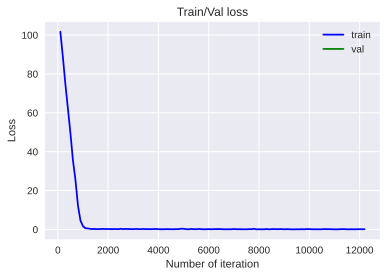

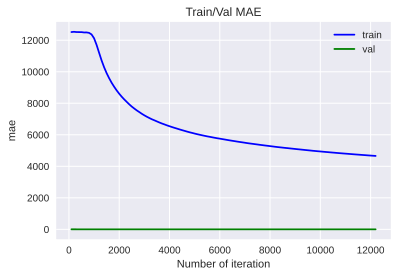

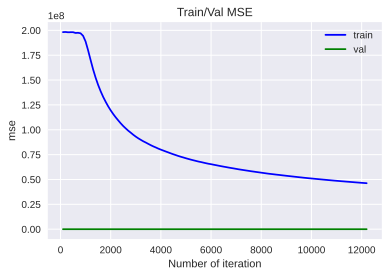

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./bilstm_best_checkpoint', model_bilstm, optimizer)

Loading checkpoint './bilstm_best_checkpoint'
Loaded checkpoint './bilstm_best_checkpoint' from iteration 11699


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_bilstm, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.81589
MAE:  0.44536
LOSS:  3.26357


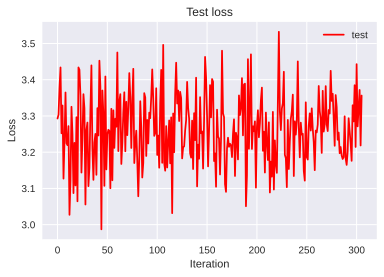

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**  

This model has the highest loss. Of course, it reduced but not enough for 10 epochs. Other metrics are smoothly optimized. However, the predictive ability of this model is not so good.  It can bee seen by scores. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score.

* *** Average cross-validation scores ***: 

MSE:  0.81589  
MAE:  0.44536  
LOSS:  3.26357  


### **4)Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription**

**V1**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_conv1 = nn.Conv1d(hid_size, hid_size, kernel_size=2)
        self.af11 = nn.ReLU()
        self.title_lstm = nn.LSTM(hid_size, hid_size, batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af12 = nn.ReLU()
        
        self.description_conv1 = nn.Conv1d(hid_size, hid_size, kernel_size=2)
        self.af21 = nn.ReLU()
        self.description_lstm = nn.LSTM(hid_size,hid_size, batch_first=True)
        self.dr2 = nn.Dropout(p=0.25)
        self.af22 = nn.ReLU()

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        out1 = self.title_conv1(title_embeddings)
        out1 = self.af11(out1).permute(0, 2, 1)
        output, (h_n_title, c_n_title) = self.title_lstm(out1)     
        h_n_title = torch.squeeze(h_n_title, 0)
        out_title = self.dr1(h_n_title)
        out_title = self.af12(out_title)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        out2 = self.description_conv1(description_embeddings)
        out2 = self.af21(out2).permute(0, 2, 1)

        output, (h_n_description, c_n_description) = self.description_lstm(out2)
        h_n_description = torch.squeeze(h_n_description, 0)
        out_description = self.dr2(h_n_description)
        out_description = self.af22(out_description)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [out_title, out_description, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_hybrid = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_hybrid.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_hybrid, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./hybrid_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 110.35327
VAL  RESULTS:
Iteration: 99  Mean square error: 27.70367  Mean absolute error: 2.62883 
Saving model and optimizer state at iteration 99 to ./hybrid_best_checkpoint
train_loss 100.57814
VAL  RESULTS:
Iteration: 199  Mean square error: 26.9344  Mean absolute error: 2.59199 
Saving model and optimizer state at iteration 199 to ./hybrid_best_checkpoint
train_loss 93.50642
VAL  RESULTS:
Iteration: 299  Mean square error: 24.88946  Mean absolute error: 2.49132 
Saving model and optimizer state at iteration 299 to ./hybrid_best_checkpoint
train_loss 84.83748
VAL  RESULTS:
Iteration: 399  Mean square error: 23.61759  Mean absolute error: 2.42631 
Saving model and optimizer state at iteration 399 to ./hybrid_best_checkpoint
train_loss 73.19
VAL  RESULTS:
Iteration: 499  Mean square error: 18.70773  Mean absolute error: 2.14304 
Saving model and optimizer state at iteration 499 to ./hybrid_best_checkpoint
train_loss 56.86805
VAL  RESULTS:
Iteration: 599  Mean square error: 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 2.66164
VAL  RESULTS:
Iteration: 1299  Mean square error: 1.8945  Mean absolute error: 0.58638 
Saving model and optimizer state at iteration 1299 to ./hybrid_best_checkpoint
train_loss 1.50311
VAL  RESULTS:
Iteration: 1399  Mean square error: 1.43984  Mean absolute error: 0.45408 
Saving model and optimizer state at iteration 1399 to ./hybrid_best_checkpoint
train_loss 1.78711
VAL  RESULTS:
Iteration: 1499  Mean square error: 1.24104  Mean absolute error: 0.41091 
Saving model and optimizer state at iteration 1499 to ./hybrid_best_checkpoint
train_loss 0.27334
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.88665  Mean absolute error: 0.36381 
Saving model and optimizer state at iteration 1599 to ./hybrid_best_checkpoint
train_loss 0.3164
VAL  RESULTS:
Iteration: 1699  Mean square error: 1.0197  Mean absolute error: 0.47732 
train_loss 0.29626
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.60154  Mean absolute error: 0.33606 
Saving model and optimizer state at ite

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.20011
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.58813  Mean absolute error: 0.30729 
train_loss 0.47125
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.5706  Mean absolute error: 0.29399 
train_loss 0.18961
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.58477  Mean absolute error: 0.28671 
train_loss 0.15443
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.54996  Mean absolute error: 0.28258 
train_loss 0.22036
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.59763  Mean absolute error: 0.27343 
train_loss 0.18574
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.45195  Mean absolute error: 0.26479 
train_loss 0.22742
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.58248  Mean absolute error: 0.3077 
train_loss 0.14714
VAL  RESULTS:
Iteration: 3199  Mean square error: 0.47656  Mean absolute error: 0.269 
train_loss 0.26264
VAL  RESULTS:
Iteration: 3299  Mean square error: 0.63891  Mean absolute error: 0.36162 
train_loss 0.23873
VAL  RESULTS:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.29516
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.54415  Mean absolute error: 0.27005 
train_loss 0.22454
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.5055  Mean absolute error: 0.25718 
train_loss 0.41144
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.51668  Mean absolute error: 0.2727 
train_loss 0.90239
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.4993  Mean absolute error: 0.28922 
train_loss 0.23899
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.54204  Mean absolute error: 0.31365 
train_loss 0.2398
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.41476  Mean absolute error: 0.25363 
train_loss 0.1389
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.47169  Mean absolute error: 0.2846 
train_loss 0.47655
VAL  RESULTS:
Iteration: 4399  Mean square error: 0.85818  Mean absolute error: 0.43678 
train_loss 0.4619
VAL  RESULTS:
Iteration: 4499  Mean square error: 0.50684  Mean absolute error: 0.32748 
train_loss 0.30079
VAL  RESULTS:
It

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.69845
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.55467  Mean absolute error: 0.35114 
train_loss 0.2676
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.59521  Mean absolute error: 0.36561 
train_loss 0.29897
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.54778  Mean absolute error: 0.35175 
train_loss 0.21624
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.44615  Mean absolute error: 0.31234 
train_loss 0.50967
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.55057  Mean absolute error: 0.35137 
train_loss 0.21669
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.48637  Mean absolute error: 0.33074 
train_loss 0.25145
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.65793  Mean absolute error: 0.38798 
train_loss 0.26138
VAL  RESULTS:
Iteration: 5599  Mean square error: 0.47933  Mean absolute error: 0.32975 
train_loss 0.16427
VAL  RESULTS:
Iteration: 5699  Mean square error: 0.55019  Mean absolute error: 0.3525 
train_loss 0.18436
VAL  RESULT

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.19737
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.45356  Mean absolute error: 0.32127 
train_loss 0.19576
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.3817  Mean absolute error: 0.29057 
train_loss 0.27371
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.56609  Mean absolute error: 0.36206 
train_loss 0.25485
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.3908  Mean absolute error: 0.29506 
train_loss 0.22487
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.55882  Mean absolute error: 0.35989 
train_loss 0.18783
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.55311  Mean absolute error: 0.35707 
train_loss 0.27726
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.38879  Mean absolute error: 0.29476 
train_loss 0.17536
VAL  RESULTS:
Iteration: 6899  Mean square error: 0.57139  Mean absolute error: 0.36375 
train_loss 0.20988
VAL  RESULTS:
Iteration: 6999  Mean square error: 0.39217  Mean absolute error: 0.29651 
train_loss 0.22413
VAL  RESULT

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.1356
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.43071  Mean absolute error: 0.31178 
train_loss 0.45387
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.3115  Mean absolute error: 0.25958 
Saving model and optimizer state at iteration 7499 to ./hybrid_best_checkpoint
train_loss 0.2304
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.24095  Mean absolute error: 0.22441 
Saving model and optimizer state at iteration 7599 to ./hybrid_best_checkpoint
train_loss 0.33093
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.40795  Mean absolute error: 0.3028 
train_loss 0.16913
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.32892  Mean absolute error: 0.26941 
train_loss 0.18372
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.44901  Mean absolute error: 0.32023 
train_loss 0.31799
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.36111  Mean absolute error: 0.28398 
train_loss 0.15151
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.31381  Mean absolut

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.17512
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.28294  Mean absolute error: 0.24722 
train_loss 0.18897
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.33149  Mean absolute error: 0.27044 
train_loss 0.20346
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.32819  Mean absolute error: 0.26873 
train_loss 0.23231
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.34276  Mean absolute error: 0.27513 
train_loss 0.14398
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.23518  Mean absolute error: 0.22217 
Saving model and optimizer state at iteration 8999 to ./hybrid_best_checkpoint
train_loss 0.38461
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.26494  Mean absolute error: 0.23846 
train_loss 0.17548
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.34473  Mean absolute error: 0.2768 
train_loss 0.14864
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.18326  Mean absolute error: 0.19108 
Saving model and optimizer state at iteration 9299 to ./hy

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.15767
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.333  Mean absolute error: 0.27036 
train_loss 0.16104
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.24742  Mean absolute error: 0.22934 
train_loss 0.21491
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.22384  Mean absolute error: 0.21642 
train_loss 0.45099
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.24983  Mean absolute error: 0.23077 
train_loss 0.10688
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.20289  Mean absolute error: 0.20353 
train_loss 0.16515
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.18217  Mean absolute error: 0.19165 
Saving model and optimizer state at iteration 10299 to ./hybrid_best_checkpoint
train_loss 0.12979
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.22347  Mean absolute error: 0.21419 
train_loss 0.2092
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.33313  Mean absolute error: 0.27045 
train_loss 0.1552
VAL  RESULTS:
Iteration: 10599  Mean

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.24618
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.22617  Mean absolute error: 0.21664 
train_loss 0.21537
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.12517  Mean absolute error: 0.15102 
Saving model and optimizer state at iteration 11199 to ./hybrid_best_checkpoint
train_loss 0.17076
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.1607  Mean absolute error: 0.17727 
train_loss 0.17666
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.16401  Mean absolute error: 0.17854 
train_loss 0.23682
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.12779  Mean absolute error: 0.15541 
train_loss 0.16243
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.18702  Mean absolute error: 0.19508 
train_loss 0.16237
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.195  Mean absolute error: 0.19721 
train_loss 0.14448
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.10929  Mean absolute error: 0.13972 
Saving model and optimizer state at iteration 11799

**Visualization**

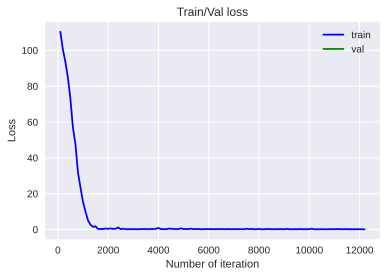

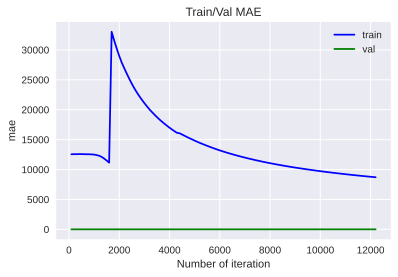

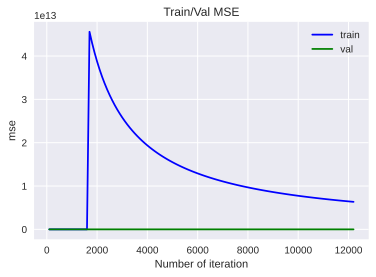

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./hybrid_best_checkpoint', model_hybrid, optimizer)

Loading checkpoint './hybrid_best_checkpoint'
Loaded checkpoint './hybrid_best_checkpoint' from iteration 11999


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_hybrid, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.10512
MAE:  0.13789
LOSS:  0.4205


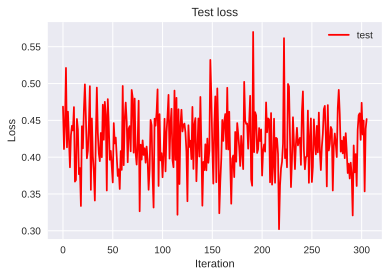

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

* Metrics jump a lot at the beginning of model training, however, at about the 4th epoch, metrics are regularized and decrease. You can see that the metrics are also higher than expected.
* The predictive ability of this model is very good. Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score. 
* *** Average cross-validation scores ***:  

MSE:  0.10512  
MAE:  0.13789  
LOSS:  0.4205  


**V2 (different mix of layers)**

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.title_conv1 = nn.Conv1d(hid_size, hid_size, kernel_size=2)
        self.af11 = nn.ReLU()
        self.title_lstm = nn.LSTM(hid_size, hid_size, batch_first=True)
        self.dr1 = nn.Dropout(p=0.25)
        self.af12 = nn.ReLU()
        
        self.description_conv1 = nn.Conv1d(hid_size, hid_size*2, kernel_size=5)
        self.af21 = nn.ReLU()
        self.description_conv2 = nn.Conv1d(hid_size*2, hid_size*4, kernel_size=3)
        self.af22 = nn.ReLU()
        self.description_conv3 = nn.Conv1d(hid_size*4, hid_size, kernel_size=3)
        self.af23 = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.description_lstm = nn.LSTM(hid_size,hid_size, batch_first=True)
        self.dr2 = nn.Dropout(p=0.25)
        self.af24 = nn.ReLU()

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        embeddings = self.embedder(batch['Title'])
        out1 = self.title_conv1(title_embeddings)
        out1 = self.af11(out1).permute(0, 2, 1)
        output, (h_n_title, c_n_title) = self.title_lstm(out1)     
        h_n_title = torch.squeeze(h_n_title, 0)
        out_title = self.dr1(h_n_title)
        out_title = self.af12(out_title)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        out2 = self.description_conv1(description_embeddings)
        out2 = self.af21(out2)
        out2 = self.description_conv2(out2)
        out2 = self.af22(out2)
        out2 = self.description_conv3(out2)
        out2 = self.af23(out2)
        out2 = self.pool(out2).permute(0, 2, 1)
        output, (h_n_description, c_n_description) = self.description_lstm(out2)
        h_n_description = torch.squeeze(h_n_description, 0)
        out_description = self.dr2(h_n_description)
        out_description = self.af24(out_description)

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [out_title, out_description, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()
       

**Training**

In [ ]:
model_hybrid_v2 = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_hybrid_v2.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_hybrid_v2, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./hybrid_best_checkpoint_v2",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 102.21999
VAL  RESULTS:
Iteration: 99  Mean square error: 26.86325  Mean absolute error: 2.58857 
Saving model and optimizer state at iteration 99 to ./hybrid_best_checkpoint_v2
train_loss 89.98
VAL  RESULTS:
Iteration: 199  Mean square error: 25.56193  Mean absolute error: 2.52519 
Saving model and optimizer state at iteration 199 to ./hybrid_best_checkpoint_v2
train_loss 71.93746
VAL  RESULTS:
Iteration: 299  Mean square error: 22.43493  Mean absolute error: 2.36561 
Saving model and optimizer state at iteration 299 to ./hybrid_best_checkpoint_v2
train_loss 57.32283
VAL  RESULTS:
Iteration: 399  Mean square error: 19.00403  Mean absolute error: 2.17708 
Saving model and optimizer state at iteration 399 to ./hybrid_best_checkpoint_v2
train_loss 44.09674
VAL  RESULTS:
Iteration: 499  Mean square error: 15.32398  Mean absolute error: 1.95473 
Saving model and optimizer state at iteration 499 to ./hybrid_best_checkpoint_v2
train_loss 25.12119
VAL  RESULTS:
Iteration: 599  Mean

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.27868
VAL  RESULTS:
Iteration: 1299  Mean square error: 1.35634  Mean absolute error: 0.55718 
Saving model and optimizer state at iteration 1299 to ./hybrid_best_checkpoint_v2
train_loss 0.24811
VAL  RESULTS:
Iteration: 1399  Mean square error: 1.19561  Mean absolute error: 0.5185 
Saving model and optimizer state at iteration 1399 to ./hybrid_best_checkpoint_v2
train_loss 0.20213
VAL  RESULTS:
Iteration: 1499  Mean square error: 1.59096  Mean absolute error: 0.60349 
train_loss 0.36601
VAL  RESULTS:
Iteration: 1599  Mean square error: 1.36126  Mean absolute error: 0.5596 
train_loss 0.24442
VAL  RESULTS:
Iteration: 1699  Mean square error: 1.09298  Mean absolute error: 0.50109 
Saving model and optimizer state at iteration 1699 to ./hybrid_best_checkpoint_v2
train_loss 0.22504
VAL  RESULTS:
Iteration: 1799  Mean square error: 1.31095  Mean absolute error: 0.54799 
train_loss 0.25907
VAL  RESULTS:
Iteration: 1899  Mean square error: 1.5488  Mean absolute error: 0.59892 
t

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.37055
VAL  RESULTS:
Iteration: 2499  Mean square error: 1.35096  Mean absolute error: 0.56226 
train_loss 0.16334
VAL  RESULTS:
Iteration: 2599  Mean square error: 1.93712  Mean absolute error: 0.67337 
train_loss 0.31751
VAL  RESULTS:
Iteration: 2699  Mean square error: 1.19743  Mean absolute error: 0.53144 
train_loss 0.61238
VAL  RESULTS:
Iteration: 2799  Mean square error: 1.47103  Mean absolute error: 0.59043 
train_loss 0.31965
VAL  RESULTS:
Iteration: 2899  Mean square error: 1.35922  Mean absolute error: 0.56615 
train_loss 0.22425
VAL  RESULTS:
Iteration: 2999  Mean square error: 1.53369  Mean absolute error: 0.6023 
train_loss 0.14491
VAL  RESULTS:
Iteration: 3099  Mean square error: 1.37653  Mean absolute error: 0.56841 
train_loss 0.15185
VAL  RESULTS:
Iteration: 3199  Mean square error: 1.29279  Mean absolute error: 0.55227 
train_loss 0.43985
VAL  RESULTS:
Iteration: 3299  Mean square error: 1.50857  Mean absolute error: 0.59699 
train_loss 0.14999
VAL  RESUL

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.22606
VAL  RESULTS:
Iteration: 3699  Mean square error: 1.2797  Mean absolute error: 0.55076 
train_loss 0.34316
VAL  RESULTS:
Iteration: 3799  Mean square error: 1.47378  Mean absolute error: 0.59568 
train_loss 0.30805
VAL  RESULTS:
Iteration: 3899  Mean square error: 1.36373  Mean absolute error: 0.57066 
train_loss 0.29525
VAL  RESULTS:
Iteration: 3999  Mean square error: 1.43863  Mean absolute error: 0.58632 
train_loss 0.1368
VAL  RESULTS:
Iteration: 4099  Mean square error: 1.30636  Mean absolute error: 0.55627 
train_loss 0.27064
VAL  RESULTS:
Iteration: 4199  Mean square error: 1.36148  Mean absolute error: 0.5673 
train_loss 0.30288
VAL  RESULTS:
Iteration: 4299  Mean square error: 1.52494  Mean absolute error: 0.60153 
train_loss 0.37532
VAL  RESULTS:
Iteration: 4399  Mean square error: 1.50696  Mean absolute error: 0.60063 
train_loss 0.20501
VAL  RESULTS:
Iteration: 4499  Mean square error: 1.49747  Mean absolute error: 0.5978 
train_loss 0.24235
VAL  RESULTS:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.27224
VAL  RESULTS:
Iteration: 4899  Mean square error: 1.25945  Mean absolute error: 0.54578 
train_loss 0.21734
VAL  RESULTS:
Iteration: 4999  Mean square error: 1.33205  Mean absolute error: 0.56406 
train_loss 0.16077
VAL  RESULTS:
Iteration: 5099  Mean square error: 1.52983  Mean absolute error: 0.60424 
train_loss 0.13696
VAL  RESULTS:
Iteration: 5199  Mean square error: 1.35503  Mean absolute error: 0.56999 
train_loss 0.34413
VAL  RESULTS:
Iteration: 5299  Mean square error: 1.28967  Mean absolute error: 0.55511 
train_loss 0.16253
VAL  RESULTS:
Iteration: 5399  Mean square error: 1.24672  Mean absolute error: 0.54473 
train_loss 0.72474
VAL  RESULTS:
Iteration: 5499  Mean square error: 1.42598  Mean absolute error: 0.58617 
train_loss 0.16759
VAL  RESULTS:
Iteration: 5599  Mean square error: 1.33215  Mean absolute error: 0.5641 
train_loss 0.13673
VAL  RESULTS:
Iteration: 5699  Mean square error: 1.27709  Mean absolute error: 0.55239 
train_loss 0.22043
VAL  RESUL

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.20699
VAL  RESULTS:
Iteration: 6199  Mean square error: 1.16493  Mean absolute error: 0.52833 
train_loss 0.2211
VAL  RESULTS:
Iteration: 6299  Mean square error: 1.06728  Mean absolute error: 0.50355 
Saving model and optimizer state at iteration 6299 to ./hybrid_best_checkpoint_v2
train_loss 0.24867
VAL  RESULTS:
Iteration: 6399  Mean square error: 1.27457  Mean absolute error: 0.55253 
train_loss 0.17615
VAL  RESULTS:
Iteration: 6499  Mean square error: 1.19662  Mean absolute error: 0.53592 
train_loss 0.1693
VAL  RESULTS:
Iteration: 6599  Mean square error: 1.12445  Mean absolute error: 0.51832 
train_loss 0.17894
VAL  RESULTS:
Iteration: 6699  Mean square error: 1.15966  Mean absolute error: 0.52653 
train_loss 0.22424
VAL  RESULTS:
Iteration: 6799  Mean square error: 1.10443  Mean absolute error: 0.51402 
train_loss 0.19393
VAL  RESULTS:
Iteration: 6899  Mean square error: 1.16837  Mean absolute error: 0.52962 
train_loss 0.1382
VAL  RESULTS:
Iteration: 6999  Mean sq

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.28345
VAL  RESULTS:
Iteration: 7399  Mean square error: 1.19385  Mean absolute error: 0.53523 
train_loss 0.11196
VAL  RESULTS:
Iteration: 7499  Mean square error: 1.00197  Mean absolute error: 0.48952 
train_loss 0.16844
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.93655  Mean absolute error: 0.47286 
train_loss 0.34998
VAL  RESULTS:
Iteration: 7699  Mean square error: 1.07957  Mean absolute error: 0.50771 
train_loss 0.17883
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.89931  Mean absolute error: 0.46234 
Saving model and optimizer state at iteration 7799 to ./hybrid_best_checkpoint_v2
train_loss 0.214
VAL  RESULTS:
Iteration: 7899  Mean square error: 1.06634  Mean absolute error: 0.50628 
train_loss 0.15118
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.8739  Mean absolute error: 0.45616 
Saving model and optimizer state at iteration 7999 to ./hybrid_best_checkpoint_v2
train_loss 0.13788
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.90012  Mean 

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.19257
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.79239  Mean absolute error: 0.43264 
Saving model and optimizer state at iteration 8599 to ./hybrid_best_checkpoint_v2
train_loss 0.16055
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.85079  Mean absolute error: 0.44973 
train_loss 0.22183
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.91844  Mean absolute error: 0.46788 
train_loss 0.1514
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.79227  Mean absolute error: 0.4327 
Saving model and optimizer state at iteration 8899 to ./hybrid_best_checkpoint_v2
train_loss 0.20008
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.71824  Mean absolute error: 0.41125 
Saving model and optimizer state at iteration 8999 to ./hybrid_best_checkpoint_v2
train_loss 0.11337
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.66312  Mean absolute error: 0.39441 
Saving model and optimizer state at iteration 9099 to ./hybrid_best_checkpoint_v2
train_loss 0.1598
VAL  RES

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.20818
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.65706  Mean absolute error: 0.39251 
Saving model and optimizer state at iteration 9799 to ./hybrid_best_checkpoint_v2
train_loss 0.2067
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.70631  Mean absolute error: 0.40801 
train_loss 0.14042
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.7595  Mean absolute error: 0.42438 
train_loss 0.13749
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.6473  Mean absolute error: 0.38949 
Saving model and optimizer state at iteration 10099 to ./hybrid_best_checkpoint_v2
train_loss 0.13315
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.59299  Mean absolute error: 0.37171 
Saving model and optimizer state at iteration 10199 to ./hybrid_best_checkpoint_v2
train_loss 0.12527
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.605  Mean absolute error: 0.37464 
train_loss 0.17681
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.54626  Mean absolute error: 0.3551

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.13307
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.52771  Mean absolute error: 0.3494 
train_loss 0.14852
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.4965  Mean absolute error: 0.338 
Saving model and optimizer state at iteration 11199 to ./hybrid_best_checkpoint_v2
train_loss 0.14701
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.5017  Mean absolute error: 0.34011 
train_loss 0.15732
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.46927  Mean absolute error: 0.32596 
Saving model and optimizer state at iteration 11399 to ./hybrid_best_checkpoint_v2
train_loss 0.11601
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.4017  Mean absolute error: 0.30103 
Saving model and optimizer state at iteration 11499 to ./hybrid_best_checkpoint_v2
train_loss 0.13694
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.42562  Mean absolute error: 0.3103 
train_loss 0.12359
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.48161  Mean absolute error: 0.33

**Visualization**

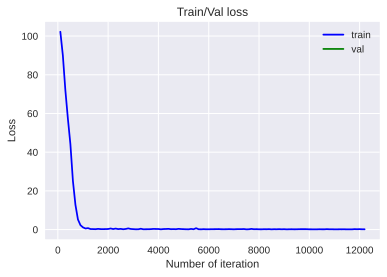

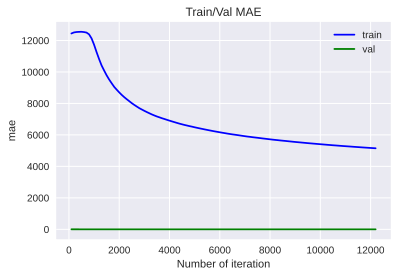

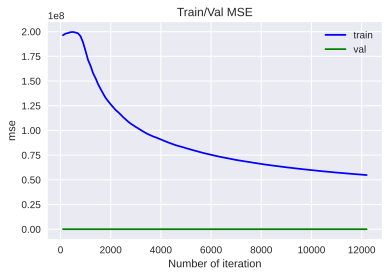

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./hybrid_best_checkpoint_v2', model_hybrid_v2, optimizer)


Loading checkpoint './hybrid_best_checkpoint_v2'
Loaded checkpoint './hybrid_best_checkpoint_v2' from iteration 12199


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_hybrid_v2, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.40151
MAE:  0.3003
LOSS:  1.60605


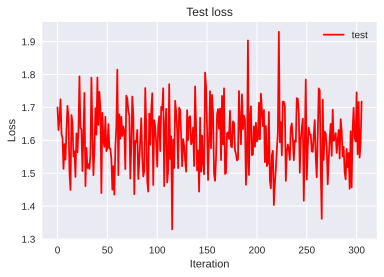

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

The loss is stabilized and reduced almost from the first iterations, and other metrics are also smoothly optimized. The predictive ability of this model is very good.  Scores are extremely good. I think it's worth working better with the layers of the model or train or epochs in order to lower loss score.

* *** Average cross-validation scores ***:  

MSE:  0.40151  
MAE:  0.3003  
LOSS:  1.60605  


## **General conclusion №4**
When I use only recurrent networks on this dataset, the loss is not too low enough and the metrics are clearly inferior to convolutional neural networks with pooling and normalization. Also, these networks have many parameters and take much time to learn.

However, if we use a mix of recurrent networks together with convolutional networks, then the loss function and metrics are already close to the values of the best model.

The convolutional-recurrent model from the first variant coped with the task best in this task(V1).


# **🚩  5. Pooling слои продвинутые**

Реализация и применение:

* Softmax-pooling:$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, где $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$и $NN_{attn}$ полносвязный слой.


### **Softmax Pooling**

In [ ]:
class SoftmaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return (x * x.softmax(dim=self.dim)).sum(dim=self.dim)

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            SoftmaxPooling(),
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            SoftmaxPooling(),
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_smp = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_smp.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_smp, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_smp_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 81.72462
VAL  RESULTS:
Iteration: 99  Mean square error: 19.93502  Mean absolute error: 2.2275 
Saving model and optimizer state at iteration 99 to ./cnn_smp_best_checkpoint
train_loss 64.68665
VAL  RESULTS:
Iteration: 199  Mean square error: 15.82608  Mean absolute error: 1.98384 
Saving model and optimizer state at iteration 199 to ./cnn_smp_best_checkpoint
train_loss 47.01818
VAL  RESULTS:
Iteration: 299  Mean square error: 11.67605  Mean absolute error: 1.70138 
Saving model and optimizer state at iteration 299 to ./cnn_smp_best_checkpoint
train_loss 31.67623
VAL  RESULTS:
Iteration: 399  Mean square error: 7.6978  Mean absolute error: 1.37788 
Saving model and optimizer state at iteration 399 to ./cnn_smp_best_checkpoint
train_loss 18.83871
VAL  RESULTS:
Iteration: 499  Mean square error: 4.29132  Mean absolute error: 1.02405 
Saving model and optimizer state at iteration 499 to ./cnn_smp_best_checkpoint
train_loss 9.36277
VAL  RESULTS:
Iteration: 599  Mean square error

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.20833
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.04094  Mean absolute error: 0.0785 
Saving model and optimizer state at iteration 1299 to ./cnn_smp_best_checkpoint
train_loss 0.13637
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.03968  Mean absolute error: 0.07611 
Saving model and optimizer state at iteration 1399 to ./cnn_smp_best_checkpoint
train_loss 0.2274
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.04011  Mean absolute error: 0.07659 
train_loss 0.1727
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.03719  Mean absolute error: 0.07379 
Saving model and optimizer state at iteration 1599 to ./cnn_smp_best_checkpoint
train_loss 0.24199
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.03627  Mean absolute error: 0.07318 
Saving model and optimizer state at iteration 1699 to ./cnn_smp_best_checkpoint
train_loss 0.13834
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.03438  Mean absolute error: 0.07106 
Saving model and optimizer state at

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.1442
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.03119  Mean absolute error: 0.06734 
Saving model and optimizer state at iteration 2499 to ./cnn_smp_best_checkpoint
train_loss 0.08054
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.03137  Mean absolute error: 0.06773 
train_loss 0.11795
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.0323  Mean absolute error: 0.06817 
train_loss 0.09881
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.03077  Mean absolute error: 0.06691 
Saving model and optimizer state at iteration 2799 to ./cnn_smp_best_checkpoint
train_loss 0.10869
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.03082  Mean absolute error: 0.06661 
train_loss 0.12829
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.0292  Mean absolute error: 0.06515 
Saving model and optimizer state at iteration 2999 to ./cnn_smp_best_checkpoint
train_loss 0.13669
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.02977  Mean absolute error: 0.06575 
train_l

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.1143
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.02801  Mean absolute error: 0.064 
Saving model and optimizer state at iteration 3699 to ./cnn_smp_best_checkpoint
train_loss 0.10748
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.02727  Mean absolute error: 0.06295 
Saving model and optimizer state at iteration 3799 to ./cnn_smp_best_checkpoint
train_loss 0.12231
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.02819  Mean absolute error: 0.06392 
train_loss 0.09004
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.02883  Mean absolute error: 0.0654 
train_loss 0.1038
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.02738  Mean absolute error: 0.0631 
train_loss 0.10357
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.02637  Mean absolute error: 0.06149 
Saving model and optimizer state at iteration 4199 to ./cnn_smp_best_checkpoint
train_loss 0.14022
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.02685  Mean absolute error: 0.06224 
train_loss

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07536
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.0258  Mean absolute error: 0.06125 
train_loss 0.08604
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.02457  Mean absolute error: 0.0592 
Saving model and optimizer state at iteration 4999 to ./cnn_smp_best_checkpoint
train_loss 0.10914
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.02426  Mean absolute error: 0.05884 
Saving model and optimizer state at iteration 5099 to ./cnn_smp_best_checkpoint
train_loss 0.10451
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.02485  Mean absolute error: 0.05958 
train_loss 0.1002
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.02621  Mean absolute error: 0.06172 
train_loss 0.09726
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.02461  Mean absolute error: 0.05969 
train_loss 0.1071
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.02359  Mean absolute error: 0.05794 
Saving model and optimizer state at iteration 5499 to ./cnn_smp_best_checkpoint
train_lo

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06687
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.02406  Mean absolute error: 0.0591 
train_loss 0.10624
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.02216  Mean absolute error: 0.05588 
Saving model and optimizer state at iteration 6299 to ./cnn_smp_best_checkpoint
train_loss 0.08096
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.02197  Mean absolute error: 0.05554 
Saving model and optimizer state at iteration 6399 to ./cnn_smp_best_checkpoint
train_loss 0.08075
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.02214  Mean absolute error: 0.05606 
train_loss 0.08823
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.02219  Mean absolute error: 0.0562 
train_loss 0.1416
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.02225  Mean absolute error: 0.05628 
train_loss 0.07188
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.02185  Mean absolute error: 0.05551 
Saving model and optimizer state at iteration 6799 to ./cnn_smp_best_checkpoint
train_l

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.08356
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.02191  Mean absolute error: 0.05574 
train_loss 0.09174
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.02083  Mean absolute error: 0.05395 
Saving model and optimizer state at iteration 7499 to ./cnn_smp_best_checkpoint
train_loss 0.07135
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.02168  Mean absolute error: 0.05546 
train_loss 0.09115
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.0204  Mean absolute error: 0.0533 
Saving model and optimizer state at iteration 7699 to ./cnn_smp_best_checkpoint
train_loss 0.05886
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.0213  Mean absolute error: 0.05498 
train_loss 0.10195
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.02244  Mean absolute error: 0.05646 
train_loss 0.07225
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.02046  Mean absolute error: 0.05361 
train_loss 0.07982
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.02073  Mean abso

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.05535
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.02056  Mean absolute error: 0.05376 
train_loss 0.05178
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.01971  Mean absolute error: 0.05227 
Saving model and optimizer state at iteration 8699 to ./cnn_smp_best_checkpoint
train_loss 0.07211
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.01919  Mean absolute error: 0.05155 
Saving model and optimizer state at iteration 8799 to ./cnn_smp_best_checkpoint
train_loss 0.05273
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.02238  Mean absolute error: 0.05649 
train_loss 0.06695
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.0201  Mean absolute error: 0.05313 
train_loss 0.05947
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.02289  Mean absolute error: 0.05739 
train_loss 0.09566
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.01927  Mean absolute error: 0.05192 
train_loss 0.06398
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.01959  Mean ab

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.0849
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.01928  Mean absolute error: 0.05169 
train_loss 0.09474
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.01928  Mean absolute error: 0.05199 
train_loss 0.08333
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.01959  Mean absolute error: 0.05268 
train_loss 0.08578
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.02013  Mean absolute error: 0.05336 
train_loss 0.07635
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.02276  Mean absolute error: 0.05724 
train_loss 0.05217
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.0201  Mean absolute error: 0.05318 
train_loss 0.05377
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.01951  Mean absolute error: 0.05215 
train_loss 0.04587
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.01905  Mean absolute error: 0.05161 
Saving model and optimizer state at iteration 10499 to ./cnn_smp_best_checkpoint
train_loss 0.06296
VAL  RESULTS:
Iteration: 10599  M

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07315
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.01861  Mean absolute error: 0.05102 
train_loss 0.08873
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.01932  Mean absolute error: 0.05184 
train_loss 0.09663
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.0181  Mean absolute error: 0.05002 
train_loss 0.08134
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.01819  Mean absolute error: 0.05013 
train_loss 0.06427
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.01883  Mean absolute error: 0.0513 
train_loss 0.08789
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.01865  Mean absolute error: 0.05104 
train_loss 0.06762
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.01792  Mean absolute error: 0.04961 
Saving model and optimizer state at iteration 11699 to ./cnn_smp_best_checkpoint
train_loss 0.06229
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.01816  Mean absolute error: 0.05026 
train_loss 0.05908
VAL  RESULTS:
Iteration: 11899

**Visualization**

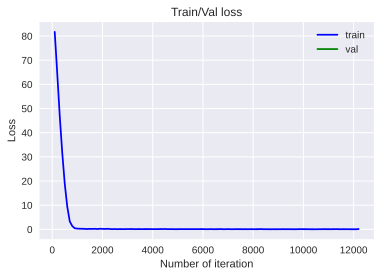

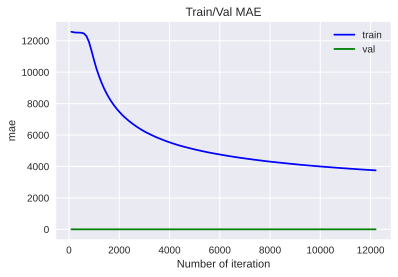

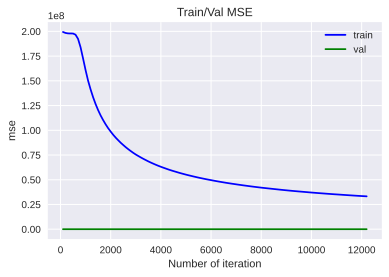

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_smp_best_checkpoint', model_smp, optimizer)

Loading checkpoint './cnn_smp_best_checkpoint'
Loaded checkpoint './cnn_smp_best_checkpoint' from iteration 11699


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_smp, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.01787
MAE:  0.04964
LOSS:  0.07149


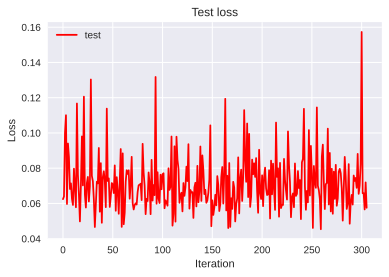

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

* Improving gradient accuracy is still an exciting area.  While the forward-pass values are nearly identical to those of max-pooling, softmax pooling's backward pass has the property that all elements in the window receive a gradient update, rather than just the maximum one. We hypothesize that these richer, more accurate gradients can improve the learning dynamics.

* Metrics decrease smoothly. The predictive ability of this model is very good.  Scores are great. 
* *** Average cross-validation scores ***: 

MSE:  0.01787  
MAE:  0.04964  
LOSS:  0.07149  
 

### **AttentivePooling**

In [ ]:
class AttentivePooling(nn.Module):
    def __init__(self, dim=-1, input_size=128, hidden_size=32):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nn_attn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return (x * torch.transpose(self.nn_attn(torch.transpose(x, 2, 1)), 1, 2).softmax(dim=self.dim)).sum(dim=self.dim)
    

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            AttentivePooling(input_size=hid_size),
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            AttentivePooling(input_size=hid_size),
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

**Training**

In [ ]:
model_avp = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_avp.parameters(), lr=1e-3)

iteration_list, train_loss_array,val_loss_array,\
         mse_train_loss_array, mse_val_loss_array, \
         mae_train_loss_array, mae_val_loss_array  = train(model_avp, optimizer, criterion, 
          data_train, data_val, 
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, iter_per_validation=100,
          early_stopping=False,
          checkpoint_path="./cnn_avp_best_checkpoint",
          save_by="mse",
          device=DEVICE)

Epoch 0


  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 90.4649
VAL  RESULTS:
Iteration: 99  Mean square error: 22.72329  Mean absolute error: 2.379 
Saving model and optimizer state at iteration 99 to ./cnn_avp_best_checkpoint
train_loss 76.1058
VAL  RESULTS:
Iteration: 199  Mean square error: 18.76785  Mean absolute error: 2.1595 
Saving model and optimizer state at iteration 199 to ./cnn_avp_best_checkpoint
train_loss 58.86335
VAL  RESULTS:
Iteration: 299  Mean square error: 14.92386  Mean absolute error: 1.92232 
Saving model and optimizer state at iteration 299 to ./cnn_avp_best_checkpoint
train_loss 41.20521
VAL  RESULTS:
Iteration: 399  Mean square error: 10.82748  Mean absolute error: 1.63169 
Saving model and optimizer state at iteration 399 to ./cnn_avp_best_checkpoint
train_loss 26.11876
VAL  RESULTS:
Iteration: 499  Mean square error: 6.64894  Mean absolute error: 1.27927 
Saving model and optimizer state at iteration 499 to ./cnn_avp_best_checkpoint
train_loss 14.64797
VAL  RESULTS:
Iteration: 599  Mean square error:

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.18529
VAL  RESULTS:
Iteration: 1299  Mean square error: 0.06087  Mean absolute error: 0.09678 
Saving model and optimizer state at iteration 1299 to ./cnn_avp_best_checkpoint
train_loss 0.20986
VAL  RESULTS:
Iteration: 1399  Mean square error: 0.06636  Mean absolute error: 0.10346 
train_loss 0.33206
VAL  RESULTS:
Iteration: 1499  Mean square error: 0.04045  Mean absolute error: 0.07776 
Saving model and optimizer state at iteration 1499 to ./cnn_avp_best_checkpoint
train_loss 0.16188
VAL  RESULTS:
Iteration: 1599  Mean square error: 0.04315  Mean absolute error: 0.08057 
train_loss 0.18169
VAL  RESULTS:
Iteration: 1699  Mean square error: 0.06968  Mean absolute error: 0.10587 
train_loss 0.16194
VAL  RESULTS:
Iteration: 1799  Mean square error: 0.03758  Mean absolute error: 0.07519 
Saving model and optimizer state at iteration 1799 to ./cnn_avp_best_checkpoint
train_loss 0.17778
VAL  RESULTS:
Iteration: 1899  Mean square error: 0.04567  Mean absolute error: 0.08332 
trai

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.14456
VAL  RESULTS:
Iteration: 2499  Mean square error: 0.03361  Mean absolute error: 0.07106 
Saving model and optimizer state at iteration 2499 to ./cnn_avp_best_checkpoint
train_loss 0.09336
VAL  RESULTS:
Iteration: 2599  Mean square error: 0.03022  Mean absolute error: 0.06663 
Saving model and optimizer state at iteration 2599 to ./cnn_avp_best_checkpoint
train_loss 0.15465
VAL  RESULTS:
Iteration: 2699  Mean square error: 0.03253  Mean absolute error: 0.06966 
train_loss 0.10896
VAL  RESULTS:
Iteration: 2799  Mean square error: 0.03149  Mean absolute error: 0.06837 
train_loss 0.17121
VAL  RESULTS:
Iteration: 2899  Mean square error: 0.03264  Mean absolute error: 0.07017 
train_loss 0.18259
VAL  RESULTS:
Iteration: 2999  Mean square error: 0.02807  Mean absolute error: 0.06399 
Saving model and optimizer state at iteration 2999 to ./cnn_avp_best_checkpoint
train_loss 0.14638
VAL  RESULTS:
Iteration: 3099  Mean square error: 0.02991  Mean absolute error: 0.06674 
trai

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.10797
VAL  RESULTS:
Iteration: 3699  Mean square error: 0.02645  Mean absolute error: 0.06176 
train_loss 0.1865
VAL  RESULTS:
Iteration: 3799  Mean square error: 0.0301  Mean absolute error: 0.06725 
train_loss 0.11899
VAL  RESULTS:
Iteration: 3899  Mean square error: 0.03025  Mean absolute error: 0.06742 
train_loss 0.10083
VAL  RESULTS:
Iteration: 3999  Mean square error: 0.02976  Mean absolute error: 0.06633 
train_loss 0.0974
VAL  RESULTS:
Iteration: 4099  Mean square error: 0.02585  Mean absolute error: 0.06144 
Saving model and optimizer state at iteration 4099 to ./cnn_avp_best_checkpoint
train_loss 0.07856
VAL  RESULTS:
Iteration: 4199  Mean square error: 0.03377  Mean absolute error: 0.07155 
train_loss 0.13651
VAL  RESULTS:
Iteration: 4299  Mean square error: 0.02526  Mean absolute error: 0.06024 
Saving model and optimizer state at iteration 4299 to ./cnn_avp_best_checkpoint
train_loss 0.09418
VAL  RESULTS:
Iteration: 4399  Mean square error: 0.02558  Mean abso

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.09356
VAL  RESULTS:
Iteration: 4899  Mean square error: 0.02377  Mean absolute error: 0.05835 
train_loss 0.0743
VAL  RESULTS:
Iteration: 4999  Mean square error: 0.0225  Mean absolute error: 0.05649 
Saving model and optimizer state at iteration 4999 to ./cnn_avp_best_checkpoint
train_loss 0.1138
VAL  RESULTS:
Iteration: 5099  Mean square error: 0.02243  Mean absolute error: 0.0566 
Saving model and optimizer state at iteration 5099 to ./cnn_avp_best_checkpoint
train_loss 0.11442
VAL  RESULTS:
Iteration: 5199  Mean square error: 0.02294  Mean absolute error: 0.05714 
train_loss 0.11007
VAL  RESULTS:
Iteration: 5299  Mean square error: 0.02479  Mean absolute error: 0.05982 
train_loss 0.10879
VAL  RESULTS:
Iteration: 5399  Mean square error: 0.02237  Mean absolute error: 0.05628 
Saving model and optimizer state at iteration 5399 to ./cnn_avp_best_checkpoint
train_loss 0.118
VAL  RESULTS:
Iteration: 5499  Mean square error: 0.02164  Mean absolute error: 0.0553 
Saving mode

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07413
VAL  RESULTS:
Iteration: 6199  Mean square error: 0.02398  Mean absolute error: 0.0591 
train_loss 0.07647
VAL  RESULTS:
Iteration: 6299  Mean square error: 0.02155  Mean absolute error: 0.05527 
Saving model and optimizer state at iteration 6299 to ./cnn_avp_best_checkpoint
train_loss 0.09642
VAL  RESULTS:
Iteration: 6399  Mean square error: 0.02056  Mean absolute error: 0.05382 
Saving model and optimizer state at iteration 6399 to ./cnn_avp_best_checkpoint
train_loss 0.09186
VAL  RESULTS:
Iteration: 6499  Mean square error: 0.02107  Mean absolute error: 0.0546 
train_loss 0.07394
VAL  RESULTS:
Iteration: 6599  Mean square error: 0.023  Mean absolute error: 0.05756 
train_loss 0.12743
VAL  RESULTS:
Iteration: 6699  Mean square error: 0.02413  Mean absolute error: 0.05917 
train_loss 0.07781
VAL  RESULTS:
Iteration: 6799  Mean square error: 0.02104  Mean absolute error: 0.05453 
train_loss 0.07006
VAL  RESULTS:
Iteration: 6899  Mean square error: 0.02046  Mean absol

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.07767
VAL  RESULTS:
Iteration: 7399  Mean square error: 0.01998  Mean absolute error: 0.05298 
train_loss 0.09562
VAL  RESULTS:
Iteration: 7499  Mean square error: 0.02106  Mean absolute error: 0.05473 
train_loss 0.07737
VAL  RESULTS:
Iteration: 7599  Mean square error: 0.02057  Mean absolute error: 0.05425 
train_loss 0.08956
VAL  RESULTS:
Iteration: 7699  Mean square error: 0.0196  Mean absolute error: 0.05276 
Saving model and optimizer state at iteration 7699 to ./cnn_avp_best_checkpoint
train_loss 0.1247
VAL  RESULTS:
Iteration: 7799  Mean square error: 0.02007  Mean absolute error: 0.05307 
train_loss 0.07196
VAL  RESULTS:
Iteration: 7899  Mean square error: 0.01942  Mean absolute error: 0.05223 
Saving model and optimizer state at iteration 7899 to ./cnn_avp_best_checkpoint
train_loss 0.06858
VAL  RESULTS:
Iteration: 7999  Mean square error: 0.01981  Mean absolute error: 0.05279 
train_loss 0.06392
VAL  RESULTS:
Iteration: 8099  Mean square error: 0.01883  Mean abs

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.05841
VAL  RESULTS:
Iteration: 8599  Mean square error: 0.01937  Mean absolute error: 0.05232 
train_loss 0.06906
VAL  RESULTS:
Iteration: 8699  Mean square error: 0.01949  Mean absolute error: 0.05223 
train_loss 0.05849
VAL  RESULTS:
Iteration: 8799  Mean square error: 0.0184  Mean absolute error: 0.05075 
Saving model and optimizer state at iteration 8799 to ./cnn_avp_best_checkpoint
train_loss 0.07609
VAL  RESULTS:
Iteration: 8899  Mean square error: 0.02507  Mean absolute error: 0.06122 
train_loss 0.07386
VAL  RESULTS:
Iteration: 8999  Mean square error: 0.0187  Mean absolute error: 0.05118 
train_loss 0.06366
VAL  RESULTS:
Iteration: 9099  Mean square error: 0.01815  Mean absolute error: 0.05023 
Saving model and optimizer state at iteration 9099 to ./cnn_avp_best_checkpoint
train_loss 0.06893
VAL  RESULTS:
Iteration: 9199  Mean square error: 0.0185  Mean absolute error: 0.0507 
train_loss 0.05672
VAL  RESULTS:
Iteration: 9299  Mean square error: 0.01874  Mean absol

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06683
VAL  RESULTS:
Iteration: 9799  Mean square error: 0.01853  Mean absolute error: 0.05087 
train_loss 0.08649
VAL  RESULTS:
Iteration: 9899  Mean square error: 0.01773  Mean absolute error: 0.04962 
Saving model and optimizer state at iteration 9899 to ./cnn_avp_best_checkpoint
train_loss 0.05181
VAL  RESULTS:
Iteration: 9999  Mean square error: 0.02219  Mean absolute error: 0.05695 
train_loss 0.09344
VAL  RESULTS:
Iteration: 10099  Mean square error: 0.01884  Mean absolute error: 0.05149 
train_loss 0.08586
VAL  RESULTS:
Iteration: 10199  Mean square error: 0.01952  Mean absolute error: 0.05227 
train_loss 0.09507
VAL  RESULTS:
Iteration: 10299  Mean square error: 0.01899  Mean absolute error: 0.05168 
train_loss 0.07179
VAL  RESULTS:
Iteration: 10399  Mean square error: 0.01902  Mean absolute error: 0.05164 
train_loss 0.09525
VAL  RESULTS:
Iteration: 10499  Mean square error: 0.01773  Mean absolute error: 0.04963 
train_loss 0.06628
VAL  RESULTS:
Iteration: 10599  

  0%|          | 0/1223 [00:00<?, ?it/s]

train_loss 0.06685
VAL  RESULTS:
Iteration: 11099  Mean square error: 0.01939  Mean absolute error: 0.05256 
train_loss 0.07645
VAL  RESULTS:
Iteration: 11199  Mean square error: 0.01762  Mean absolute error: 0.04948 
train_loss 0.04645
VAL  RESULTS:
Iteration: 11299  Mean square error: 0.01804  Mean absolute error: 0.05022 
train_loss 0.05236
VAL  RESULTS:
Iteration: 11399  Mean square error: 0.01944  Mean absolute error: 0.05245 
train_loss 0.06846
VAL  RESULTS:
Iteration: 11499  Mean square error: 0.01745  Mean absolute error: 0.04916 
Saving model and optimizer state at iteration 11499 to ./cnn_avp_best_checkpoint
train_loss 0.06348
VAL  RESULTS:
Iteration: 11599  Mean square error: 0.01773  Mean absolute error: 0.04964 
train_loss 0.04901
VAL  RESULTS:
Iteration: 11699  Mean square error: 0.01745  Mean absolute error: 0.04925 
train_loss 0.08575
VAL  RESULTS:
Iteration: 11799  Mean square error: 0.01791  Mean absolute error: 0.05001 
train_loss 0.0596
VAL  RESULTS:
Iteration: 1189

**Visualization**

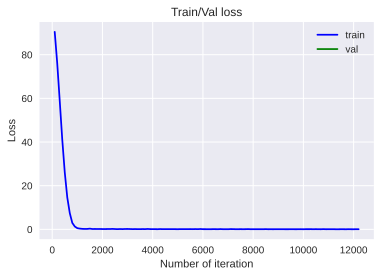

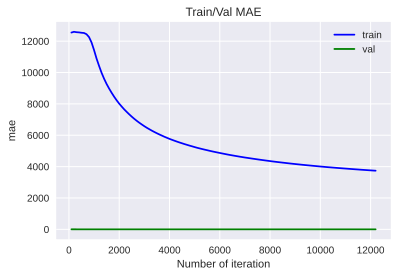

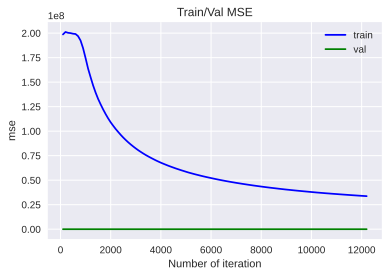

In [ ]:
draw_visualization(iteration_list, train_loss_array,val_loss_array,
         mse_train_loss_array, mse_val_loss_array, 
         mae_train_loss_array, mae_val_loss_array)

**Prediction**

In [ ]:
_ = load_checkpoint('./cnn_avp_best_checkpoint', model_avp, optimizer)

Loading checkpoint './cnn_avp_best_checkpoint'
Loaded checkpoint './cnn_avp_best_checkpoint' from iteration 11899


In [ ]:
mse, mae, test_loss, loss_arr = make_prediction(model_avp, data_test, batch_size=BATCH_SIZE, device=DEVICE)
print('MSE: ', round(mse, 5))
print('MAE: ', round(mae, 5))
print('LOSS: ', round(test_loss, 5))

MSE:  0.01682
MAE:  0.04831
LOSS:  0.06728


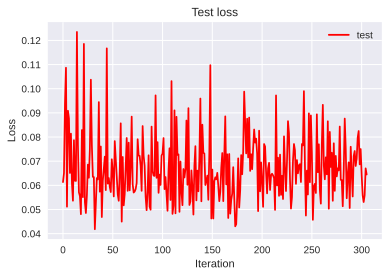

In [ ]:
draw_pred_loss(loss_arr)

**Conclusion**

* Attentive pooling is an approach that enables the pooling layer to be aware of the current input pair, in a way that information from the question q can directly influence the computation of the answer representation ra, and vice versa.
* This model is better than the prev. one. Metrics decrease smoothly. The predictive ability of this model is very good.  Scores are great. 


* *** Average cross-validation scores ***: 

MSE:  0.01682  
MAE:  0.04831  
LOSS:  0.06728  


### **General conclusion №6**

Both pullings work perfectly and coped well with the task. Training of the model is fast due to the reduction of parameters. AttentivePooling worked best on our data, which can be seen by metrics and loss.